<a href="https://colab.research.google.com/github/shavonne-sw/predicting-book-sales-time-series/blob/main/Predicting_Book_Sales_and_Demand_Using_Time_Series_Forecasting_%5BREDACTED%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Packages and Data

In [ ]:
import gdown
import pandas as pd

# Download the files
gdown.download(isbn_list_url, "ISBN_list.xlsx", quiet=False)
gdown.download(uk_weekly_timeline_url, "UK_Weekly_Timeline.xlsx", quiet=False)

# Load Excel files into Pandas DataFrames
isbn_df = pd.read_excel("ISBN_list.xlsx", engine="openpyxl")
uk_weekly_df = pd.read_excel("UK_Weekly_Timeline.xlsx", engine="openpyxl")

In [ ]:
import pandas as pd
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualisation
import seaborn as sns  # For advanced data visualisation
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA modeling
from sklearn.model_selection import train_test_split  # For data splitting
from tensorflow import keras  # For deep learning


# Read data from all four tabs in both datasets
# Read all sheets from ISBN_list.xlsx
isbn_sheets = pd.ExcelFile('ISBN_list.xlsx', engine='openpyxl')
isbn_tabs = []
for sheet_name in isbn_sheets.sheet_names:
    isbn_tabs.append(pd.read_excel(isbn_sheets, sheet_name=sheet_name))

# Concatenate ISBN tabs into a single DataFrame
isbn_df = pd.concat(isbn_tabs, ignore_index=True)

# Read all sheets from UK_Weekly_Timeline.xlsx
weekly_sheets = pd.ExcelFile('UK_Weekly_Timeline.xlsx', engine='openpyxl')
weekly_tabs = []
for sheet_name in weekly_sheets.sheet_names:
    weekly_tabs.append(pd.read_excel(weekly_sheets, sheet_name=sheet_name))

# Concatenate weekly tabs into a single DataFrame
uk_weekly_df = pd.concat(weekly_tabs, ignore_index=True)

In [ ]:
# EDA ISBN dataset
isbn_df.head()

ISBN                                              Title  \
0  9780330375252                Bridget Jones's Diary (Film Tie-in)   
1  9780140276336                                        White Teeth   
2  9780006512134                                        Man and Boy   
3  9780099280255                                       Brethren,The   
4  9780552998727  Marrying The Mistress:an irresistible and grip...   

             Author                   Imprint    Publisher Group    RRP  \
0   Fielding, Helen                   Picador  Pan Macmillan Grp   8.99   
1      Smith, Zadie         Penguin Books Ltd        Penguin Grp   9.99   
2     Parsons, Tony  HarperCollins Publishers  HarperCollins Grp   8.99   
3     Grisham, John               Arrow Books   Random House Grp   6.99   
4  Trollope, Joanna                Black Swan     Transworld Grp  10.99   

     Binding Publication Date                     Product Class  \
0  Paperback       2001-03-23   F1.1 General & Literary Fiction   
1  Paperback       2001-01-25   F1.1 General & Literary Fiction   
2  Paperback       2000-03-06   F1.1 General & Literary Fiction   
3  Paperback       2000-12-27  F2.1 Crime, Thriller & Adventure   
4  Paperback       2001-02-01   F1.1 General & Literary Fiction   

  Country of Publication  
0         United Kingdom  
1         United Kingdom  
2         United Kingdom  
3         United Kingdom  
4         United Kingdom

In [ ]:
# EDA weekly dataset
uk_weekly_df.head()

ISBN            Title         Author  Interval   End Date  Volume  \
0  9780002261821  One For My Baby  Parsons, Tony    200513 2005-04-02       1   
1  9780002261821  One For My Baby  Parsons, Tony    200503 2005-01-22       1   
2  9780002261821  One For My Baby  Parsons, Tony    200422 2004-05-29       1   
3  9780002261821  One For My Baby  Parsons, Tony    200415 2004-04-10       2   
4  9780002261821  One For My Baby  Parsons, Tony    200404 2004-01-24       2   

   Value    ASP    RRP   Binding                   Imprint    Publisher Group  \
0  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
1  15.99  15.99  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
2  11.19  11.19  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
3  27.18  13.59  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   
4  22.48  11.24  15.99  Hardback  HarperCollins Publishers  HarperCollins Grp   

                     Product Class  
0  F1.1 General & Literary Fiction  
1  F1.1 General & Literary Fiction  
2  F1.1 General & Literary Fiction  
3  F1.1 General & Literary Fiction  
4  F1.1 General & Literary Fiction

In [ ]:
uk_weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227224 entries, 0 to 227223
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ISBN             227224 non-null  int64         
 1   Title            227224 non-null  object        
 2   Author           212345 non-null  object        
 3   Interval         227224 non-null  int64         
 4   End Date         227224 non-null  datetime64[ns]
 5   Volume           227224 non-null  int64         
 6   Value            227224 non-null  float64       
 7   ASP              226881 non-null  float64       
 8   RRP              221262 non-null  float64       
 9   Binding          227224 non-null  object        
 10  Imprint          227224 non-null  object        
 11  Publisher Group  227224 non-null  object        
 12  Product Class    227224 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 22.5+ 

In [ ]:
# Check missing values
uk_weekly_df.isnull().sum()

ISBN                   0
Title                  0
Author             14879
Interval               0
End Date               0
Volume                 0
Value                  0
ASP                  343
RRP                 5962
Binding                0
Imprint                0
Publisher Group        0
Product Class          0
dtype: int64



---


* It is worth noting that the target variable 'Volume' contains no missing values, which is a positive indication for proceeding to the next steps.


---



In [ ]:
# Check time range
min_date = uk_weekly_df['End Date'].min()
max_date = uk_weekly_df['End Date'].max()

print(f"The data ranges from {min_date} to {max_date}.")

The data ranges from 2001-01-06 00:00:00 to 2024-07-20 00:00:00.


In [ ]:
# Find unique titles in weekly dataset
num_unique_titles_weekly = uk_weekly_df['Title'].nunique()
print(f"There are {num_unique_titles_weekly} unique titles in the UK Weekly Timeline dataset.")

There are 471 unique titles in the UK Weekly Timeline dataset.


# 2. Performing Initial Data Investigation

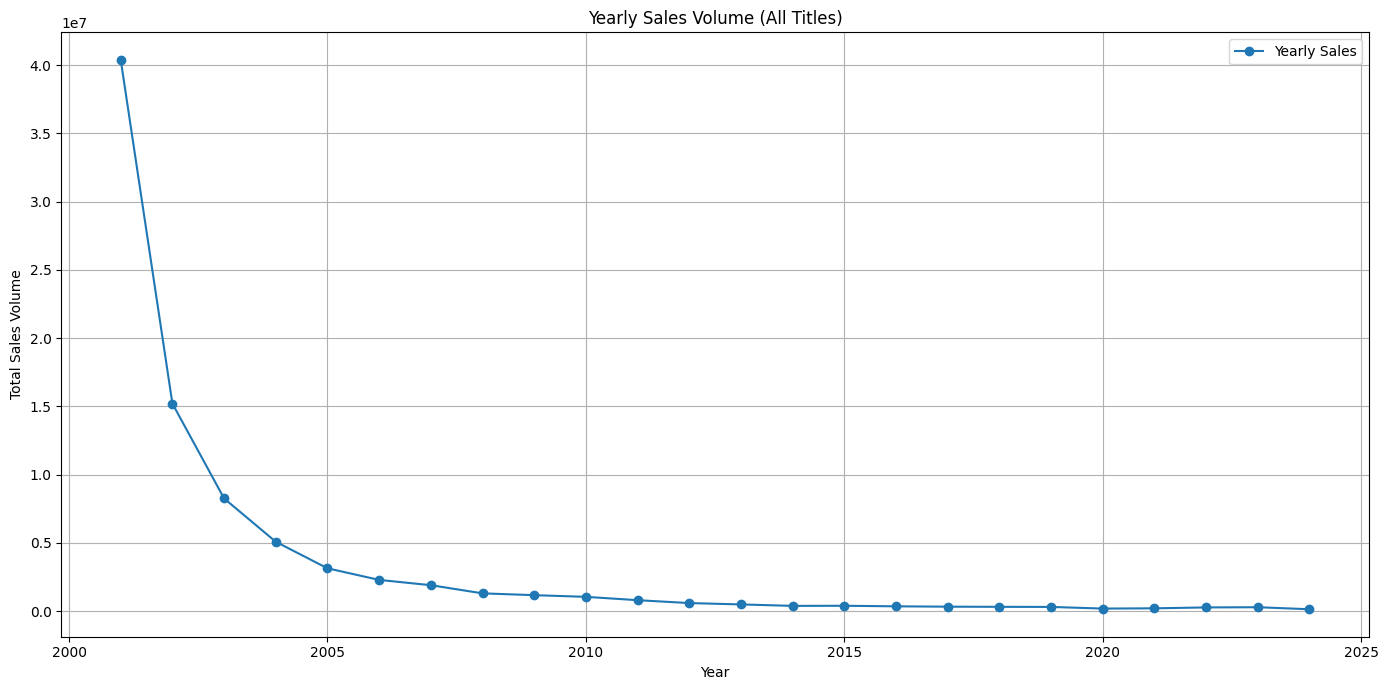

In [ ]:
# Plot a yearly trend to visualise the global sales trend across all titles
# Set 'End Date' as index (Setting Date as index tells Python: "This is a timeline, not just random data - We want the model to respect sequence and gaps properly")
uk_weekly_df = uk_weekly_df.reset_index()

# Convert 'End Date' to DatetimeIndex
uk_weekly_df['End Date'] = pd.to_datetime(uk_weekly_df['End Date'])
uk_weekly_df = uk_weekly_df.set_index('End Date')

# Now extract year from the DatetimeIndex
uk_weekly_df['Year'] = uk_weekly_df.index.year

# Group by year and sum volume
yearly_sales = uk_weekly_df.groupby('Year')['Volume'].sum()

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(yearly_sales.index, yearly_sales.values, label='Yearly Sales', marker='o')  # Added marker for better visualisation
plt.title('Yearly Sales Volume (All Titles)')
plt.xlabel('Year')
plt.ylabel('Total Sales Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---


* The graph represents the sales trend of all book titles in the dataset, indicative of the book-selling business as a whole. Sales peaked in the early 2000s, reaching approximately 40 million units for 471 titles. After this peak, a significant downward trend is observed. By 2024, the sales volume appears to have decreased to a very low level, nearly reaching the baseline of the graph. Overall, the chart illustrates a consistent downward trajectory in sales over the years.


---



In [ ]:
# Resample the data
# Convert ISBN to string (important for joining / matching later)
uk_weekly_df['ISBN'] = uk_weekly_df['ISBN'].astype(str)

# Resample weekly (Fill missing weeks with 0 sales)
# Important: Group by ISBN first, because multiple books!
uk_weekly_df = uk_weekly_df.groupby('ISBN').resample('W').sum()

# Check the type of index (End Date is now part of the index)
print(uk_weekly_df.index.dtype)  # Should print: datetime64[ns]

object


In [ ]:
# Explicitly convert the index to datetime if it's not already in correct format
uk_weekly_df.index = pd.to_datetime(uk_weekly_df.index.get_level_values('End Date'))

# Now check the dtype of the index
print(uk_weekly_df.index.dtype)  # Should print: datetime64[ns]

datetime64[ns]


In [ ]:
# Strip whitespace and ensure ISBN is a string
uk_weekly_df['ISBN'] = uk_weekly_df['ISBN'].astype(str).str.strip()

# Set cutoff date
cutoff_date = pd.to_datetime('2024-07-01')

# Filter the data: Keep rows where the date is AFTER the cutoff
filtered_df = uk_weekly_df[uk_weekly_df.index > cutoff_date]

# Remove any rows where ISBN is '0' or NaN from filtered_df
filtered_df = filtered_df[(filtered_df['ISBN'] != '0') & (filtered_df['ISBN'].notna())]

# Get the ISBNs that satisfy this criterion
valid_isbns = filtered_df['ISBN'].unique()

# Get the number of unique ISBNs
num_isbns = len(valid_isbns)

# Print the number of ISBNs
print(f"The exact number of ISBNs with sales data beyond 2024-07-01 is: {num_isbns}")

# Display the filtered ISBNs
print("ISBNs with sales data beyond 2024-07-01:")
print(valid_isbns)

The exact number of ISBNs with sales data beyond 2024-07-01 is: 61
ISBNs with sales data beyond 2024-07-01:
['9780006512134' '9780006514091' '9780006514213' '9780006531203'
 '9780006550433' '9780006647553' '9780007101887' '9780091816971'
 '9780091867775' '9780099244721' '9780099285823' '9780099286387'
 '9780099286578' '9780099422587' '9780099428558' '9780099771517'
 '9780140259506' '9780140275421' '9780140276336' '9780140276619'
 '9780140281293' '9780140285215' '9780140294231' '9780140295962'
 '9780224060875' '9780241003008' '9780261103252' '9780330355667'
 '9780340696767' '9780340766057' '9780340786055' '9780349112763'
 '9780349113609' '9780349114033' '9780440864141' '9780440864554'
 '9780552145053' '9780552145060' '9780552145954' '9780552997034'
 '9780552997348' '9780552998000' '9780552998444' '9780552998482'
 '9780552998727' '9780593048153' '9780719559792' '9780722532935'
 '9780744523232' '9780747268161' '9780749395698' '9780749397548'
 '9780752844299' '9780752846576' '9781841150437

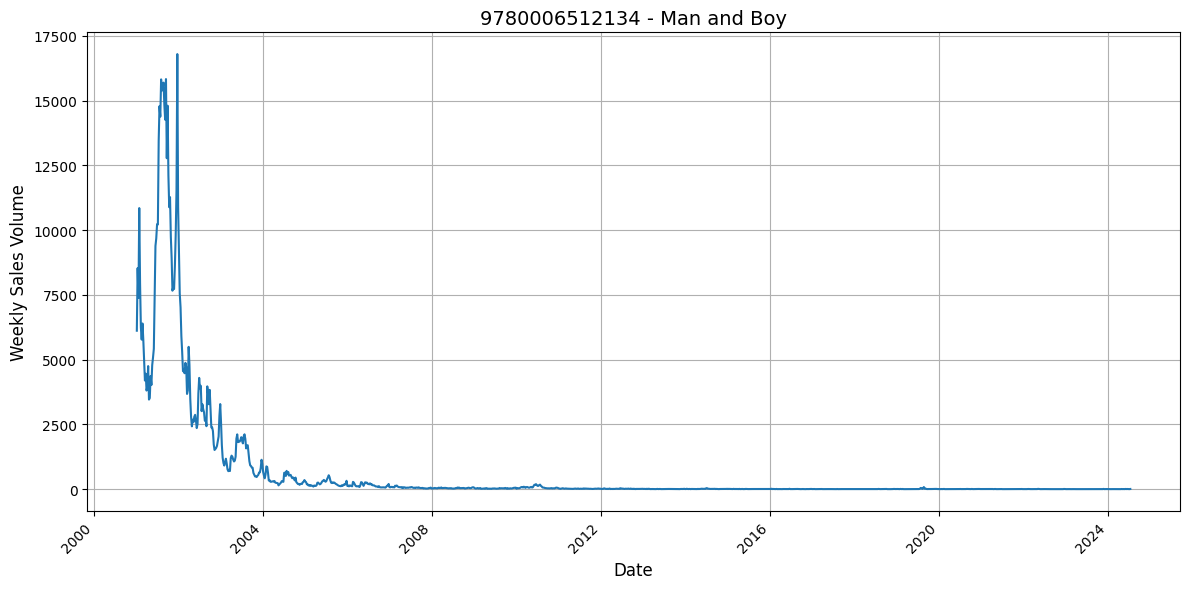

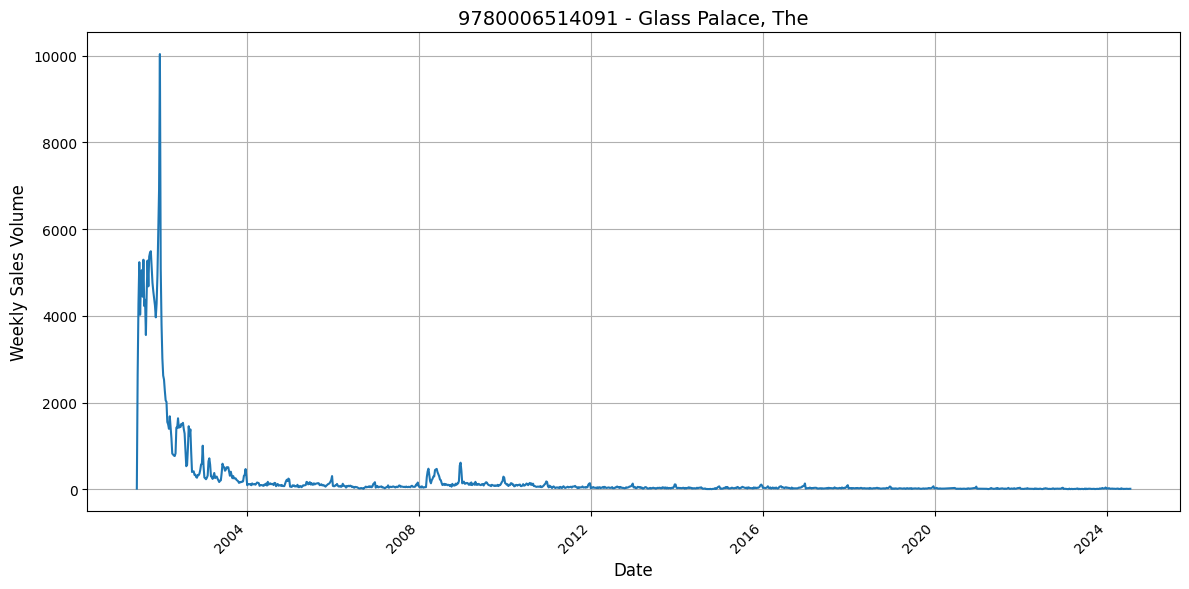

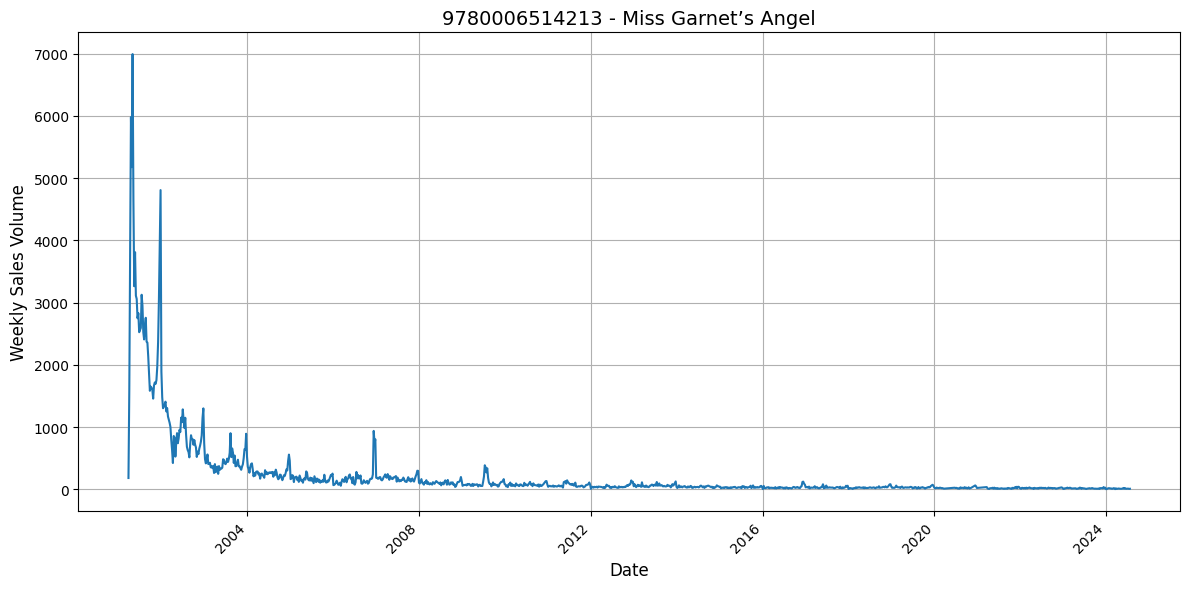

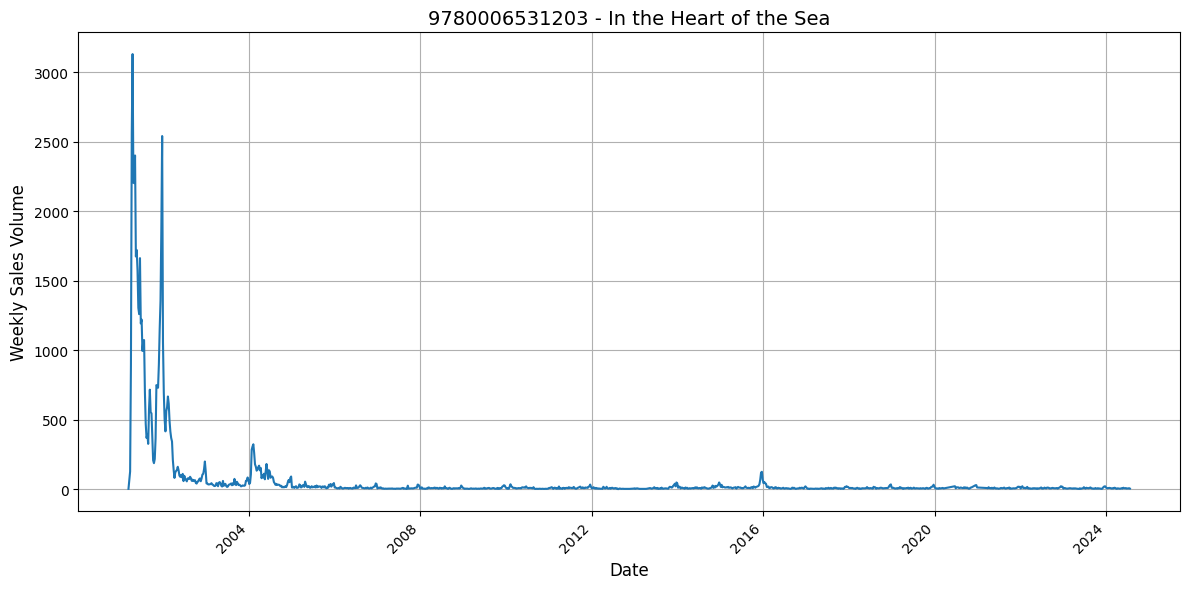

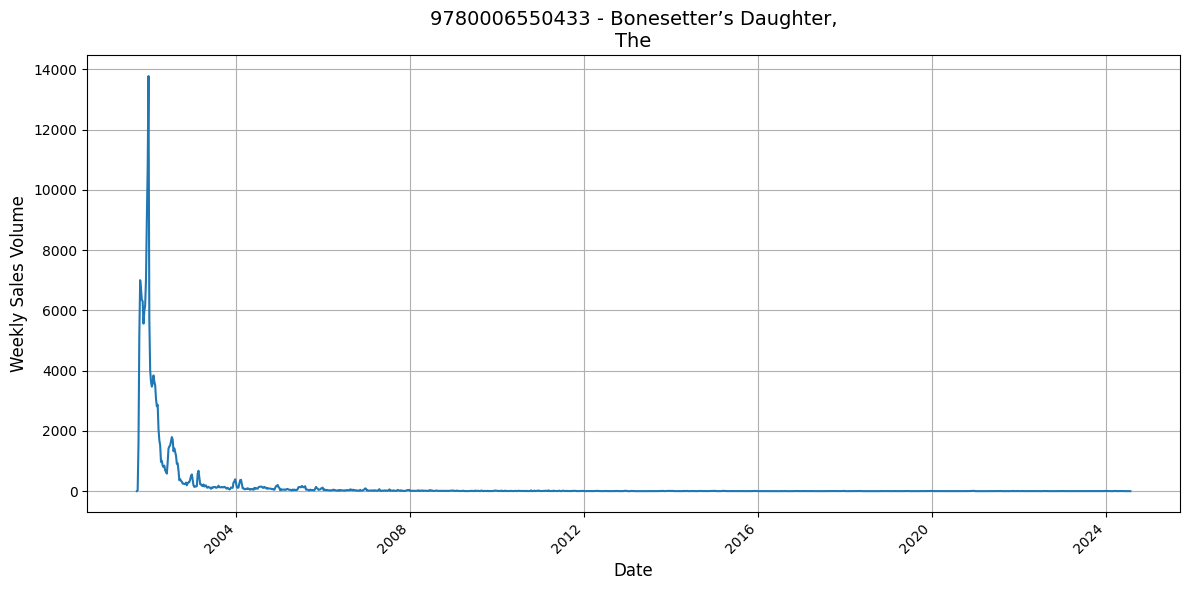

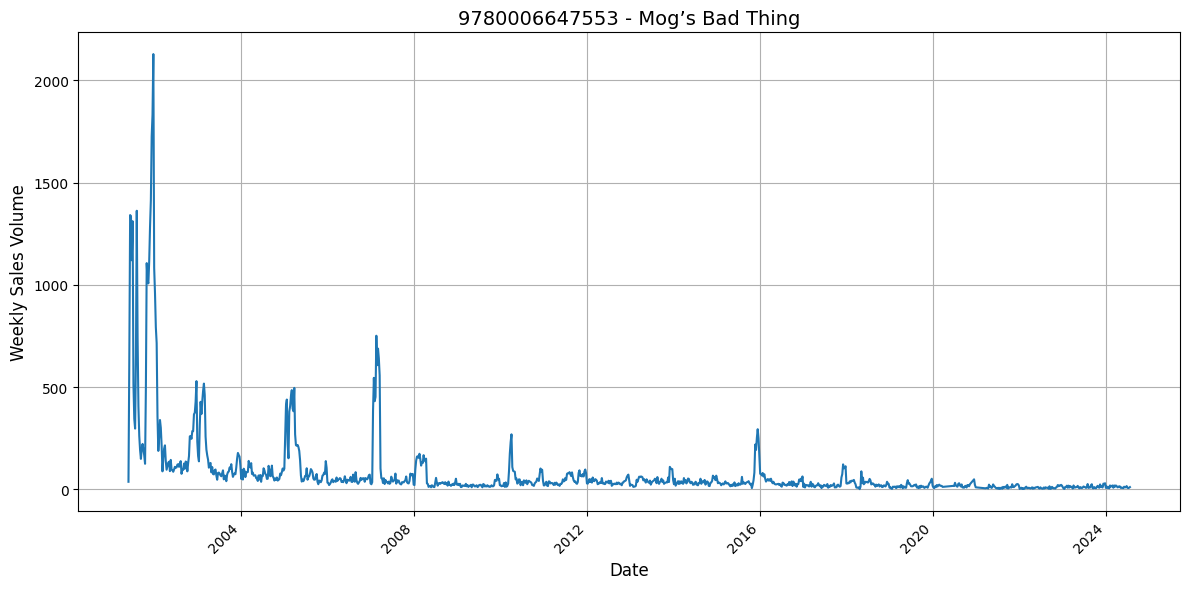

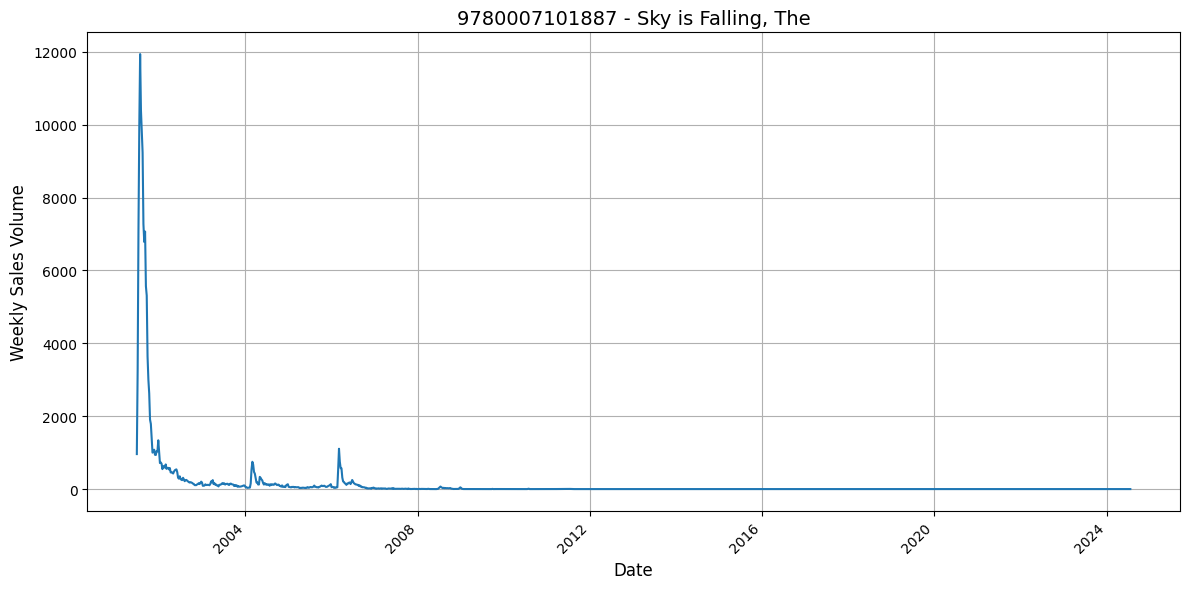

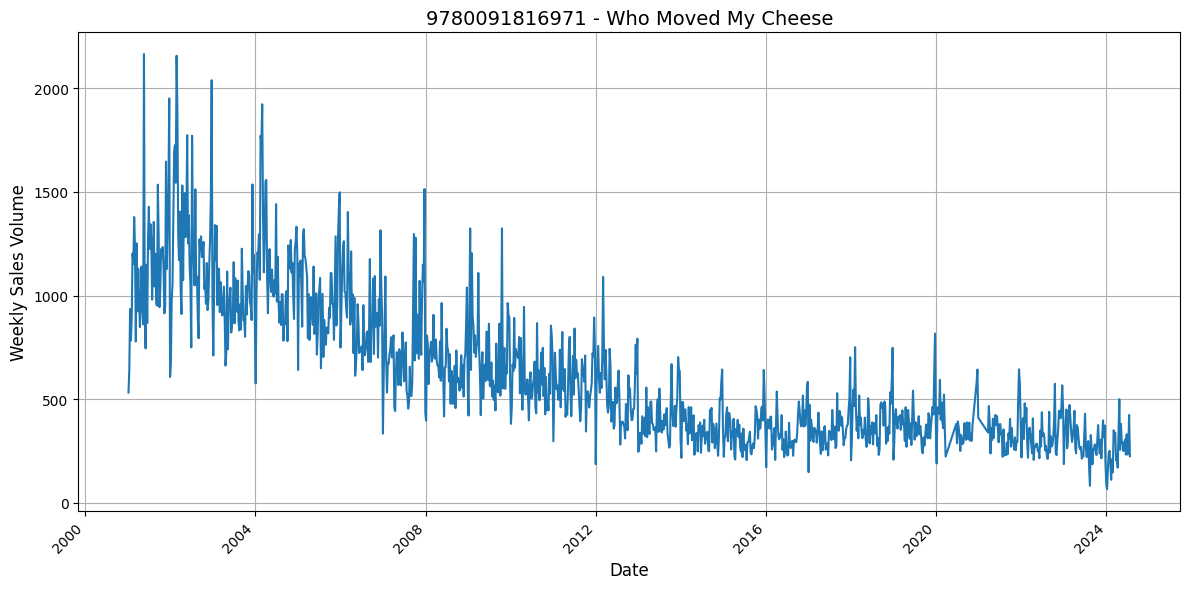

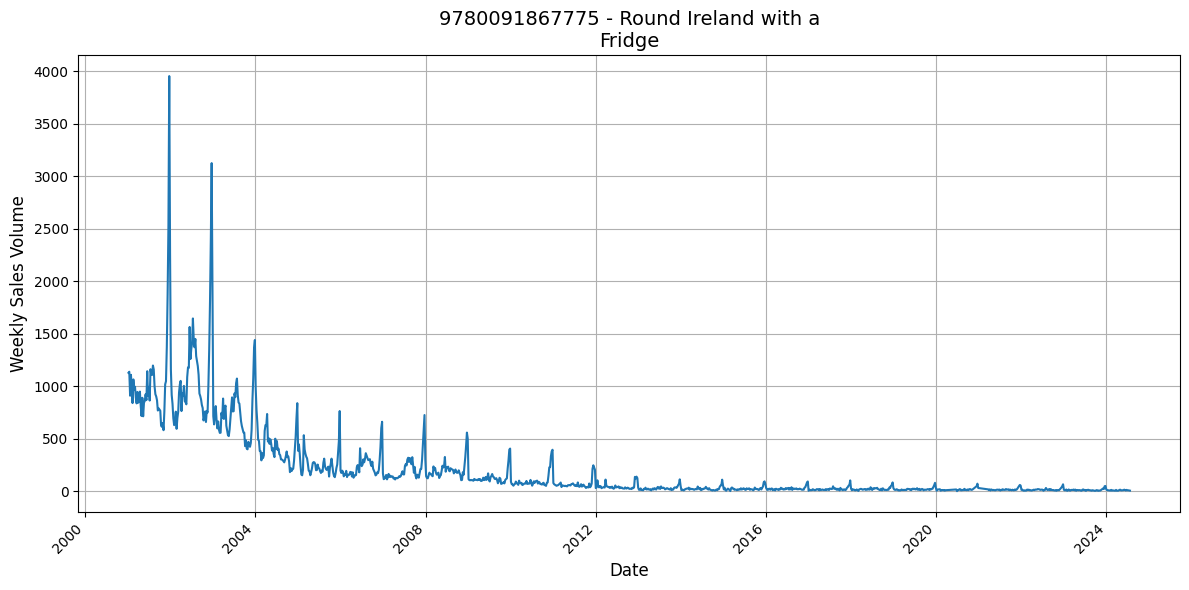

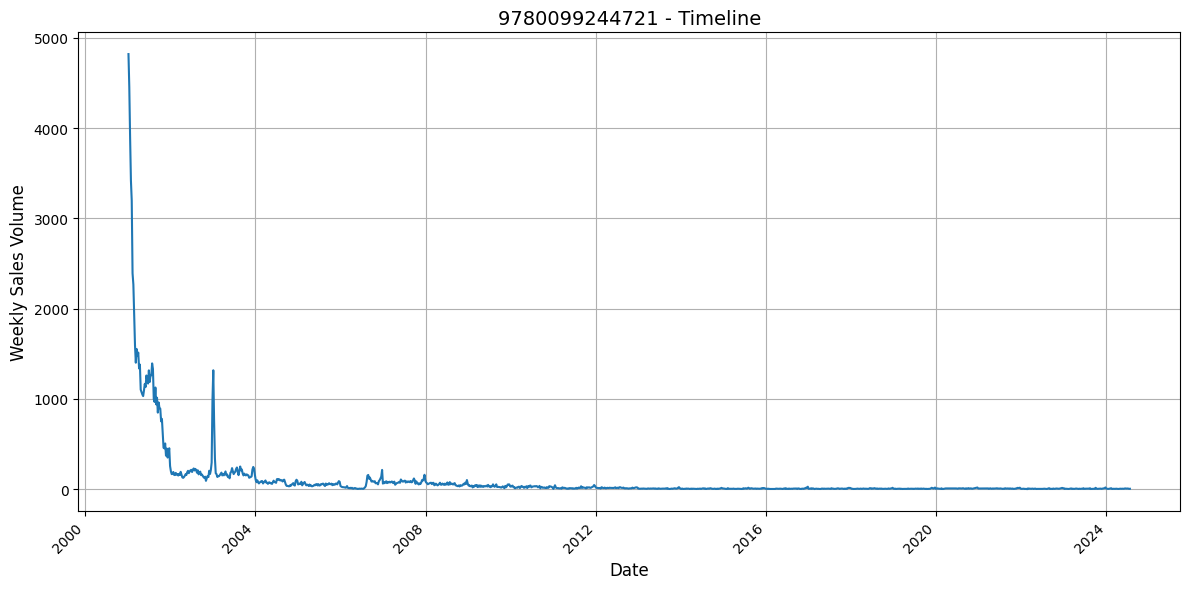

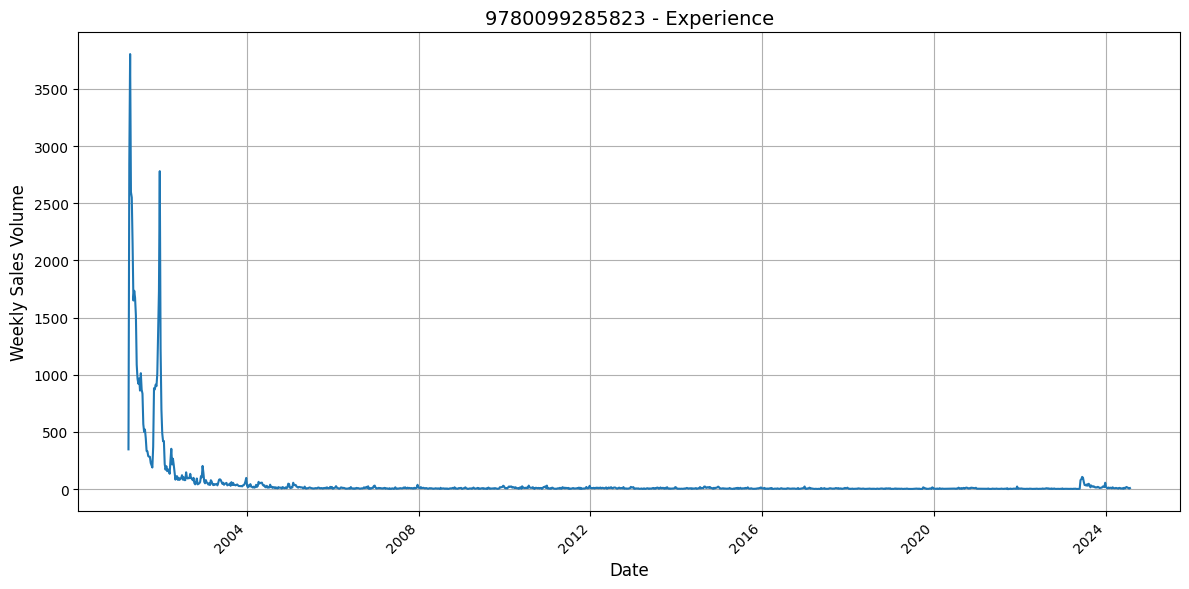

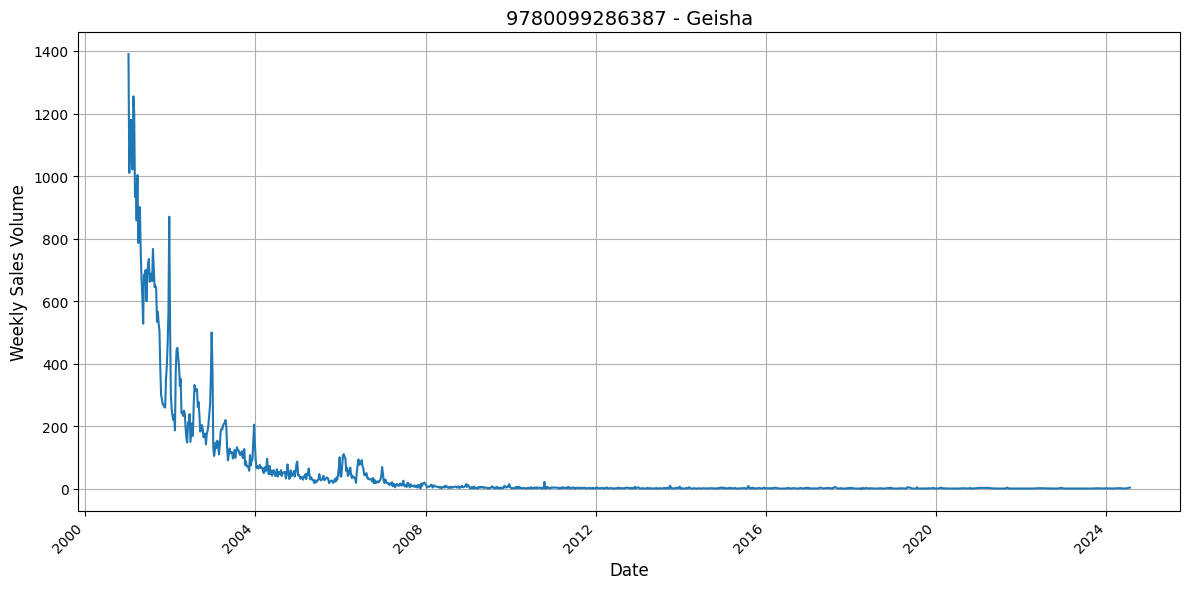

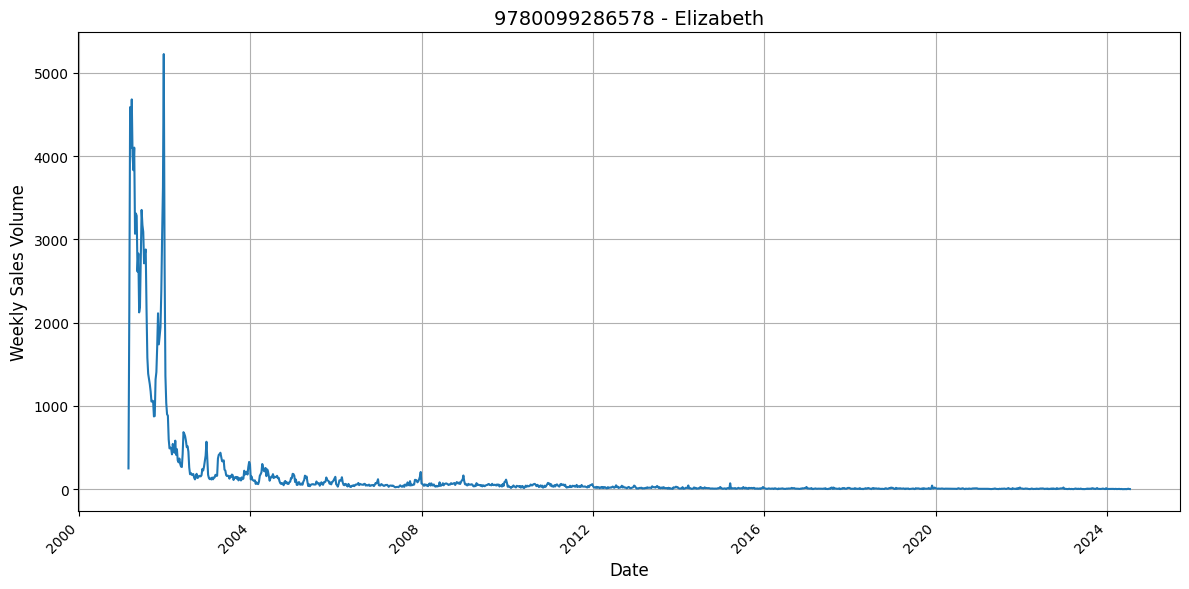

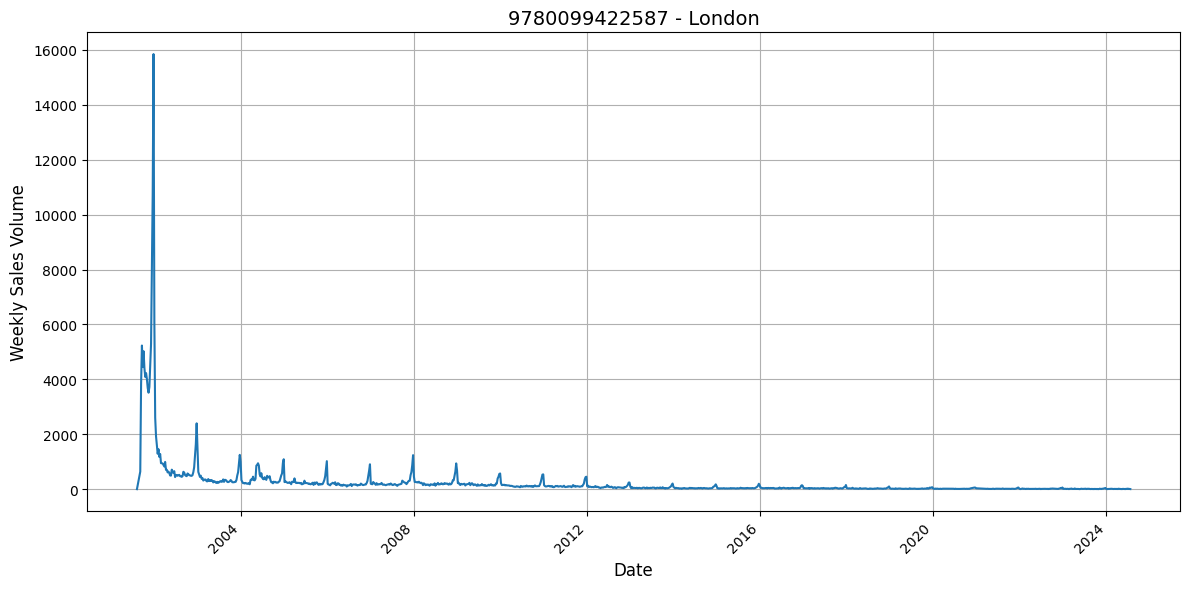

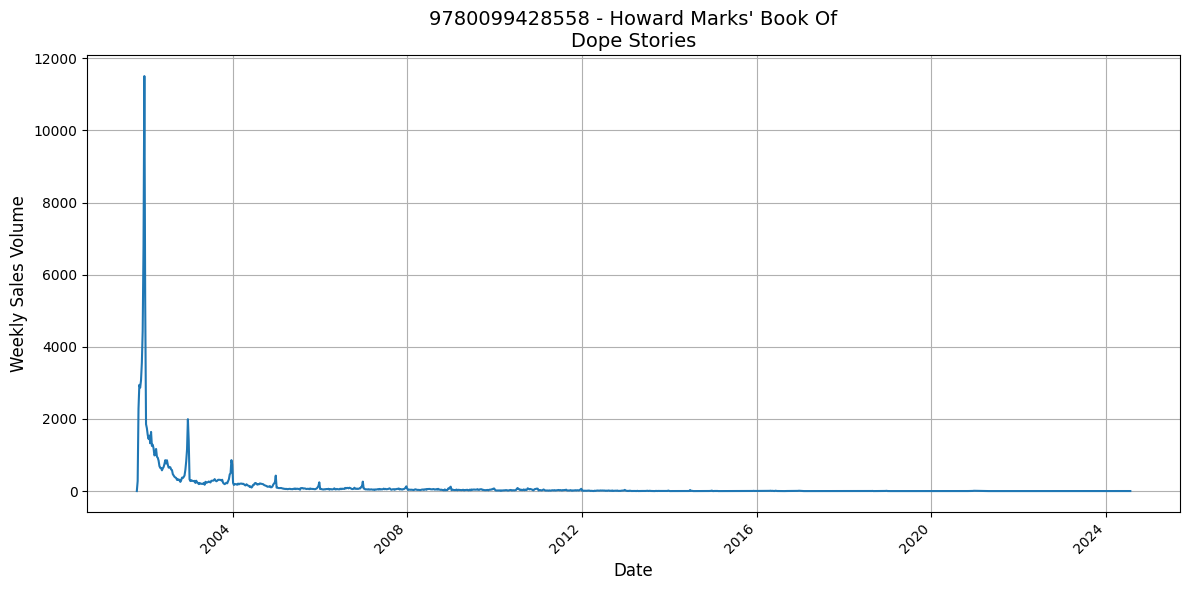

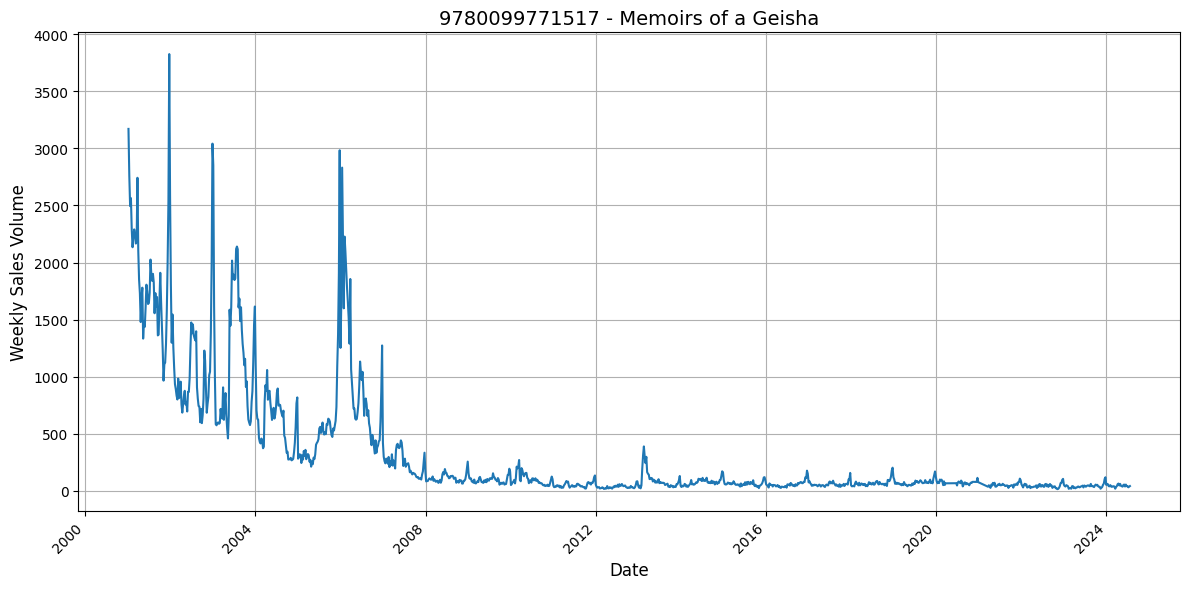

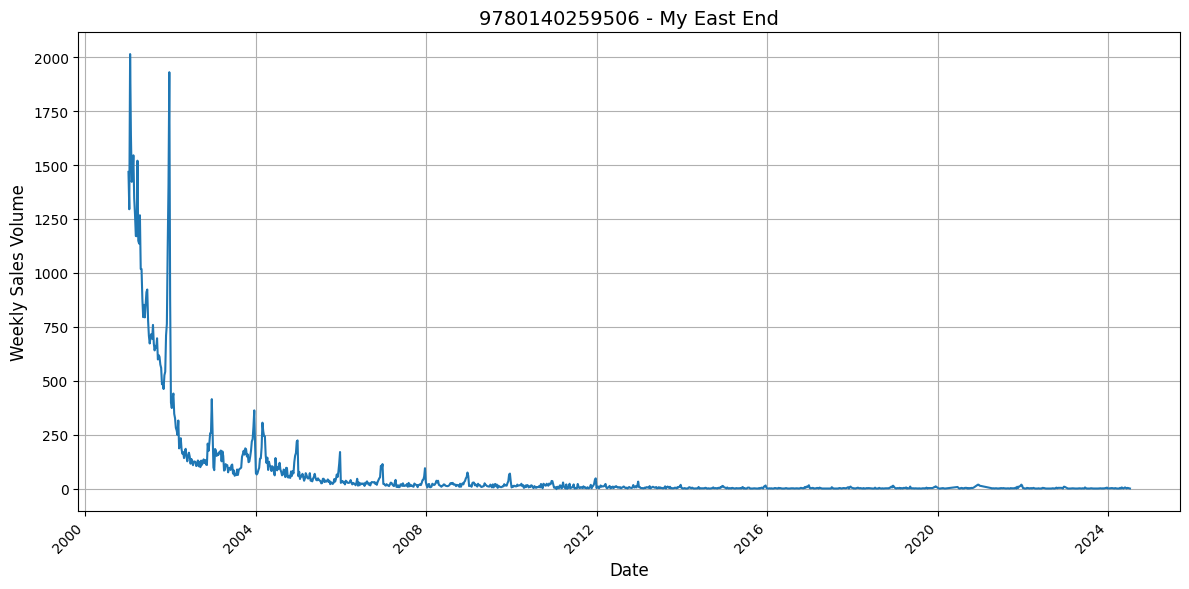

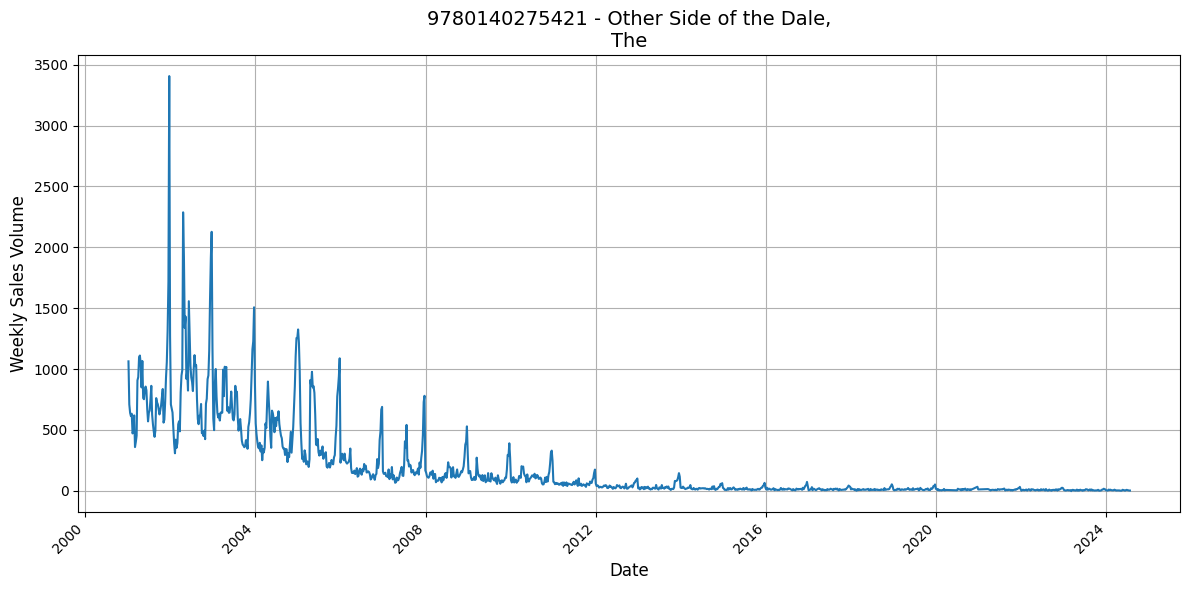

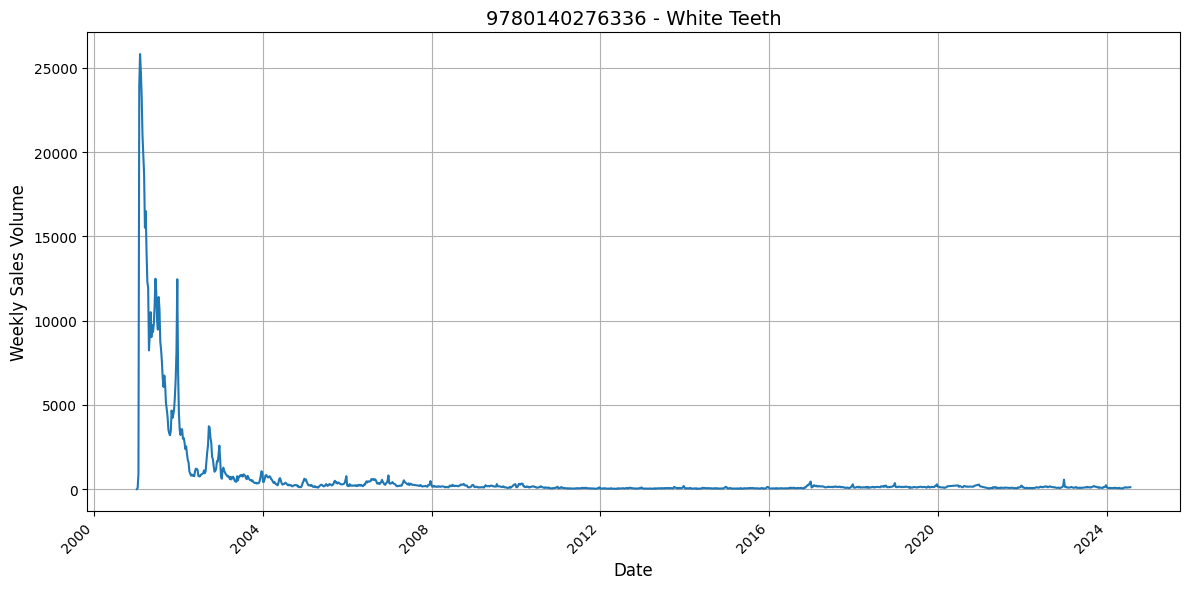

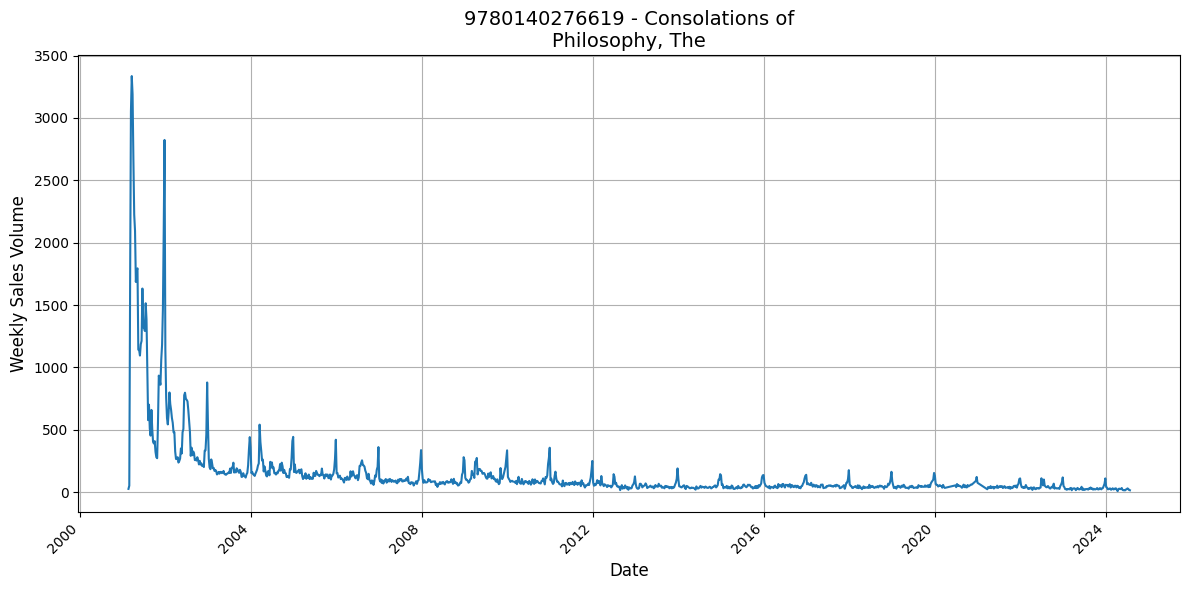

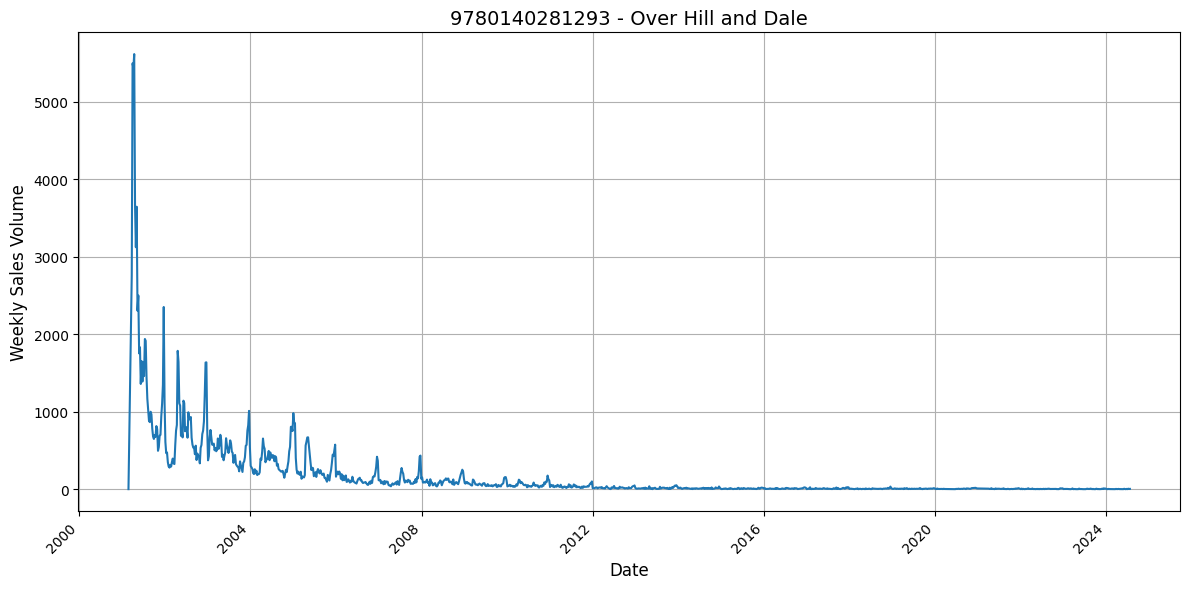

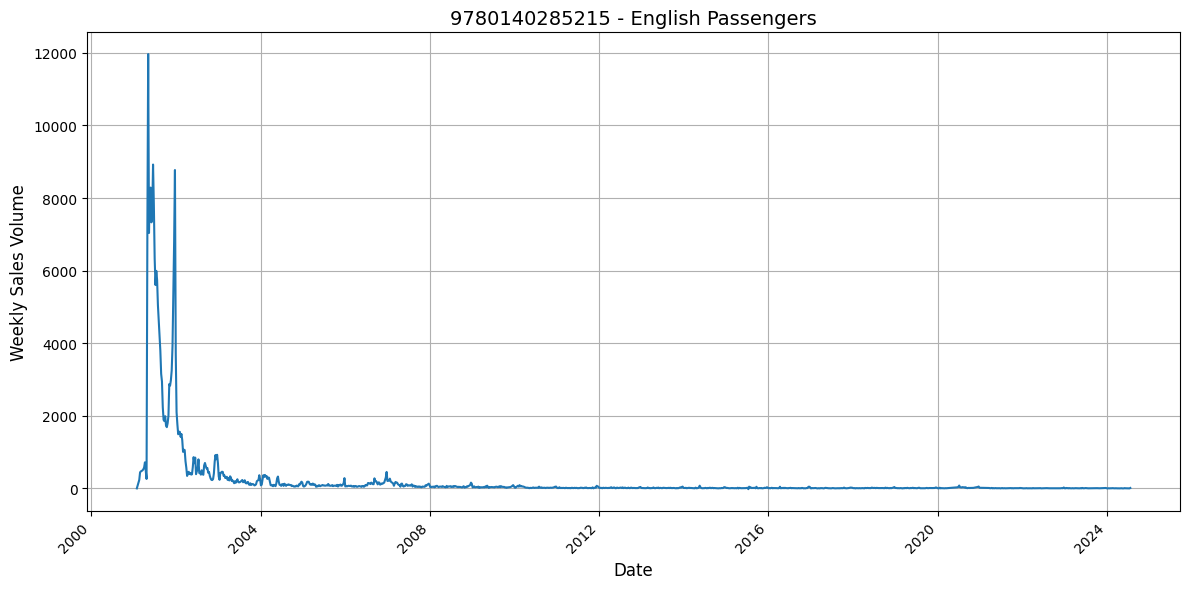

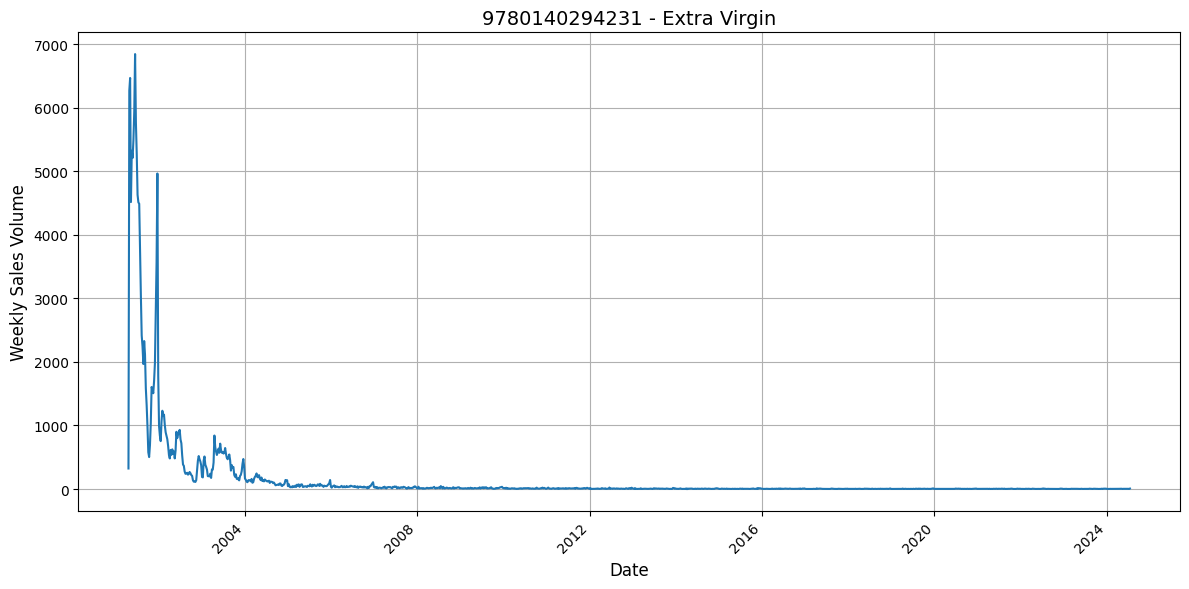

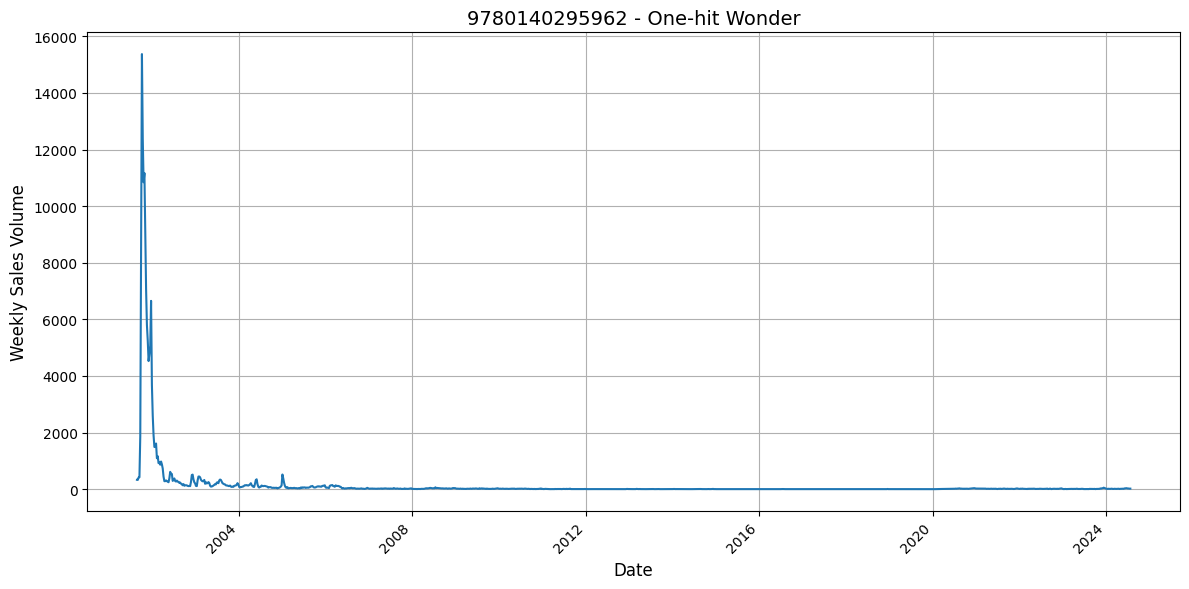

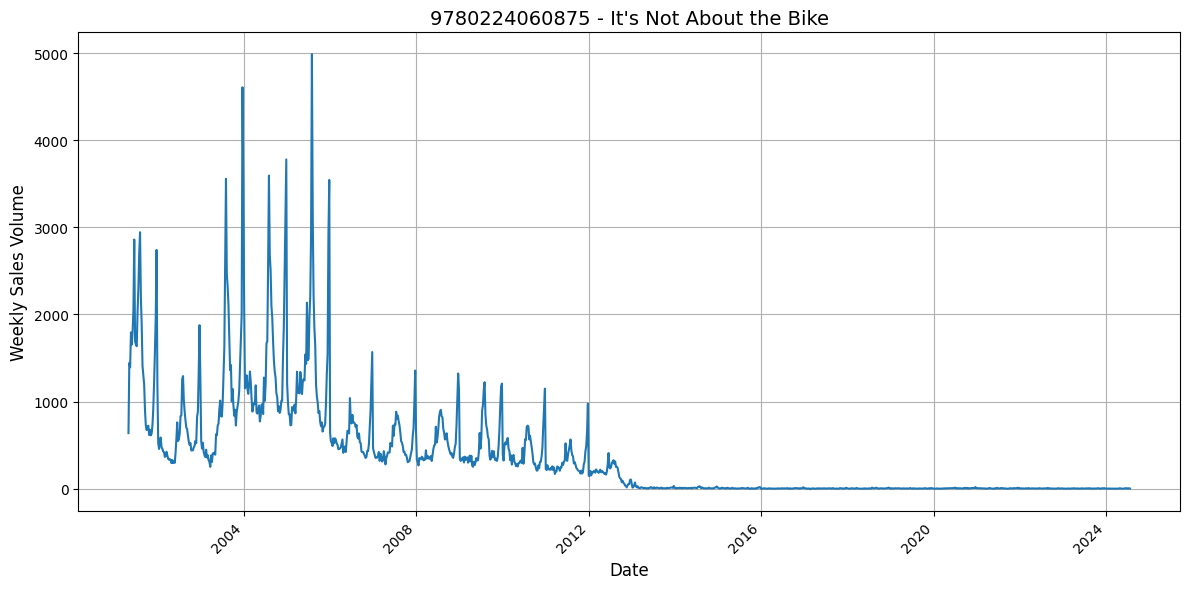

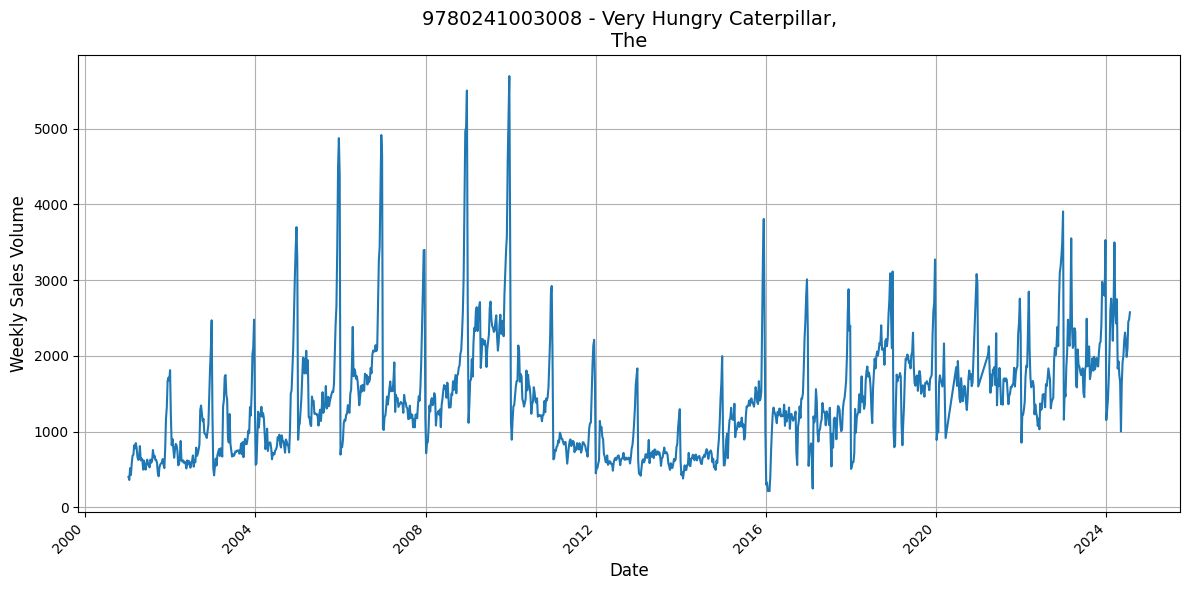

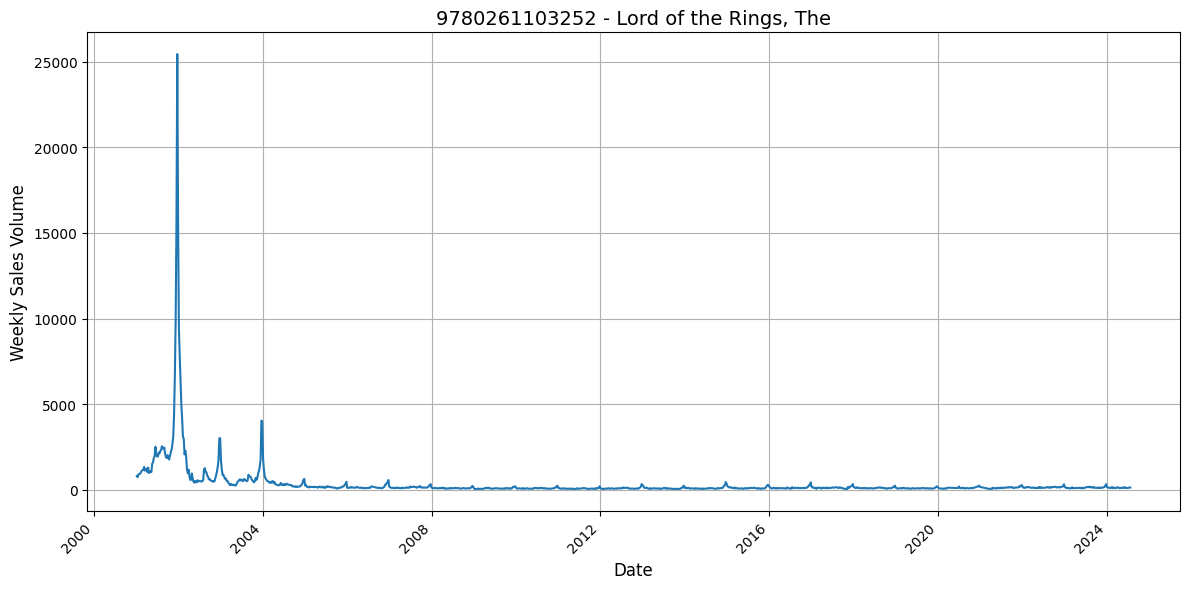

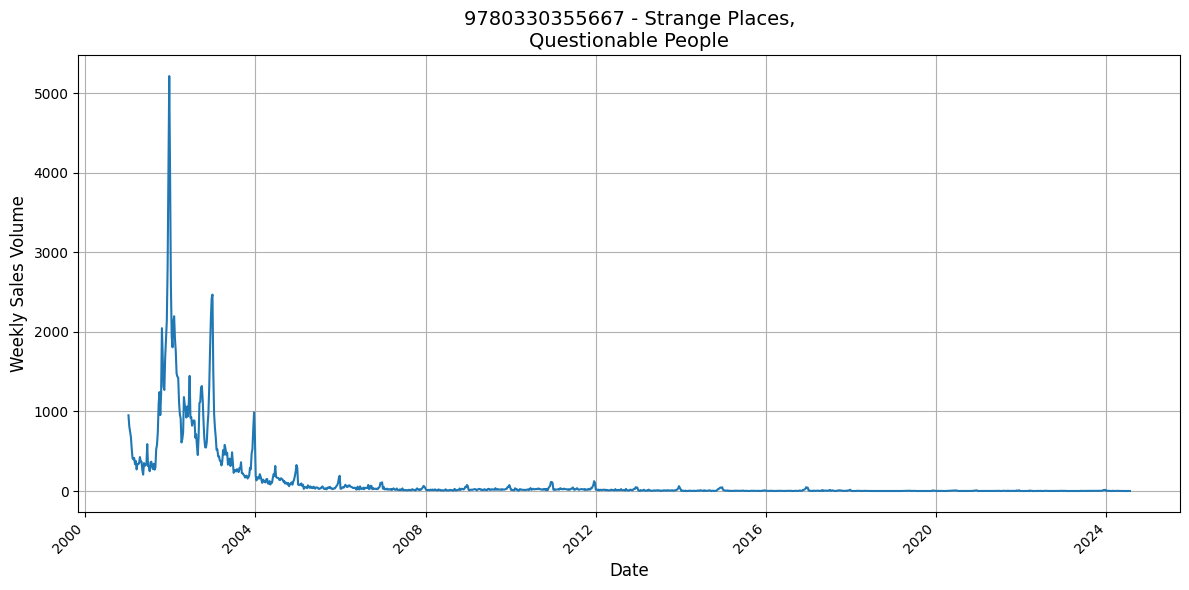

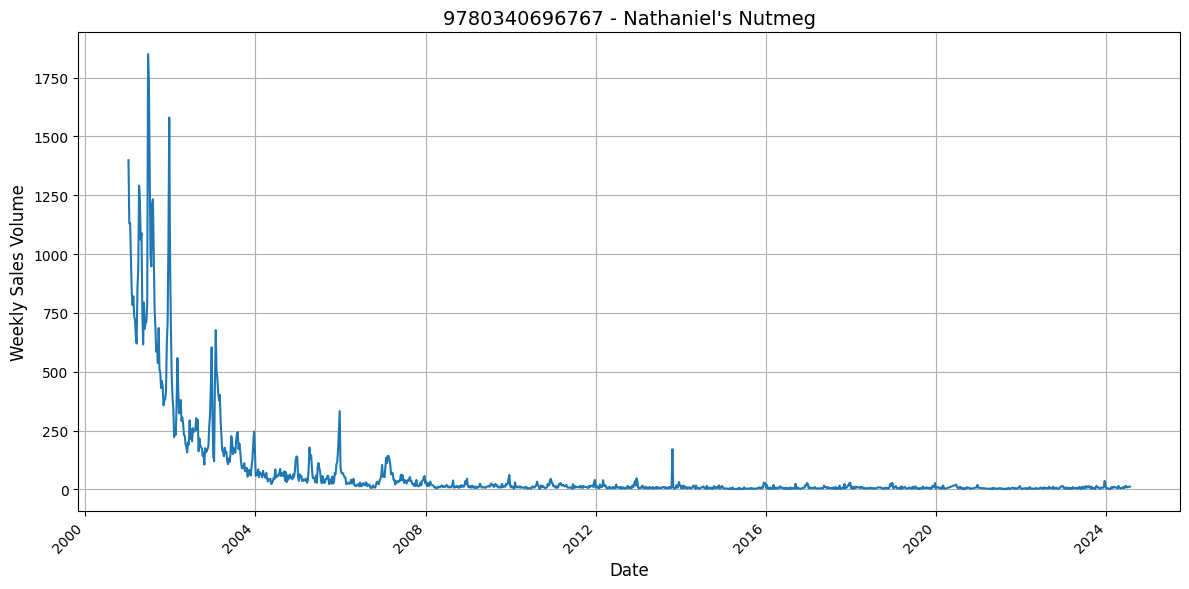

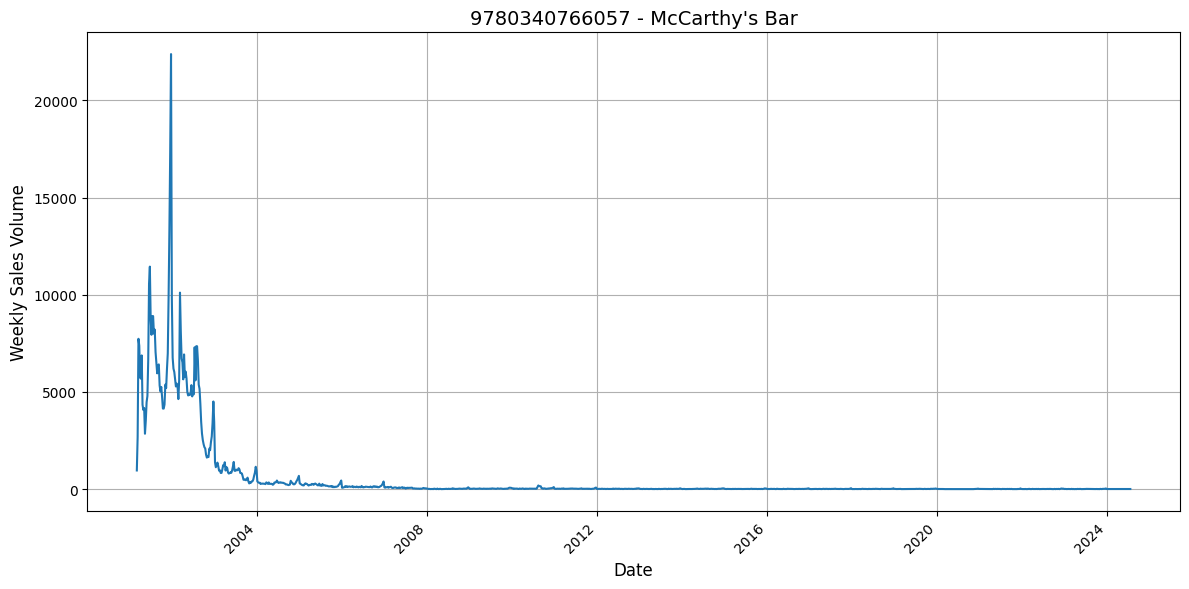

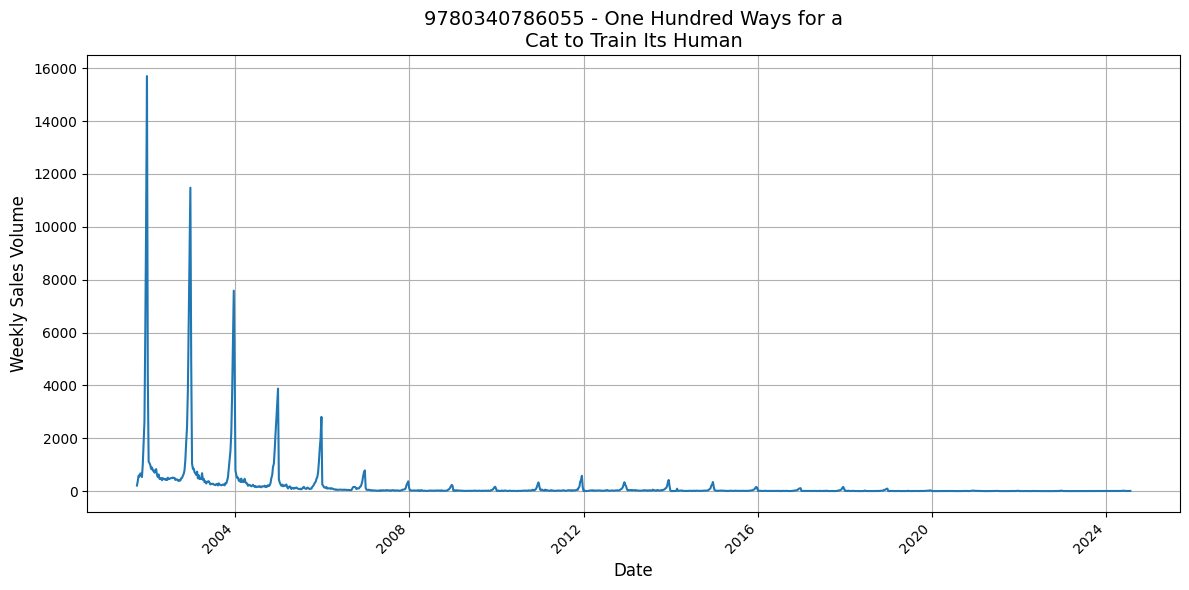

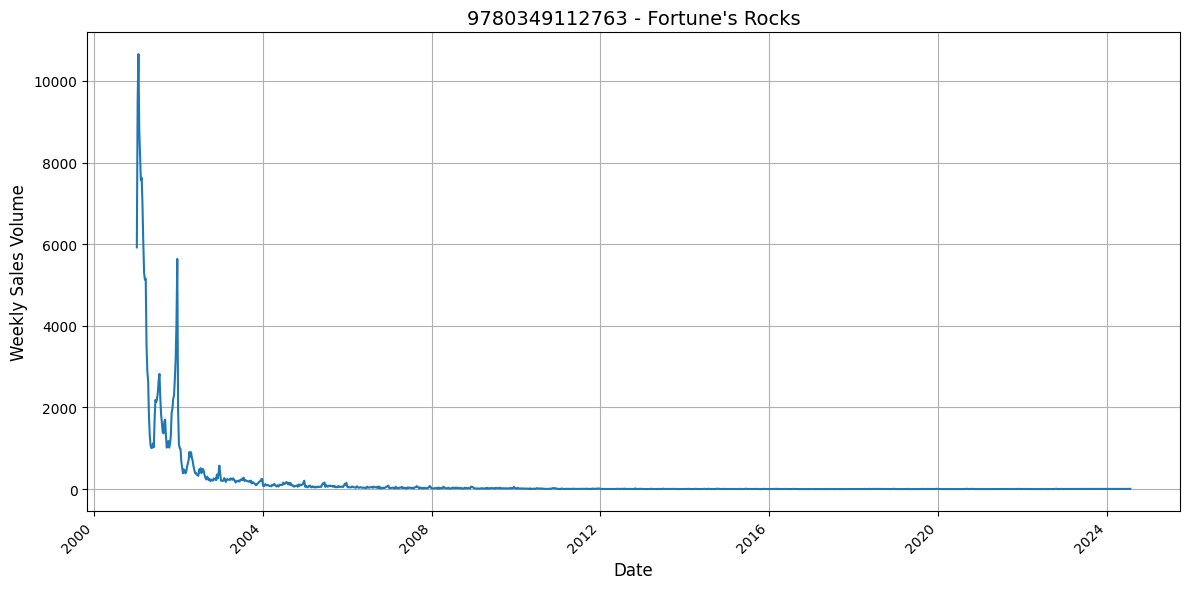

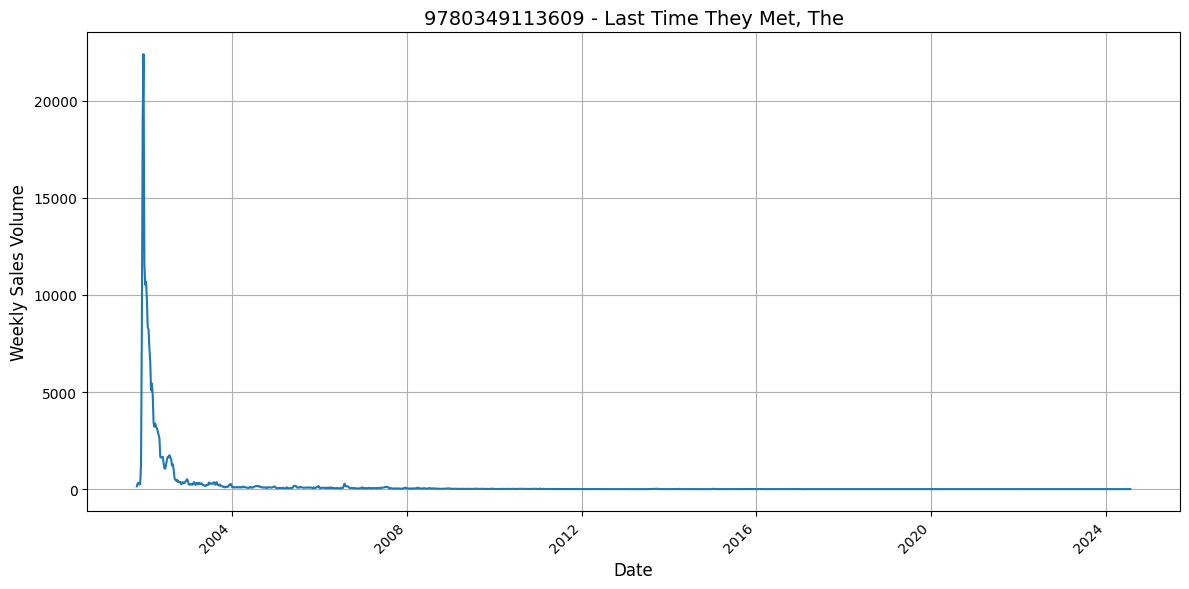

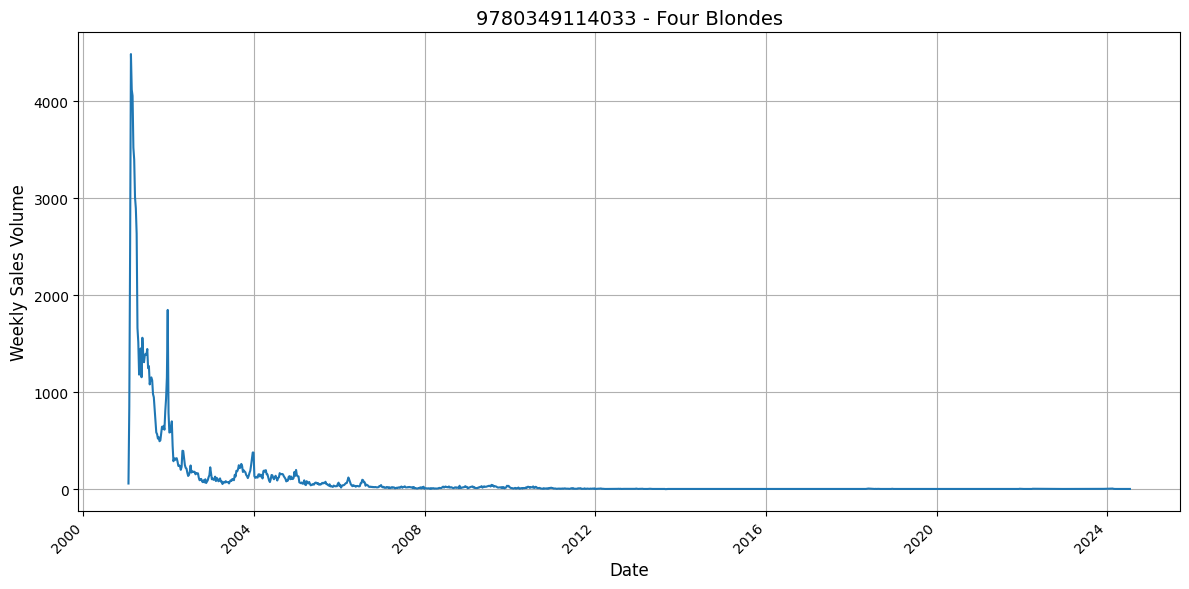

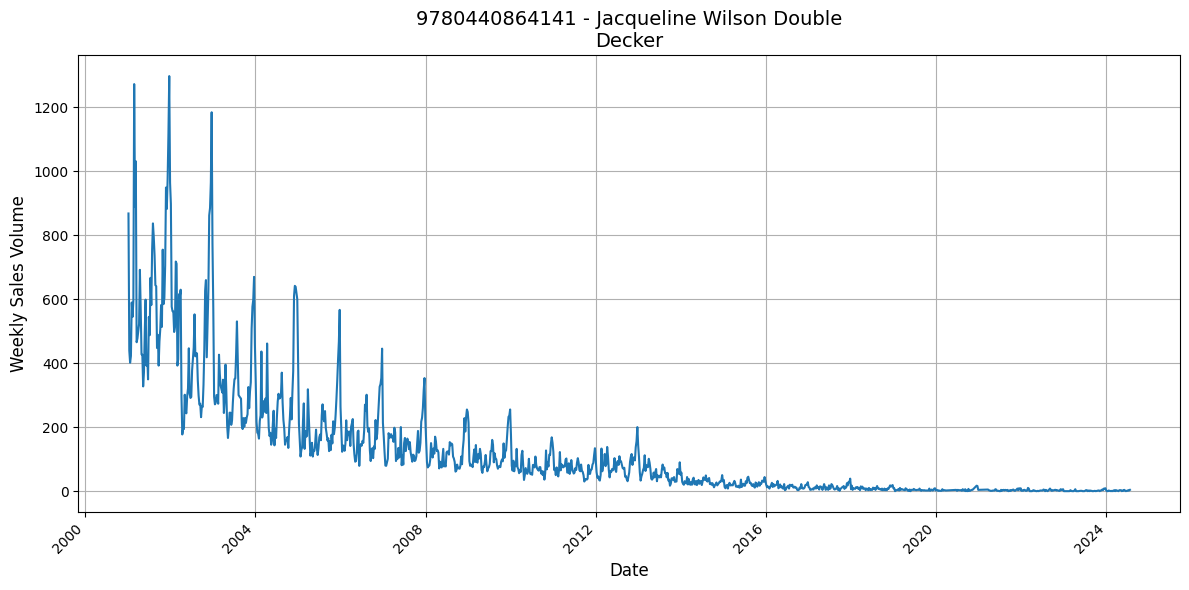

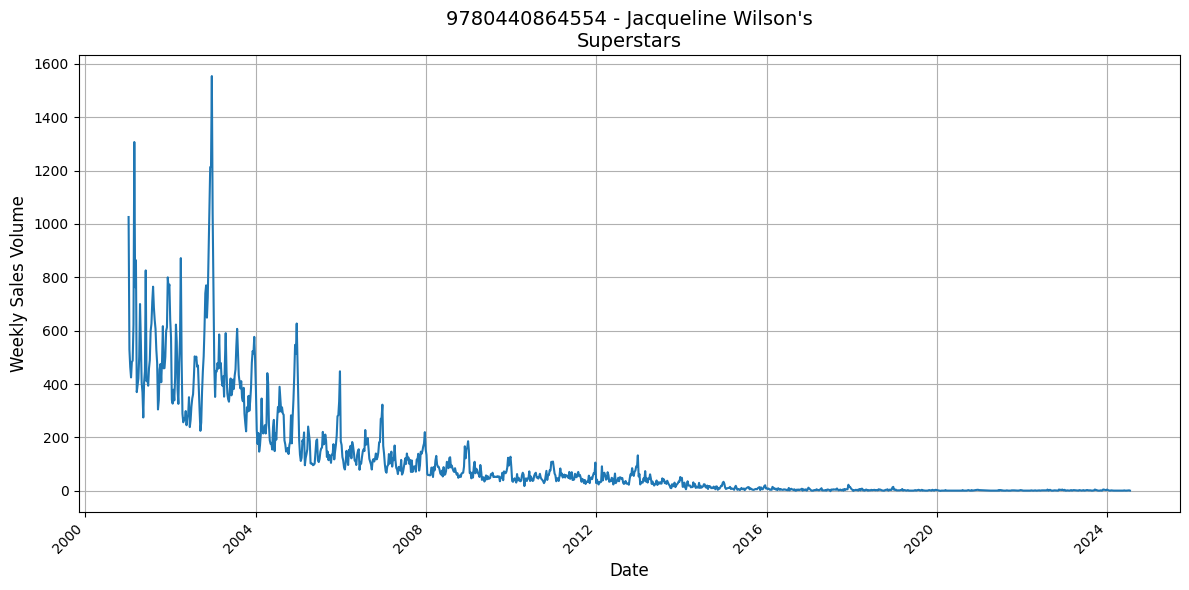

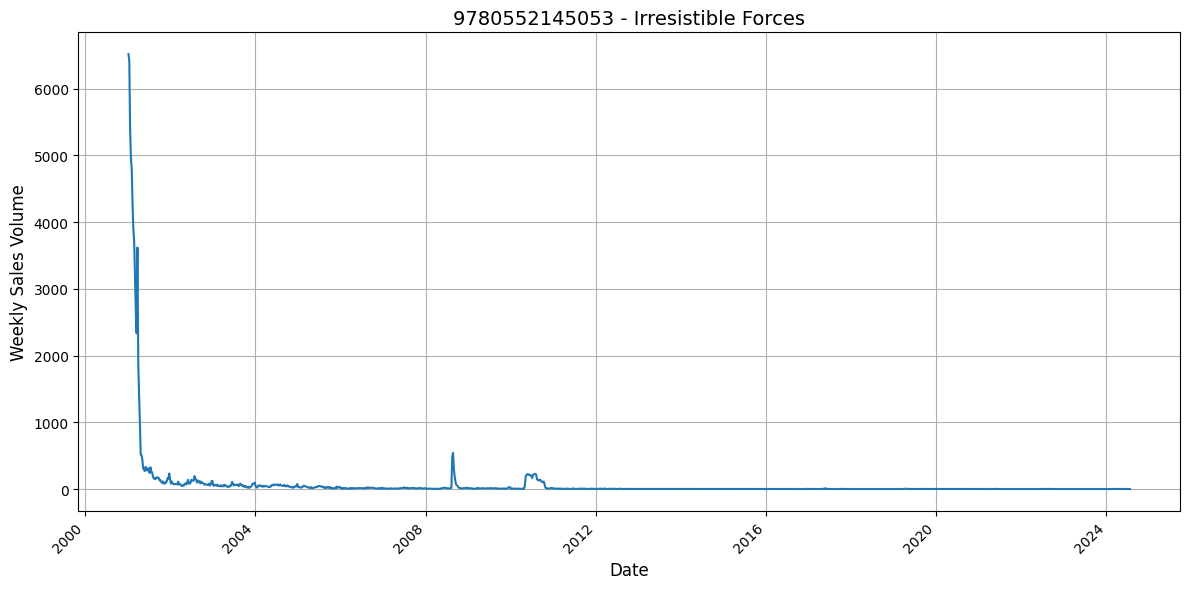

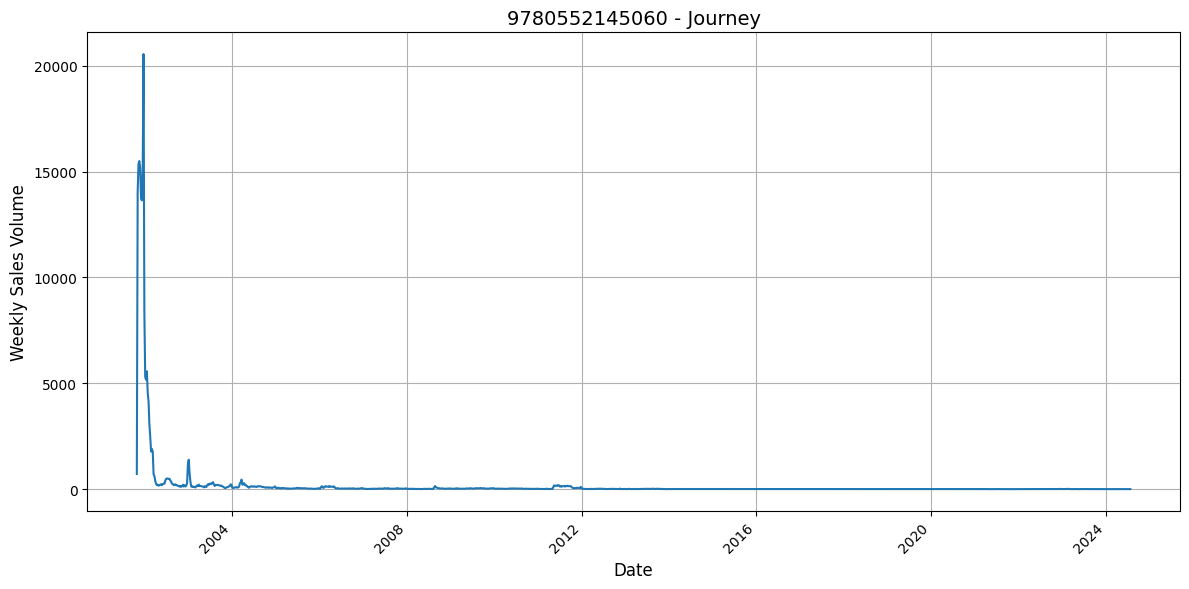

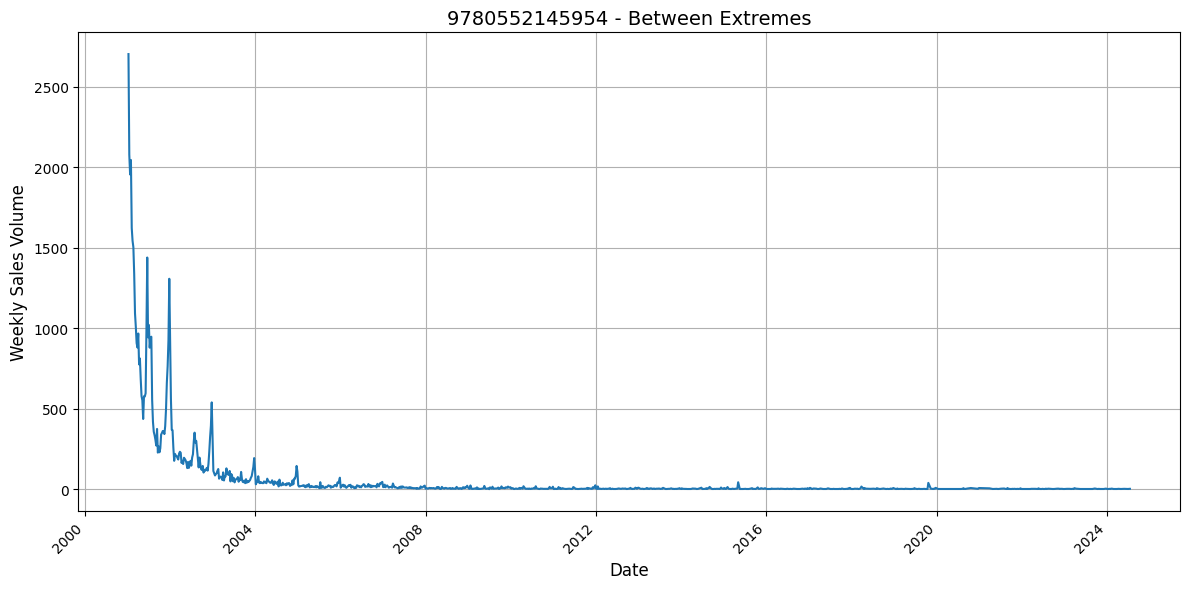

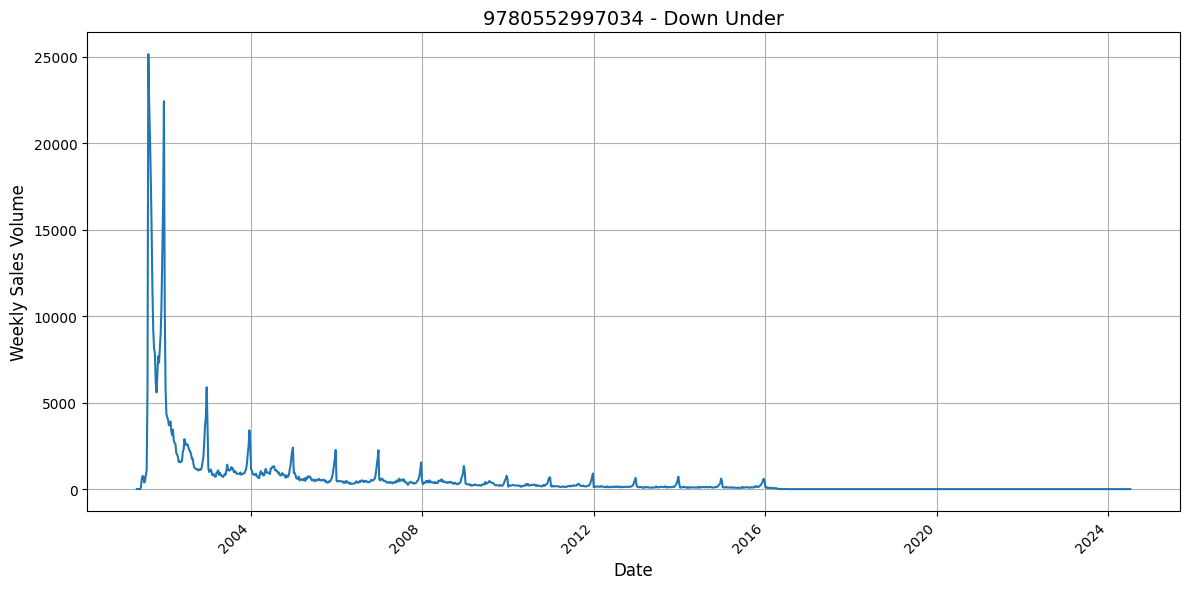

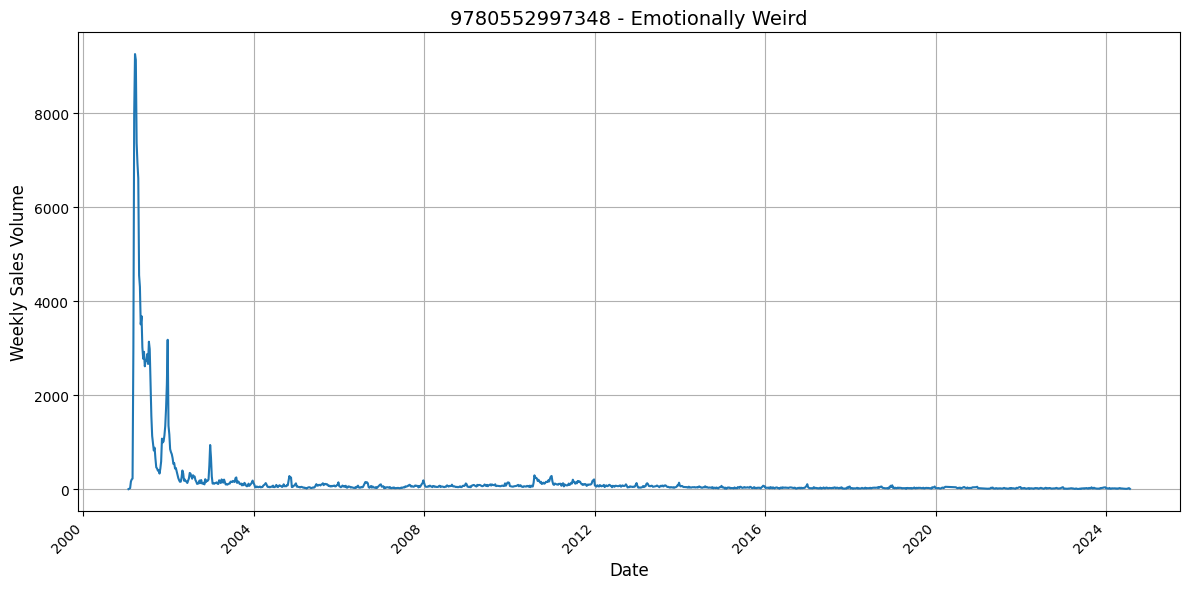

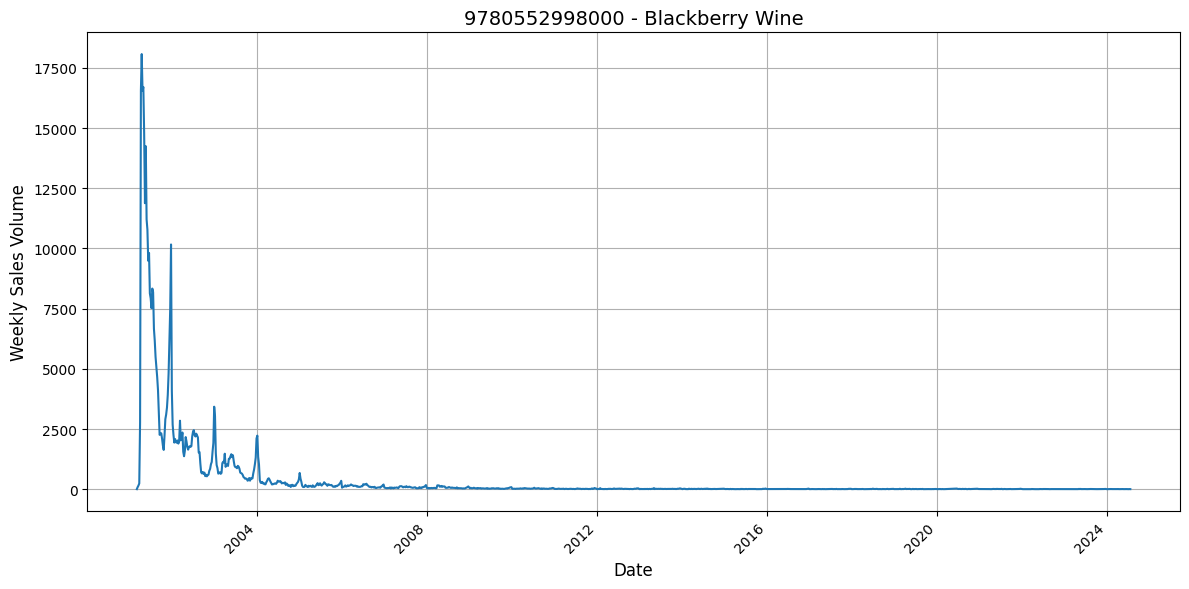

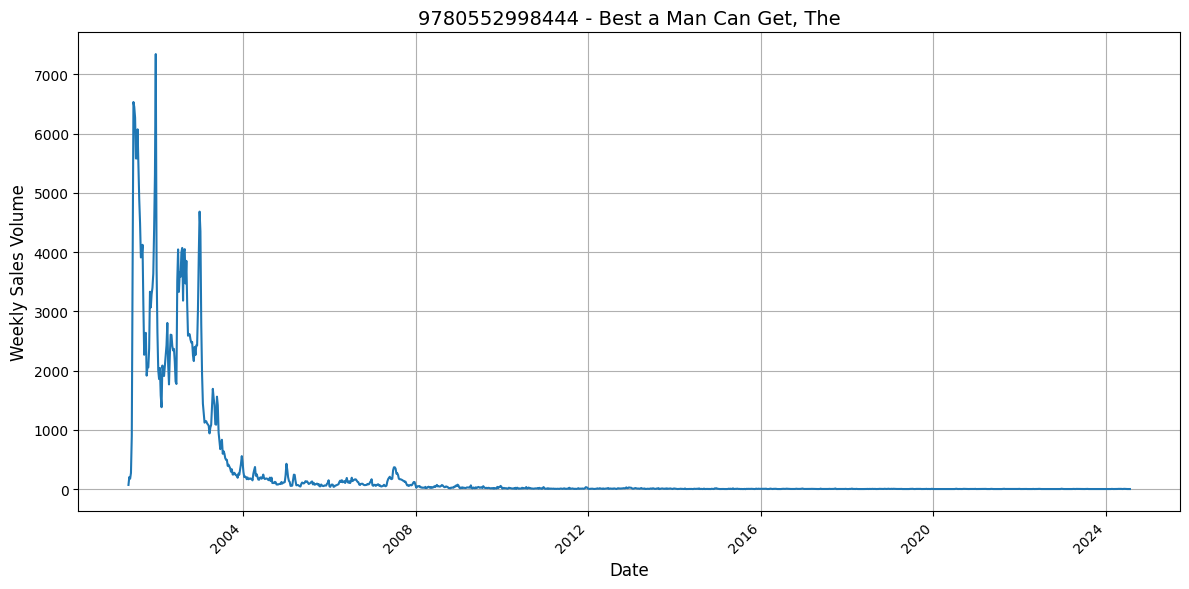

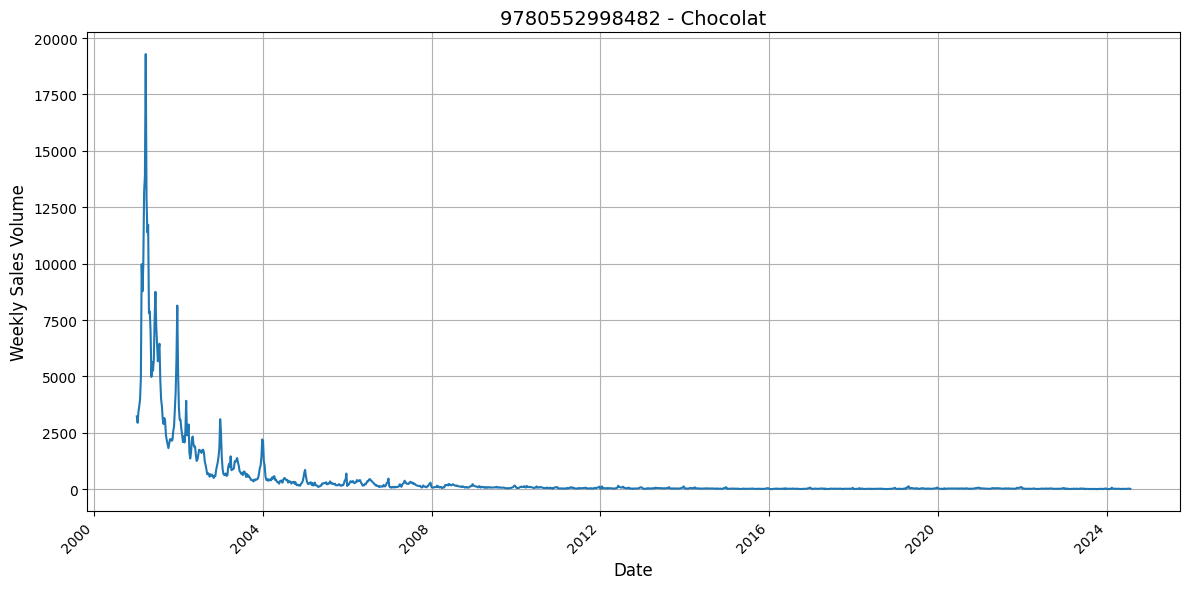

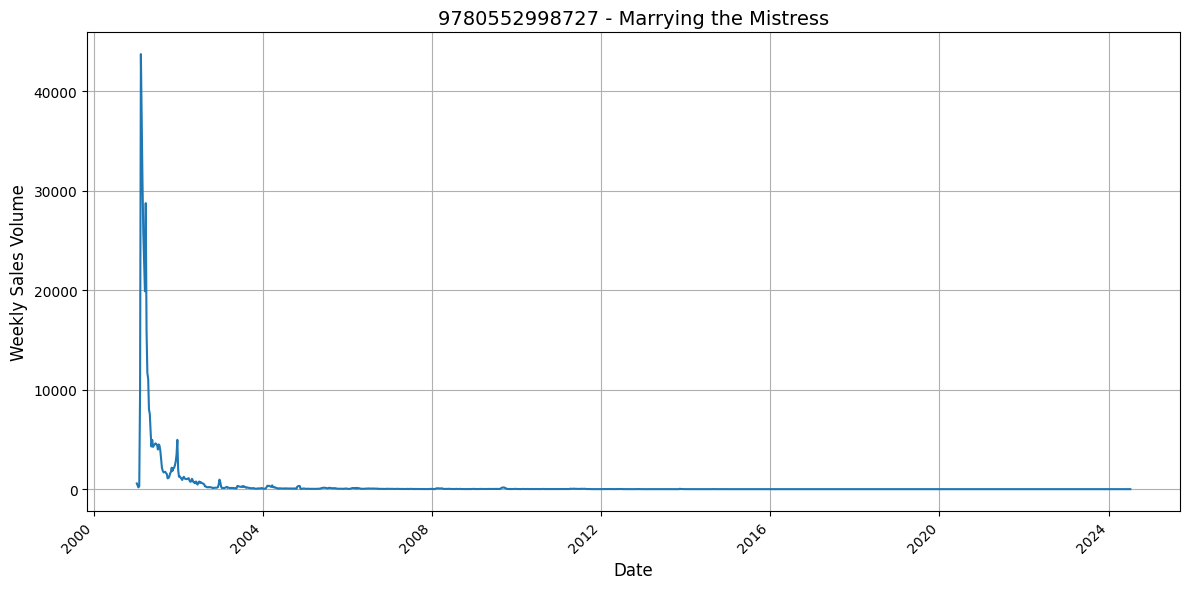

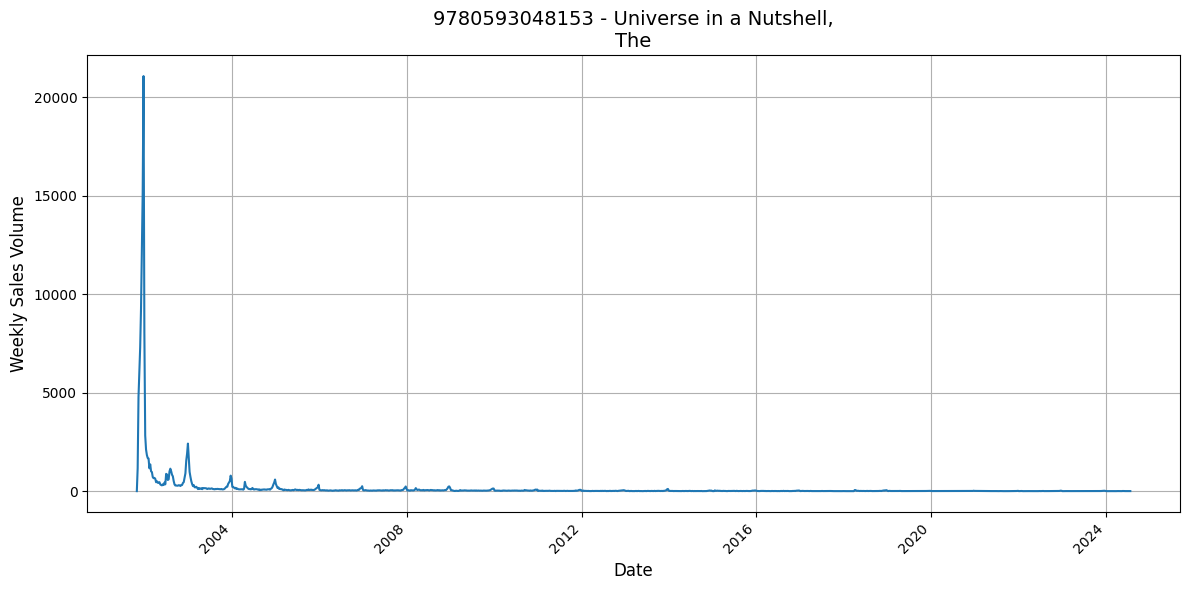

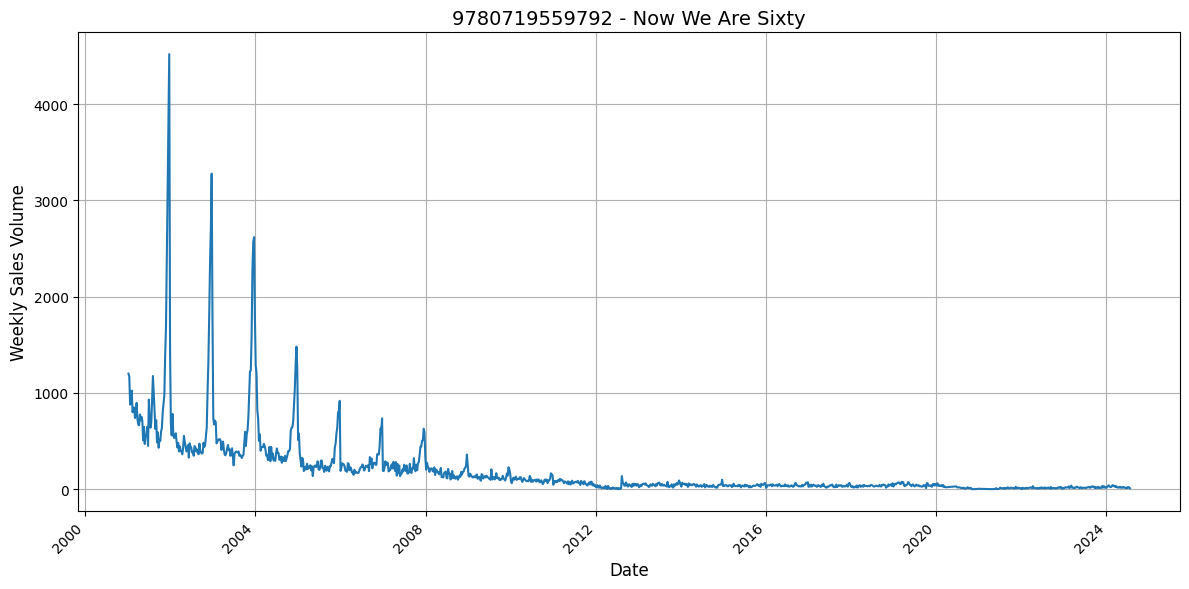

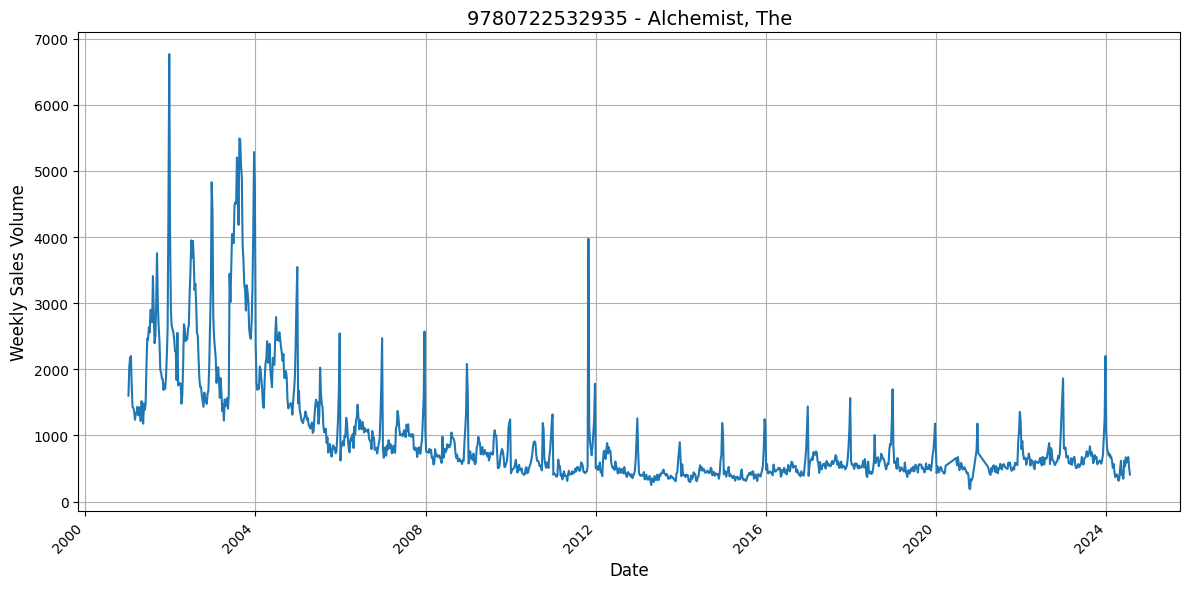

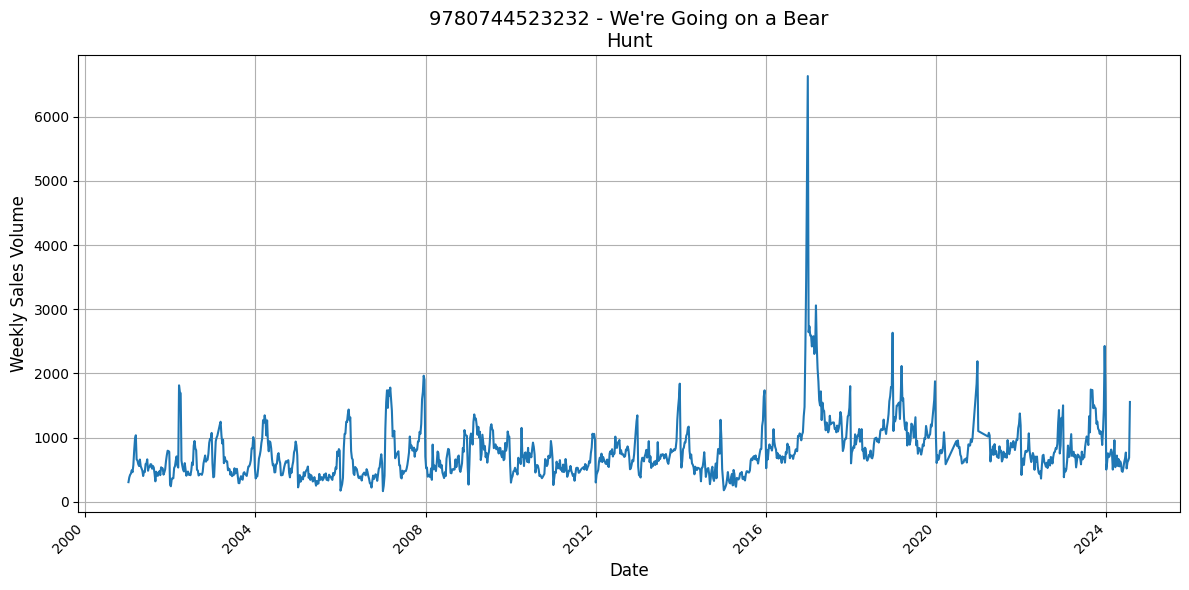

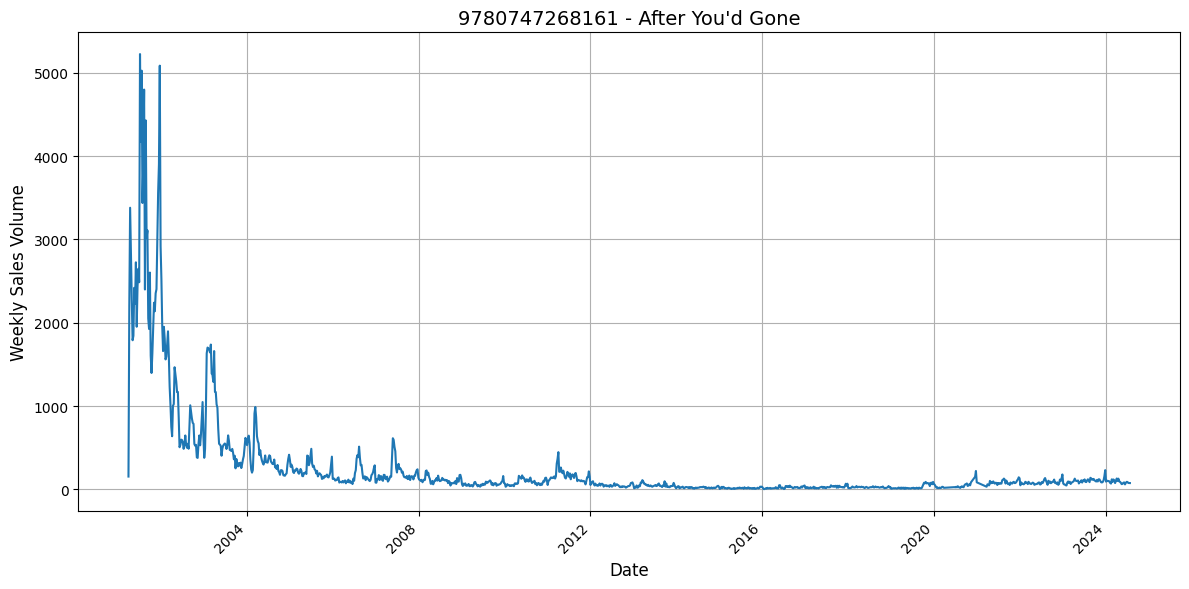

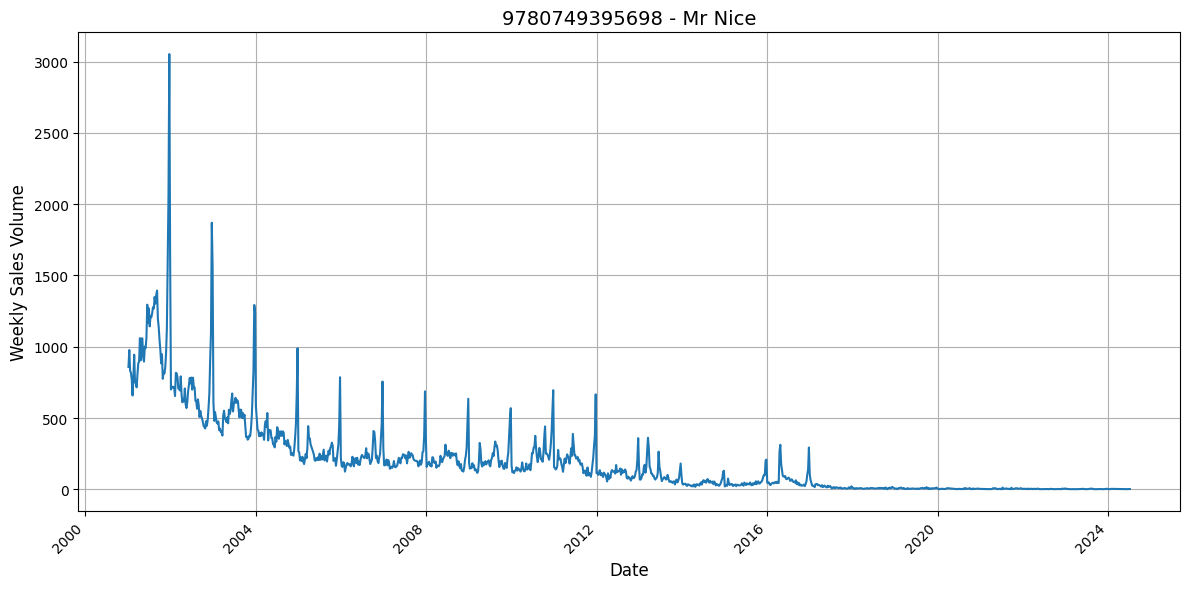

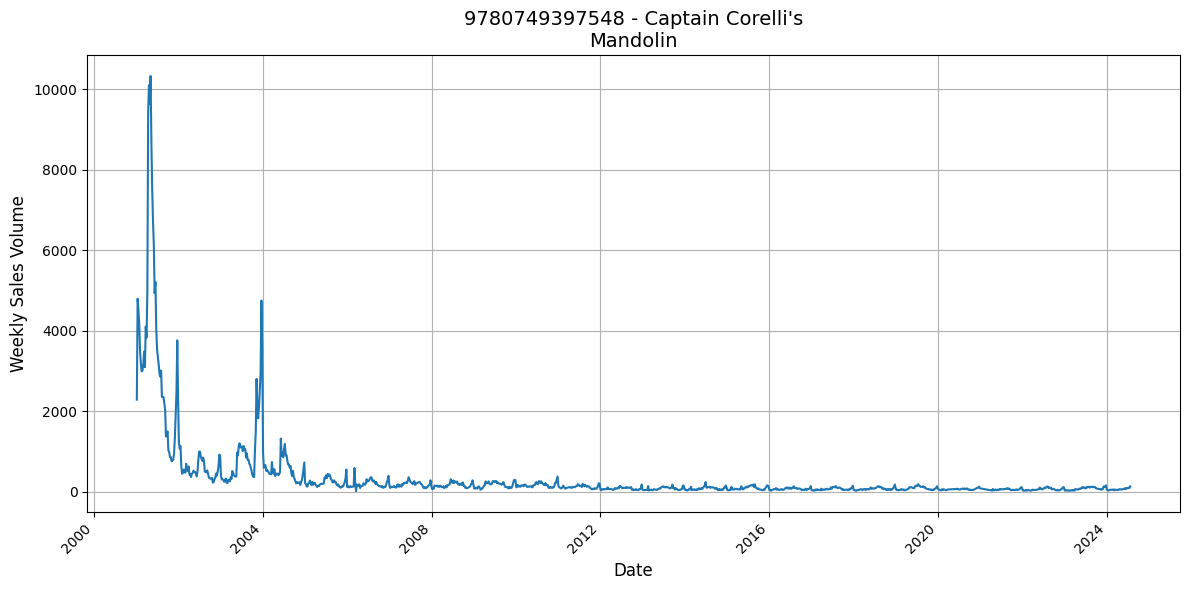

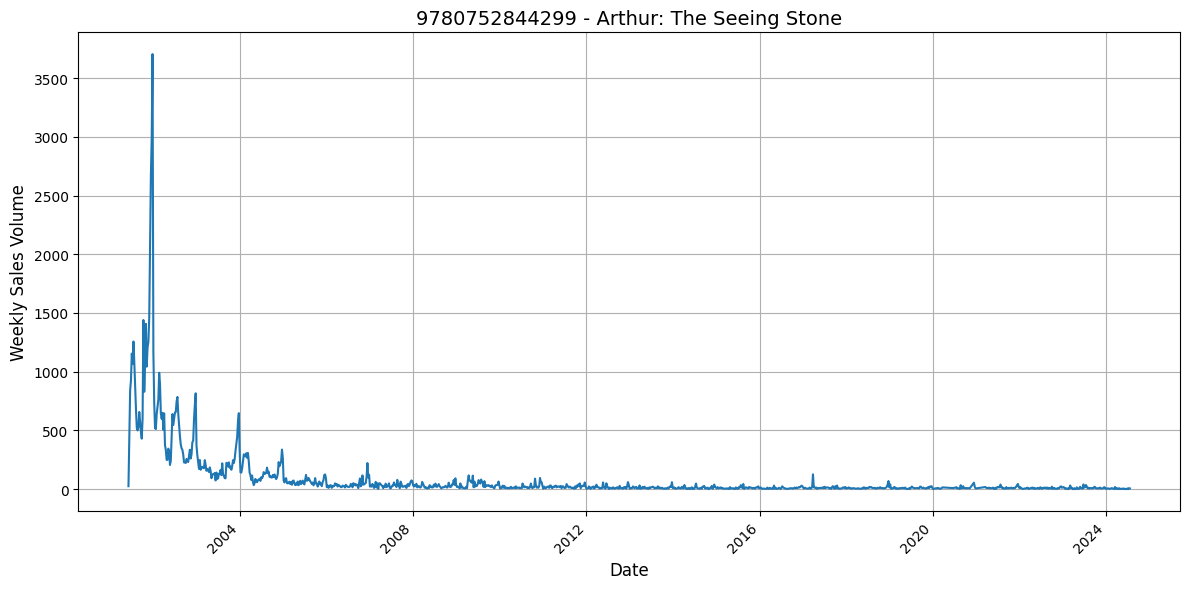

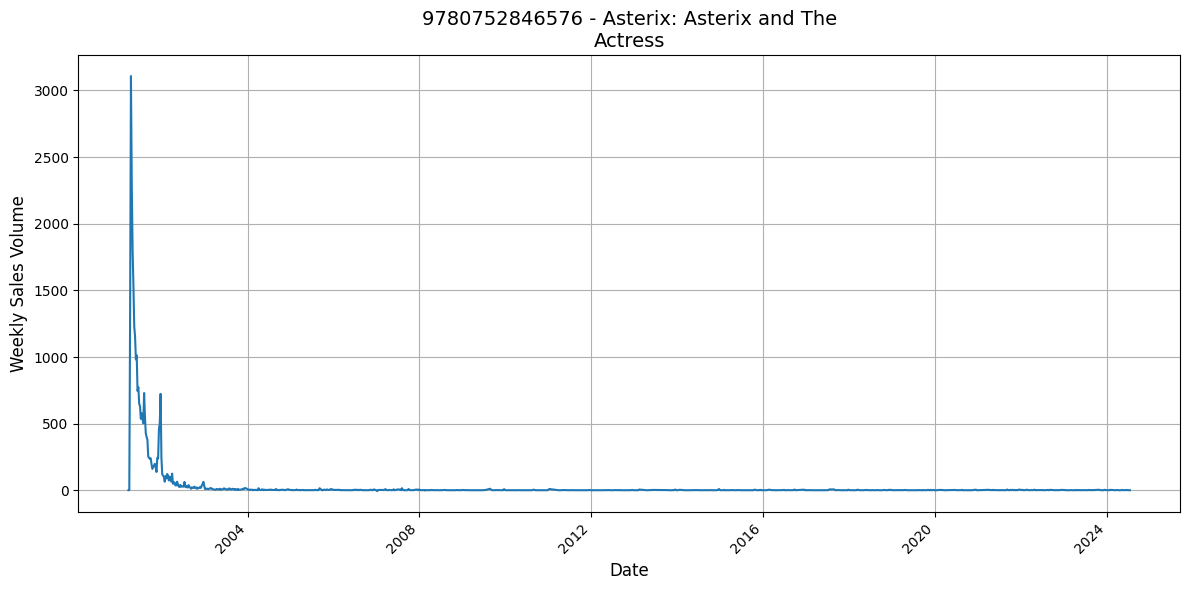

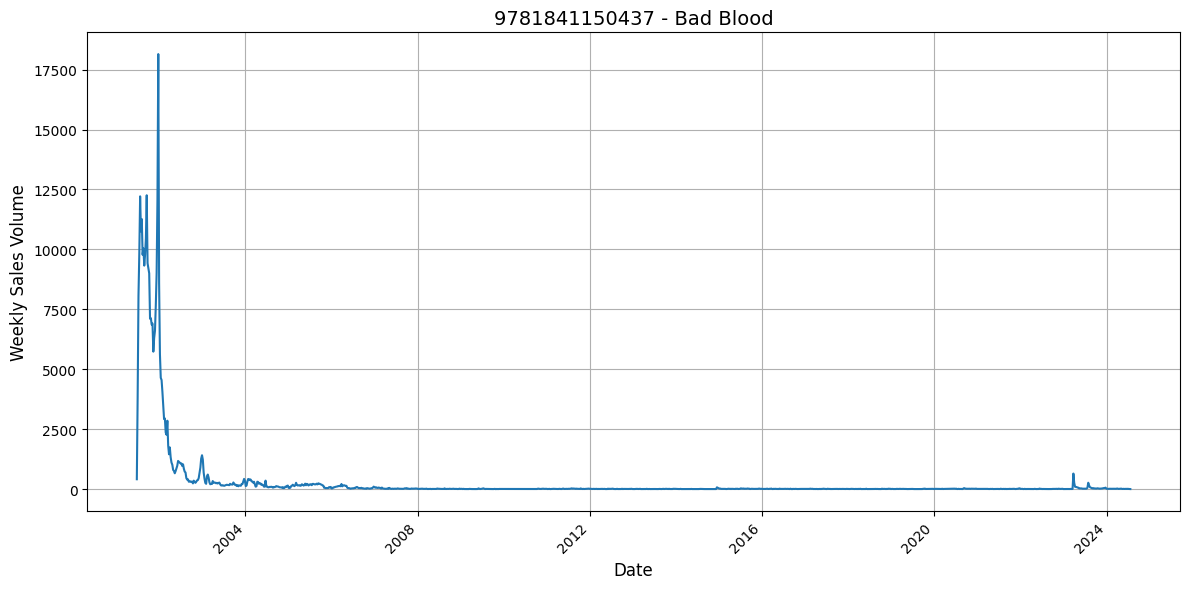

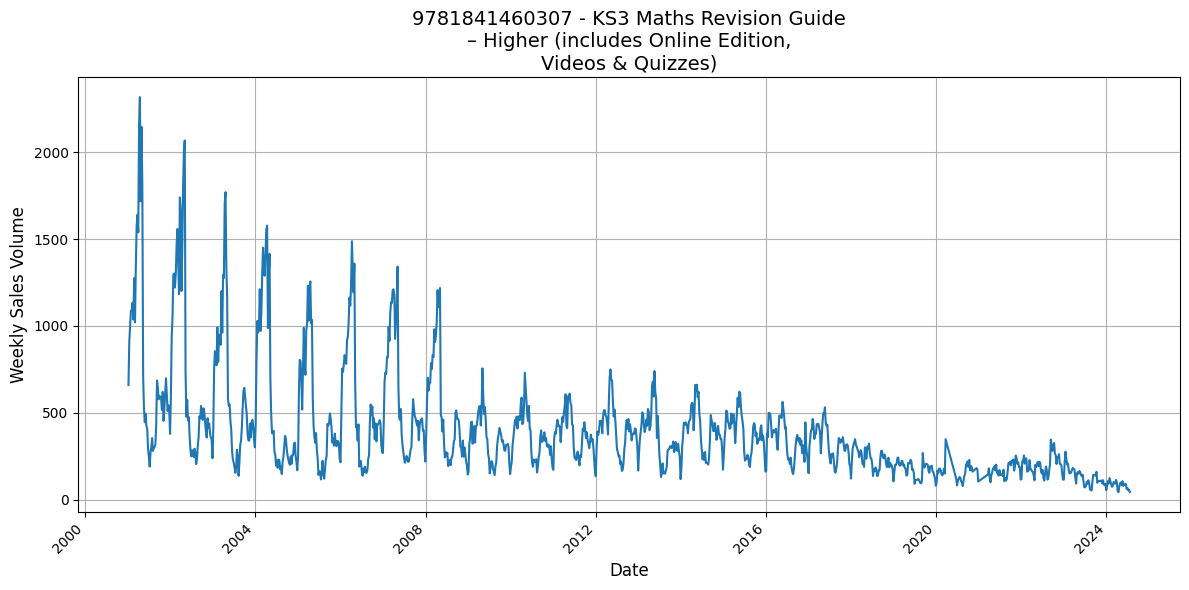

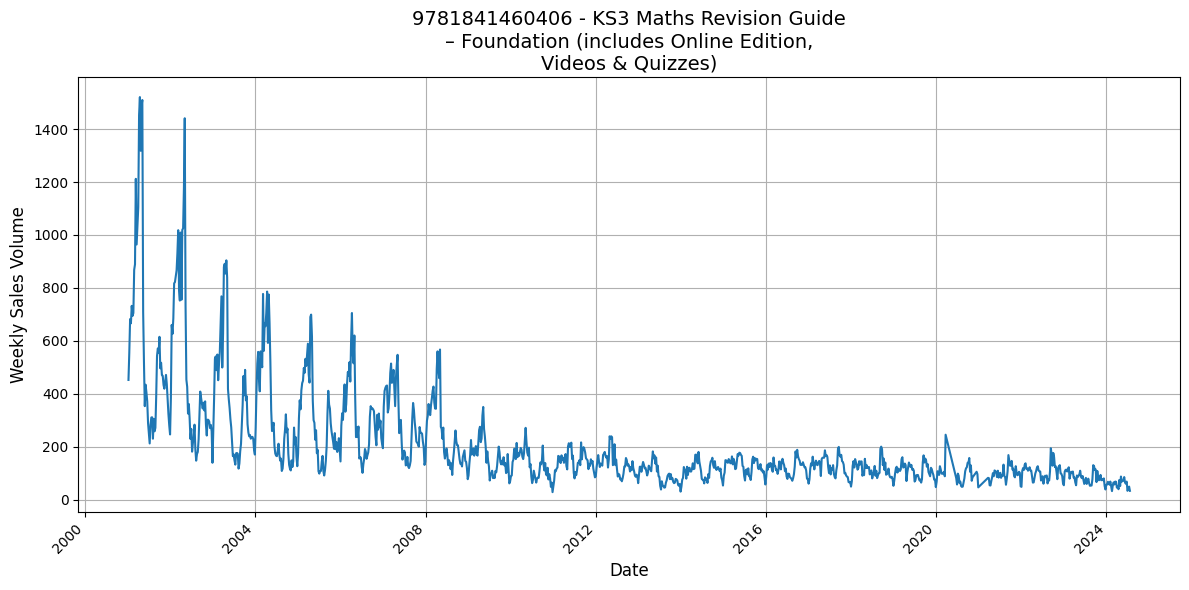

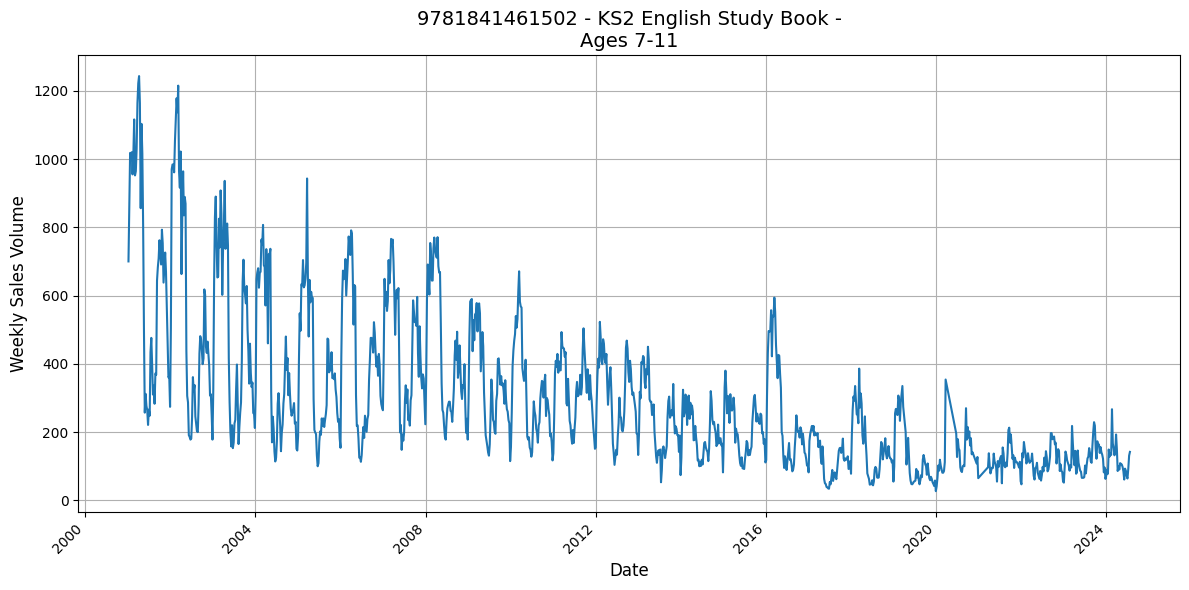

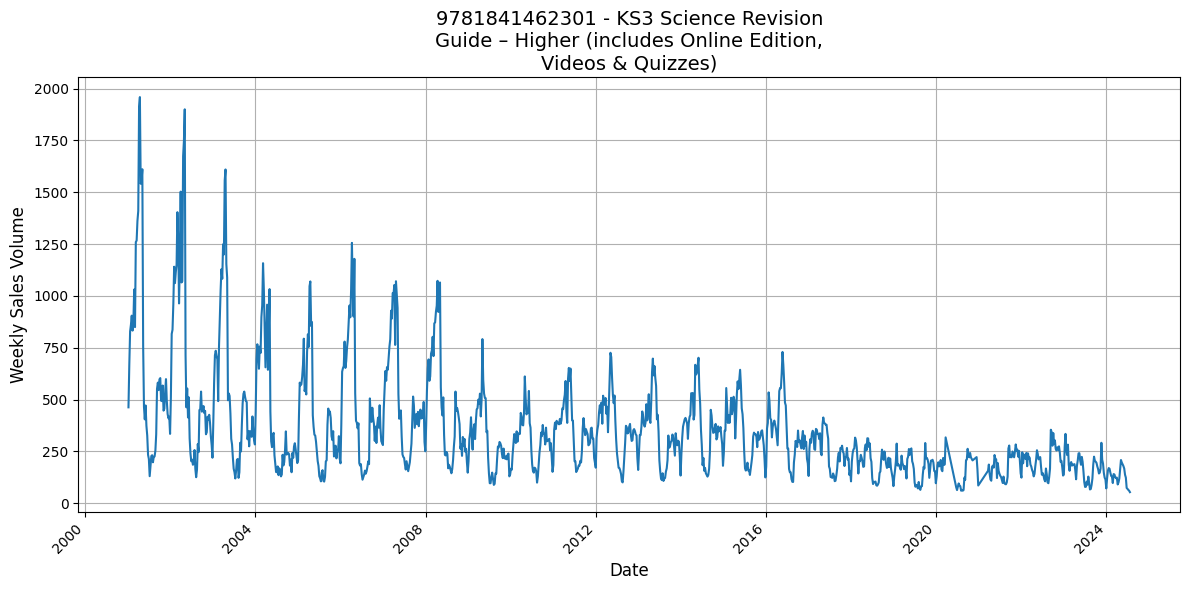

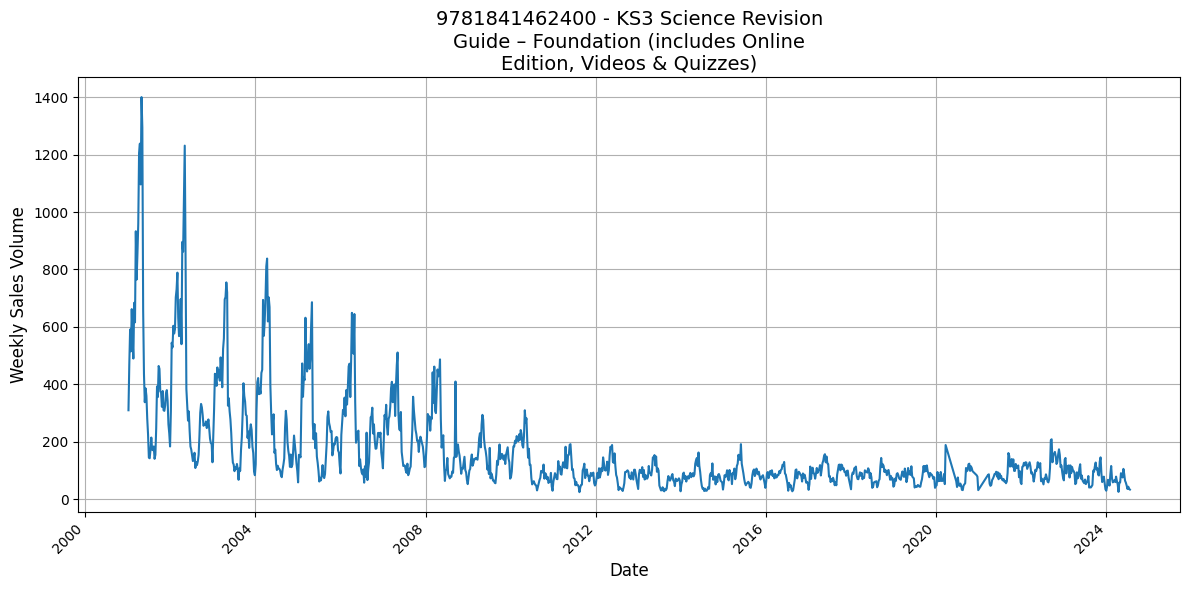

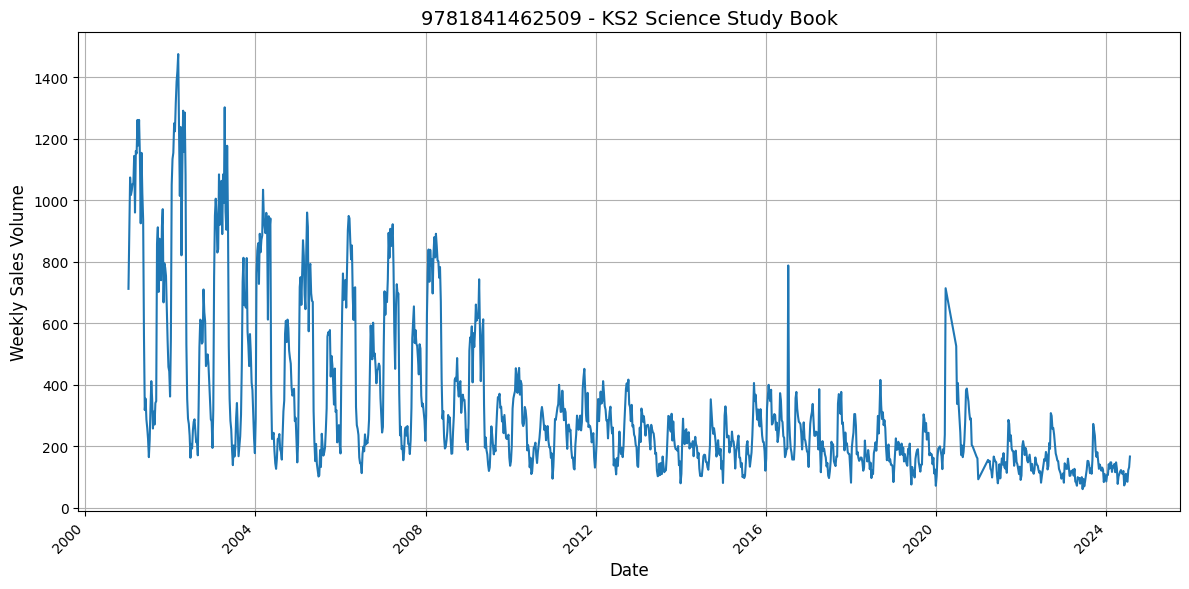

In [ ]:
# Plot the data of all ISBNs that meet the criterion
import textwrap

for isbn in valid_isbns:
    # Get the title from uk_weekly_df (using the first occurrence)
    title = uk_weekly_df[uk_weekly_df['ISBN'] == isbn]['Title'].iloc[0]

    # Create the label by combining ISBN and title directly
    label = f"{isbn} - {title}"
    title_wrapped = textwrap.wrap(label, width=40)

    # Filter data for the current ISBN from uk_weekly_df
    isbn_data = uk_weekly_df[uk_weekly_df['ISBN'] == isbn]

    plt.figure(figsize=(12, 6))
    plt.plot(isbn_data.index, isbn_data['Volume'])  # Remove label argument here
    plt.title('\n'.join(title_wrapped), fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Weekly Sales Volume', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    # plt.legend(loc='upper left', fontsize=10)  # Remove legend entirely
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()



---


**Sales Trends Overview**

For most books, sales appear to have peaked around 2002–2003, followed by a downward trend starting in 2004. Overall, global sales declined quite drastically thereafter. During the first 12 years (2001–2012), the trend was more volatile, the general decline continued after 2005. In the 12–24 year period (2012–2024), sales patterns flattened out with consistently low volumes compared to the peak years. This decline aligns with the broader trend in the book-selling business, where overall sales have been trending downward in recent years.

Notable exceptions to the general trend:

* **Who Moved My Cheese?**
Although it never achieved high sales volumes, this title maintained steady weekly sales. After 2012, despite a downward trend, its sales remained relatively stable through 2024.

* **The Very Hungry Caterpillar**
This book truly stands the test of time. Unlike most others, it didn’t peak around 2002–2003. Instead, sales gradually increased from 2001, peaked around 2010–2011, and then maintained a steady range of 1,000 to 4,000 weekly sales. As of 2024, it may be the best-selling book by volume, avoiding the sharp declines seen in the majority of titles.

* **The Alchemist**
Similar to The Very Hungry Caterpillar, this book had a strong sales track record over the years. However, unlike Caterpillar, its peak occurred between 2002 and 2004, followed by a downward trend. A smaller spike occurred around 2012, after which weekly sales stabilised, fluctuating around 1,000.

* **We’re Going on a Bear Hunt**
This title maintained a relatively flat sales line, typically below 2,000 weekly sales. Interestingly, there was a significant spike in 2017, reaching over 6,000 weekly sales, before returning to its prior pattern.


---





In [ ]:
# Define two book titles for further analysis
book_titles = ['Alchemist, The', 'Very Hungry Caterpillar, The']

# Filter data: Only for selected books and after 2012-01-01
filtered_df = uk_weekly_df[
    (uk_weekly_df['Title'].isin(book_titles)) &
    (uk_weekly_df.index > pd.to_datetime('2012-01-01'))
]

# Validate filtering results
print(f"Filtered Titles: {filtered_df['Title'].unique()}")
print(f"Date Range: {filtered_df.index.min()} to {filtered_df.index.max()}")

Filtered Titles: ['Very Hungry Caterpillar, The' 'Alchemist, The']
Date Range: 2012-01-08 00:00:00 to 2024-07-21 00:00:00


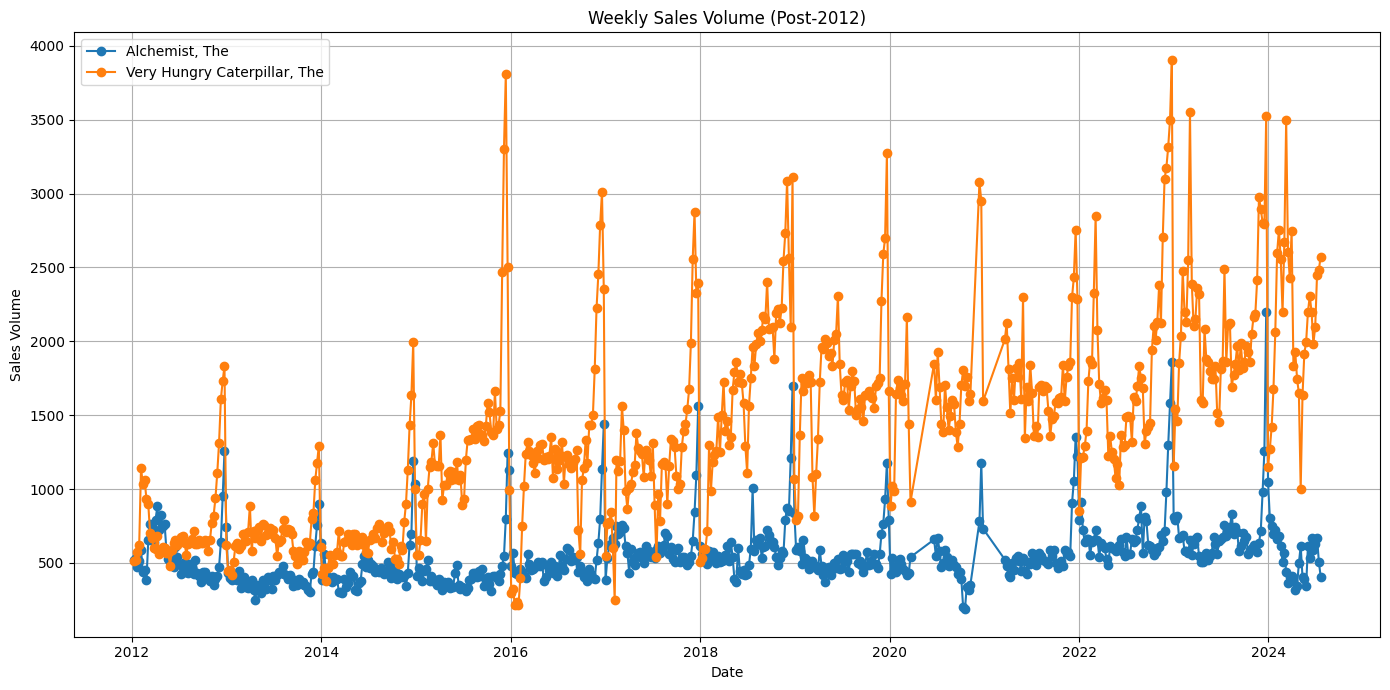

In [ ]:
# Plotting - both books sales weekly volumn from 2012
plt.figure(figsize=(14, 7))

for title in book_titles:
    # Get unique ISBNs for the current title
    isbns = filtered_df[filtered_df['Title'] == title]['ISBN'].unique()

    # Aggregate data for all ISBNs associated with the title
    book_data = filtered_df[filtered_df['ISBN'].isin(isbns)].groupby(level=0)['Volume'].sum()

    # Plot the aggregated data
    plt.plot(book_data.index, book_data.values, label=title, marker='o')

plt.title('Weekly Sales Volume (Post-2012)')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
vhc_isbns = filtered_df[filtered_df['Title'] == 'Very Hungry Caterpillar, The']['ISBN'].unique()
print(vhc_isbns)

['9780140500875' '9780241003008']




---


Note: The Very Hungry Caterpillar has two ISBNs. ISBN 9780140500875 doesn't record much sales after 2012, but both ISBNs will be kept for completeness.


---



# 3. Classical Techniques in Time Series Forecasting

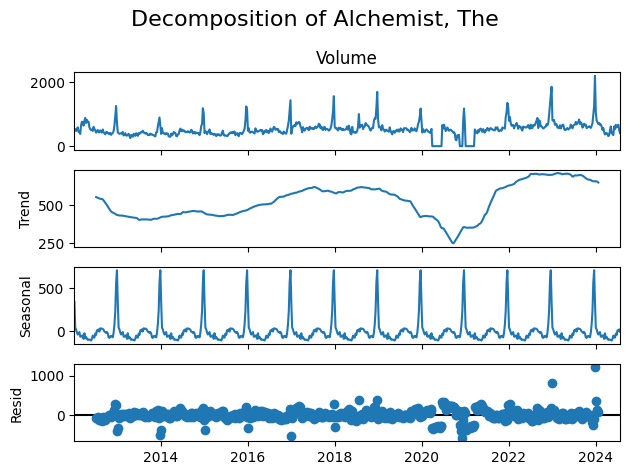

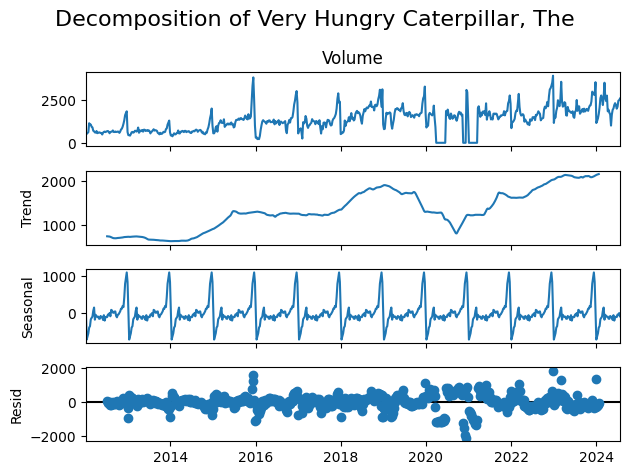

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposition to decide between additive or multiplicative by visually inspecting the data
for title in book_titles:
    book_data = filtered_df[filtered_df['Title'] == title].resample('W').sum()
    decomposition = seasonal_decompose(book_data['Volume'], model='additive', period=52)

    decomposition.plot()
    plt.suptitle(f'Decomposition of {title}', fontsize=16)
    plt.tight_layout()
    plt.show()

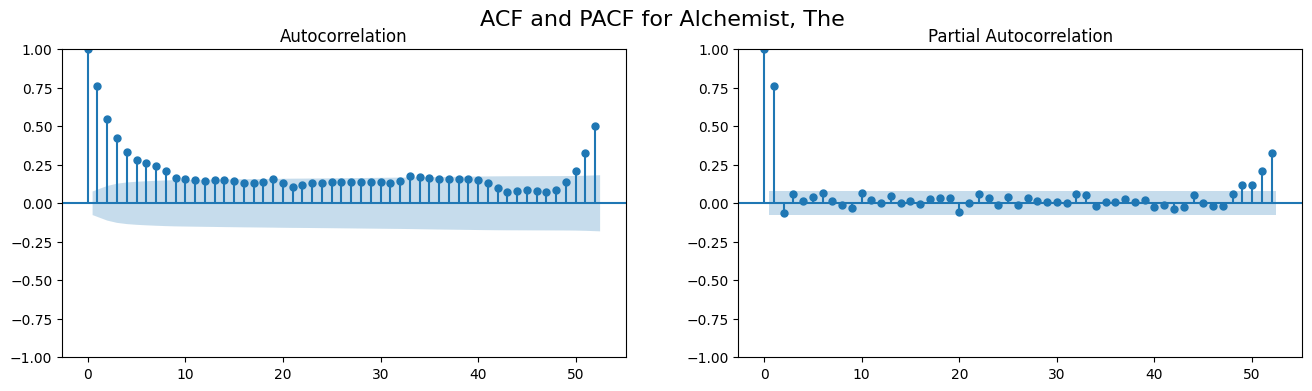

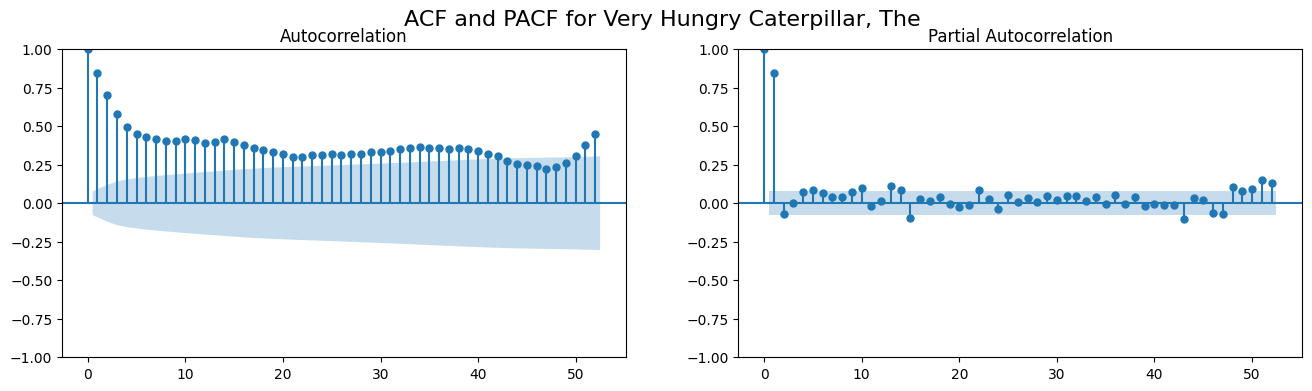

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Perform ACF and PACF on both books
for title in book_titles:
    book_data = filtered_df[filtered_df['Title'] == title].resample('W').sum()
    series = book_data['Volume']

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(series, lags=52, ax=axes[0])
    plot_pacf(series, lags=52, ax=axes[1])
    fig.suptitle(f'ACF and PACF for {title}', fontsize=16)
    plt.show()



---


A recurring seasonal pattern appears in both ACF and PACF plots for The Alchemist and The Very Hungry Caterpillar:

* Short-Term Momentum (Lags 1–4): Both books show strong autocorrelation in the first few weeks, possibly due to high early-year sales momentum—potentially linked to New Year resolutions, gift redemptions, or academic purchases.

* Seasonal Peaks (Lags 48–52): A clear autocorrelation spike at lags ~48–52 (roughly one year apart) suggests a seasonal pattern—likely driven by end-of-year gifting or holiday purchases. PACF plots show a smaller, corresponding bump, reinforcing the annual cycle.

* These patterns imply that sales of both titles may rise during early-year periods (Weeks 1–4) and again in late-year weeks (Weeks 48–52), consistent with gift-giving seasons and educational calendar cycles—particularly relevant for children's literature.


---



In [ ]:
# Use Augmented Dickey-Fuller test to check for stationarity.
from statsmodels.tsa.stattools import adfuller

for title in book_titles:
    series = filtered_df[filtered_df['Title'] == title].resample('W').sum()['Volume']
    result = adfuller(series.dropna())
    print(f"\nADF Test for {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")


ADF Test for Alchemist, The
ADF Statistic: -8.295945282786748
p-value: 4.139950997174928e-13

ADF Test for Very Hungry Caterpillar, The
ADF Statistic: -3.0605377538189953
p-value: 0.029614783911209044




---


**The Alchemist**: The very low p-value (much smaller than 0.05) indicates that we reject the null hypothesis of the ADF test. This means the time series is stationary.

**The Very Hungry Caterpillar**: The p-value is less than 0.05, so we also reject the null hypothesis of the ADF test. This means this time series is stationary, but it's closer to the threshold of non-stationarity compared to The Alchemist.


---




In [ ]:
import pmdarima as pm

# Auto ARIMA (Train/Test Split)
# Use data from 2012 up to 32 weeks before the end for training

forecast_horizon = 32  # Final 32 weeks for testing

for title in book_titles:
    print(f"\nProcessing Auto ARIMA for: {title}")

    # Filter and resample data
    full_series = filtered_df[filtered_df['Title'] == title].resample('W').sum()['Volume']

    # Handle missing data
    full_series = full_series.fillna(0)  # Fill missing values with 0

    # Ensure sufficient data exists for splitting
    if len(full_series) <= forecast_horizon:
        print(f"Not enough data for {title}. Skipping...")
        continue

    # Split into training and testing
    train_series = full_series[:-forecast_horizon]
    test_series = full_series[-forecast_horizon:]

    # Run Auto ARIMA
    model = pm.auto_arima(
        train_series,
        seasonal=True,
        m=52,  # Weekly seasonality
        d=None,  # Auto-detect differencing
        D=None,  # Auto-detect seasonal differencing
        start_p=0, start_q=0, max_p=3, max_q=3,  # Non-seasonal orders
        start_P=0, start_Q=0, max_P=2, max_Q=2,  # Seasonal orders
        stepwise=True,  # Use stepwise search for faster computation
        trace=True,  # Print progress
        error_action='ignore',  # Ignore fitting errors
        suppress_warnings=True  # Suppress warnings
    )

    # Print model summary
    print(f"\nBest model for {title}:\n{model.summary()}")

    # Forecast the test horizon
    forecast = model.predict(n_periods=forecast_horizon)

    # Compare forecast with actual test data
    test_series = test_series.values  # Convert to array for comparison


Processing Auto ARIMA for: Alchemist, The
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=7990.293, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=7838.866, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=7988.309, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=7990.623, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=7655.665, Time=4.15 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=7708.346, Time=2.47 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=7650.410, Time=52.66 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=7650.152, Time=27.26 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=16.67 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=inf, Time=30.88 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AIC=7632.786, Time=31.41 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=7685.867, Time=4.36 sec
 ARIMA(0,1,2)(2,0,1)[52] intercept   : AIC=7632.969, 



---


**The Alchemist**

The best model identified for "The Alchemist" is ARIMA(1,1,2)(2,0,0)[52]. It demonstrates a reasonable fit based on AIC and residual diagnostics. However, the residuals are not perfectly normal or homoskedastic, which could potentially impact forecast accuracy.

The relatively high AIC value of 7623.292 in this context suggests that the model may not be capturing the data patterns or making predictions as effectively as possible.


**The Very Hungry Caterpillar**

The best model identified for "The Very Hungry Caterpillar" is ARIMA(2,1,1)(1,0,2)[52]. The search process was computationally expensive due to the wide parameter ranges and the inclusion of seasonal components.

The model shows a reasonable fit based on AIC and residual diagnostics. However, the AIC value of 8978.177 is slightly higher than that of "The Alchemist." Similar to the previous model, residuals are not perfectly normal or homoskedastic, which could affect forecast accuracy.


---




In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# Create a dictionary to store the models
books_best_models = {}

# Define model parameters for each book based on the output
alchemist_params = (1, 1, 2), (2, 0, 0, 52)
caterpillar_params = (2, 1, 1), (1, 0, [1, 2], 52)

# Recreate the models using SARIMAX
books_best_models["Alchemist, The"] = SARIMAX(
    filtered_df[filtered_df['Title'] == "Alchemist, The"].resample('W').sum()['Volume'].fillna(0),
    order=alchemist_params[0],
    seasonal_order=alchemist_params[1]
).fit()

books_best_models["Very Hungry Caterpillar, The"] = SARIMAX(
    filtered_df[filtered_df['Title'] == "Very Hungry Caterpillar, The"].resample('W').sum()['Volume'].fillna(0),
    order=caterpillar_params[0],
    seasonal_order=caterpillar_params[1]
).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Residual Analysis for: Alchemist, The



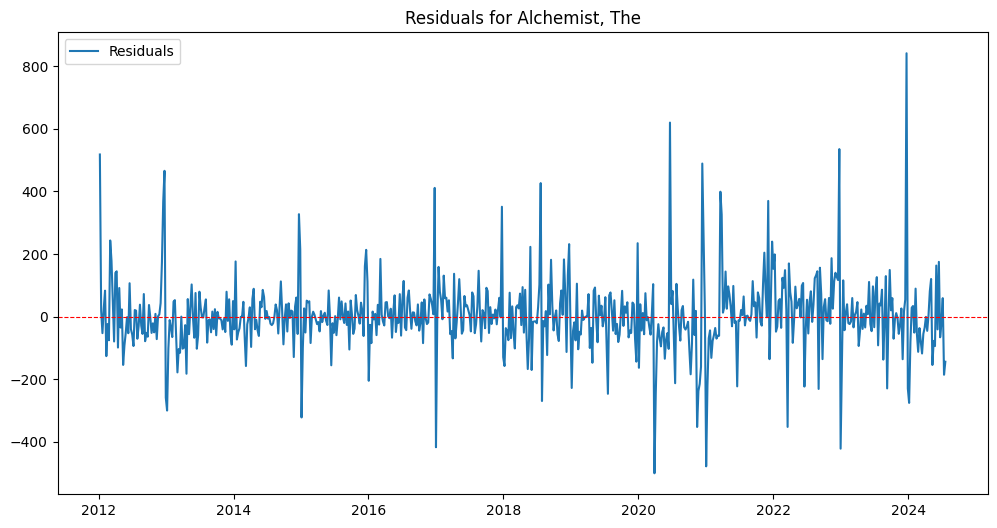

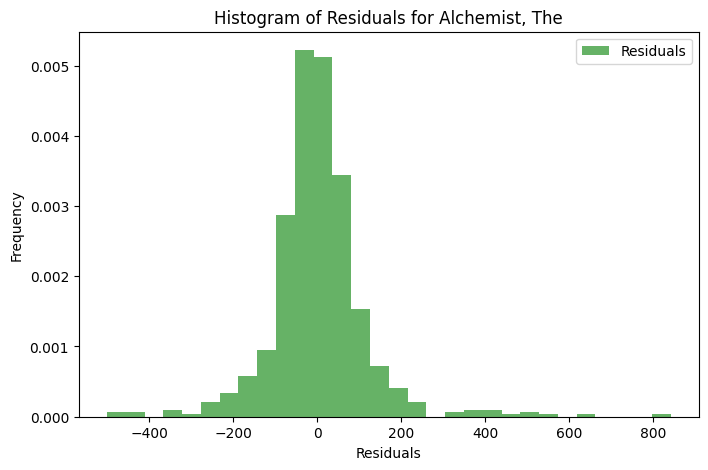

Ljung-Box Test (p-value): 0.05989698015140985
Residuals are likely independent (no significant autocorrelation).
Jarque-Bera Test (p-value): 0.0
Residuals deviate from normality.

Residual Analysis for: Very Hungry Caterpillar, The



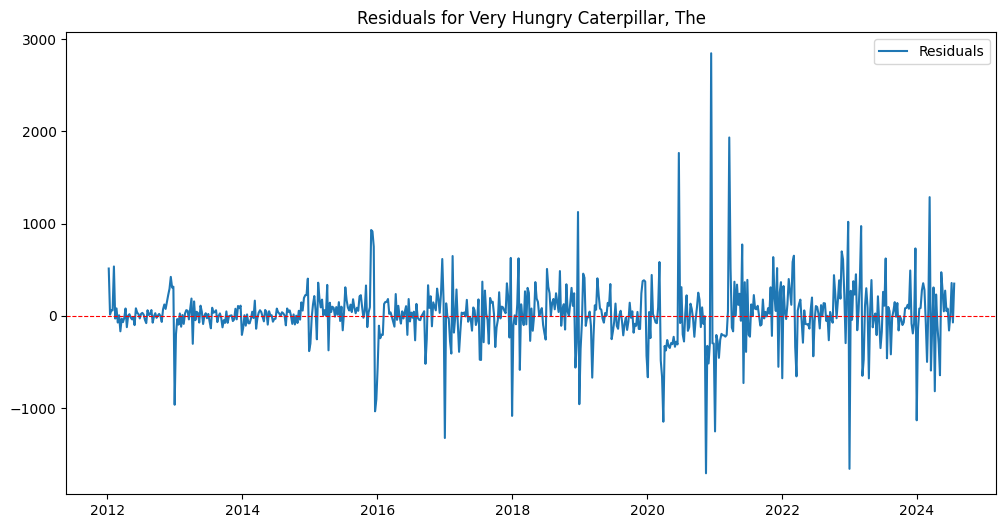

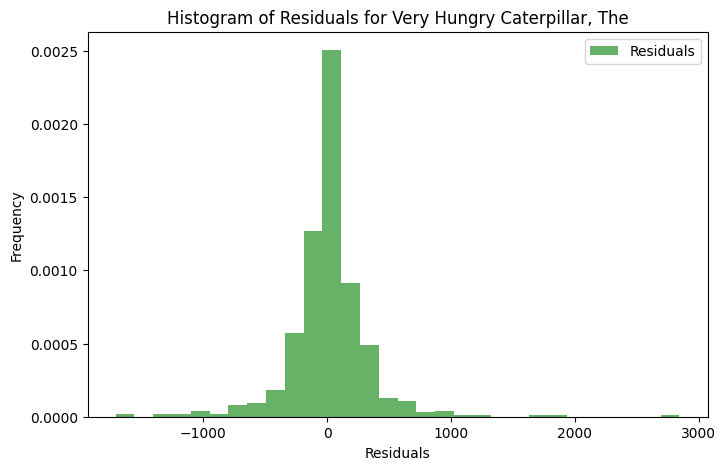

Ljung-Box Test (p-value): 0.4913652440665184
Residuals are likely independent (no significant autocorrelation).
Jarque-Bera Test (p-value): 0.0
Residuals deviate from normality.


In [ ]:
# Residual Analysis for the best model of each book
for book, model in books_best_models.items():
    print(f"\nResidual Analysis for: {book}\n")

    # Extract residuals
    residuals = model.resid

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Residuals")
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.8)
    plt.title(f"Residuals for {book}")
    plt.legend()
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g', label='Residuals')
    plt.title(f"Histogram of Residuals for {book}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Perform statistical tests
    # Ljung-Box Test for autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(f"Ljung-Box Test (p-value): {lb_test['lb_pvalue'].iloc[0]}")
    if lb_test['lb_pvalue'].iloc[0] > 0.05:
        print("Residuals are likely independent (no significant autocorrelation).")
    else:
        print("Residuals show significant autocorrelation.")

    # Jarque-Bera Test for normality
    jb_stat, jb_pvalue = stats.jarque_bera(residuals)
    print(f"Jarque-Bera Test (p-value): {jb_pvalue}")
    if jb_pvalue > 0.05:
        print("Residuals are likely normally distributed.")
    else:
        print("Residuals deviate from normality.")

**The Alchemist**

* The residuals are the differences between the actual observed values and the values predicted by the model.
These are plotted on the y-axis, ranging approximately from -400 to +800.

* The residuals fluctuate around the zero line, with no obvious trend or seasonality, which is a desirable property for model performance.
However, there are occasional large spikes (outliers) in both the positive and negative directions, particularly in recent years (e.g., 2023 and 2024).

* The spread of residuals appears fairly consistent over time, though the spikes might indicate episodes of higher variance in certain periods.

* The residuals do not show systematic patterns, suggesting that the model captures the time series structure well. Most residuals hover around the zero line, which is a good sign for model accuracy.

* Outliers: A few large spikes are present, which may indicate specific data anomalies or events not accounted for by the model.


* Ljung-Box Test (p-value: 0.0599). The p-value is greater than 0.05, indicating that the residuals are likely independent and do not exhibit significant autocorrelation.
This is a good sign, as it suggests the model captures the time series dependency structure effectively.

* Jarque-Bera Test (p-value: 0.0). The p-value is less than 0.05, indicating that the residuals deviate from normality. This could be a concern, as normality of residuals is often desirable for statistical inference and forecasting.

* The histogram is centered around 0, with the highest frequency of residuals occurring close to 0.
The distribution is approximately bell-shaped but slightly skewed to the right, with some larger positive residuals.



---


**The Very Hungry Caterpillar**

* The residuals fluctuate around the zero line, with no consistent trend or seasonality, which is a desirable property for a well-fitted model.

* However, there are noticeable large spikes (outliers) in the residuals, particularly between 2018 and 2024, with extreme values reaching up to +3,000 and down to -1,000.


* The spread of residuals appears to increase slightly over time, suggesting that the variance may not be constant (heteroscedasticity). The large positive spikes are particularly noteworthy. It shows a huge spike in 2021, where the residual value reaches approximately +3000.

* The residuals do not show systematic patterns, indicating that the model captures most of the time series structure effectively.

* Outliers: There are several extreme residuals, especially in recent years, which may indicate anomalies in the data or periods where the model struggled to predict accurately.

* The residuals generally hover around the zero line, which is a positive indicator for the model's accuracy.


* The histogram is centered around 0, with the highest frequency of residuals occurring close to 0.
The distribution appears roughly bell-shaped but shows a noticeable positive skew, with a few large residuals extending up to +3,000.

* Most residuals are concentrated within the range of -1,000 to +1,000, with a steep peak near zero.
There are outliers, particularly on the positive side, with residuals as high as +3,000, indicating significant underprediction by the model in some cases.

* While the residuals are roughly centered around zero, the distribution deviates from perfect normality due to skewness and the presence of outliers.



* Ljung-Box Test (p-value: 0.4914). The p-value is much greater than 0.05, indicating that the residuals are independent and do not exhibit significant autocorrelation.
Like the Alchemist model, this is favorable.

* Jarque-Bera Test (p-value: 0.0). The p-value is less than 0.05, indicating that the residuals deviate from normality.
As with the Alchemist model, this could be an issue if the lack of normality impacts the model's predictive accuracy or interpretation.


---





Forecasting for: Alchemist, The



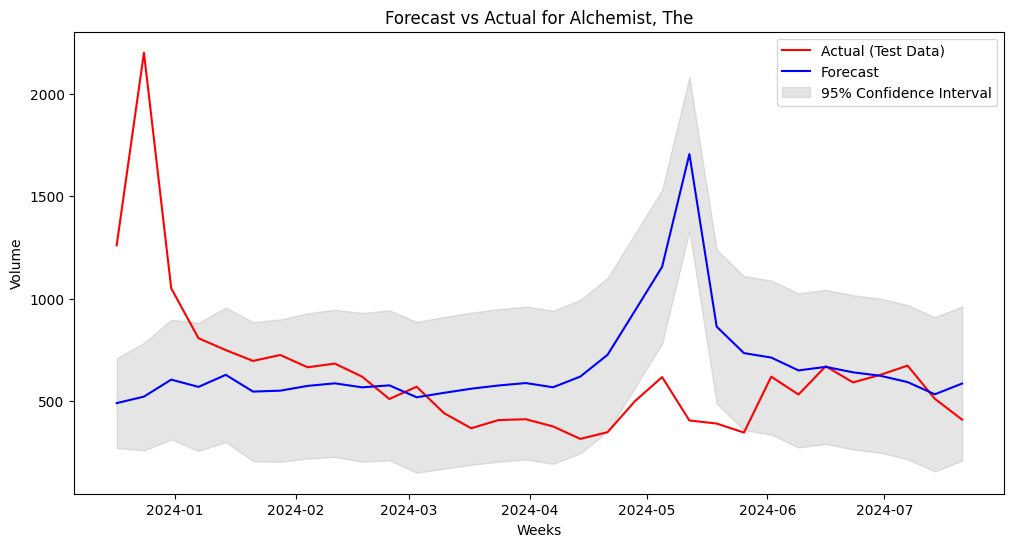

Mean Absolute Error (MAE): 285.67
Mean Absolute Percentage Error (MAPE): 49.56%

Forecasting for: Very Hungry Caterpillar, The



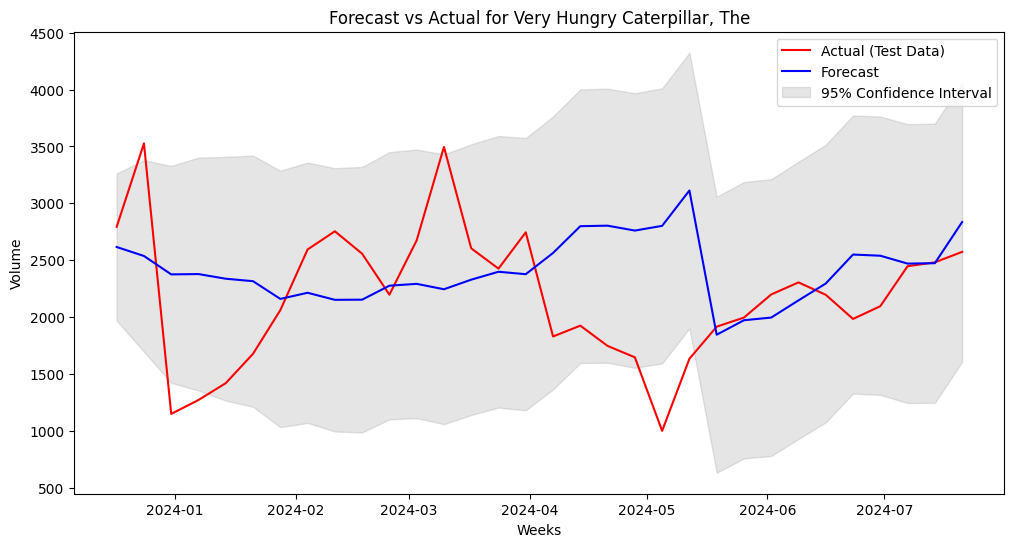

Mean Absolute Error (MAE): 557.20
Mean Absolute Percentage Error (MAPE): 32.38%


In [ ]:
# Forecast the Final 32 Weeks
# Define the forecast horizon
forecast_horizon = 32

# Placeholder for storing test series
test_series_alchemist = filtered_df[filtered_df['Title'] == "Alchemist, The"].resample('W').sum()['Volume'].fillna(0)[-forecast_horizon:]
test_series_caterpillar = filtered_df[filtered_df['Title'] == "Very Hungry Caterpillar, The"].resample('W').sum()['Volume'].fillna(0)[-forecast_horizon:]

# Forecast and plot predictions for each book
for book, model in books_best_models.items():
    print(f"\nForecasting for: {book}\n")

    # Get forecast and confidence intervals
    forecast_obj = model.get_forecast(steps=forecast_horizon)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    # Retrieve the actual test series
    test_series = test_series_alchemist if book == "Alchemist, The" else test_series_caterpillar

    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_series.index, test_series.values, label="Actual (Test Data)", color='red')
    plt.plot(test_series.index, forecast.values, label="Forecast", color='blue')
    plt.fill_between(test_series.index,
                     conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                     color='gray', alpha=0.2, label="95% Confidence Interval")
    plt.title(f"Forecast vs Actual for {book}")
    plt.xlabel("Weeks")
    plt.ylabel("Volume")
    plt.legend()
    plt.show()

    # Evaluate performance
    mae = np.mean(np.abs(test_series.values - forecast.values))
    mape = np.mean(np.abs((test_series.values - forecast.values) / test_series.values)) * 100
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

**The Alchemist**

* The model's performance is reasonable during stable periods, but it struggles with extreme variations (spikes in demand or volume).

* The forecast underestimates the actual values in January 2024, likely due to the model not fully capturing the dynamics of that period (e.g., trends, seasonality, or external factors).

* The forecast  overestimates the magnitude of the peak during April–May 2024. This indicates that the model captures the general trend but struggles with precise magnitude prediction during volatile periods.

* The confidence intervals are reasonably wide, reflecting the model's uncertainty. Most actual values fall within this range, which is a positive outcome.

* Mean Absolute Error (MAE): 285.67. This indicates that, on average, the forecasted values deviate from the actual values by approximately 286 units.

* Mean Absolute Percentage Error (MAPE): 49.56% This shows that the forecasted values, on average, are off by nearly half (50%) of the actual values, indicating poor prediction accuracy.

* Given the high MAPE, this model demonstrates limited reliability for accurate prediction. While it performs reasonably well during stable periods, its inability to handle extreme variations and the significant percentage error suggest it is not a suitable model for precise forecasting.





---


**The Very Hungry Caterpillar**

* The model struggles to capture sharp peaks and troughs in the actual data, especially during January 2024 (steep drop) and March 2024 (sharp peak).
This suggests the model may not adequately represent non-linear patterns or abrupt changes in volume.

* Despite the deviations, the forecast captures the general trend of the data reasonably well, particularly in the  later weeks (June-July 2024).

* The wide confidence intervals reflect the model's inability to predict extreme variations accurately.
However, most actual values fall within the  95% confidence intervals, indicating the model's uncertainty estimation is reasonable.

* Mean Absolute Error (MAE): 557.20. On average, the forecasted values deviate from the actual values by approximately 557 units.

* Mean Absolute Percentage Error (MAPE): 32.38%
The forecasted values are off by about 32.4% relative to the actual values, indicating moderate prediction accuracy.

* The error metrics indicate that the model's performance is suboptimal. It struggles with capturing sharp variations in the data, and its relatively high MAPE suggests that it is not a robust model for forecasting. While it performs reasonably well for capturing general trends, its inability to predict sudden changes limits its utility for precise forecasting.


---



# 4. Machine Learning and Deep Learning - Prepare  data to feed into the ML Models


In [ ]:
from sklearn.model_selection import train_test_split

#Prepare the data to feed into the machine learning models.
alchemist_data = filtered_df[filtered_df['Title'] == "Alchemist, The"].resample('W').sum()['Volume']
caterpillar_data = filtered_df[filtered_df['Title'] == "Very Hungry Caterpillar, The"].resample('W').sum()['Volume']

# Define the forecast horizon
forecast_horizon = 32
training_start_date = "2012-01-01"

def prepare_data(data, training_start_date, forecast_horizon):
    # Create lag features and rolling averages
    df = pd.DataFrame(data)
    df['Lag_1'] = df['Volume'].shift(1)
    df['Lag_2'] = df['Volume'].shift(2)
    df['Lag_3'] = df['Volume'].shift(3)
    df['Rolling_Mean_3'] = df['Volume'].rolling(window=3).mean()
    df['Rolling_Mean_5'] = df['Volume'].rolling(window=5).mean()

    # Drop rows with NaN values created by lag/rolling features
    df = df.dropna()

    # Determine training and test split indices
    training_end_idx = len(df) - forecast_horizon
    training_data = df.loc[training_start_date:df.index[training_end_idx - 1]]
    test_data = df.iloc[training_end_idx:]

    # Separate features (X) and target (y)
    X_train, y_train = training_data.drop(columns=['Volume']), training_data['Volume']
    X_test, y_test = test_data.drop(columns=['Volume']), test_data['Volume']

    return X_train, y_train, X_test, y_test

# Prepare data for each book
X_train_alchemist, y_train_alchemist, X_test_alchemist, y_test_alchemist = prepare_data(alchemist_data, training_start_date, forecast_horizon)
X_train_caterpillar, y_train_caterpillar, X_test_caterpillar, y_test_caterpillar = prepare_data(caterpillar_data, training_start_date, forecast_horizon)

# 4.1 XGBoost Model

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


def train_xgboost(X_train, y_train, X_test, y_test, book_name): # Include book_name here
    # Define the model
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }

    # Perform cross-validation
    # TimeSeriesSplit for cross-validation (correct approach for time series data to preserve  temporal order (training only on past data to predict future data)
    tscv = TimeSeriesSplit(n_splits=5)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Forecast
    y_pred = best_model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    display(f"XGBoost Results for {book_name}:") # Use book_name in print statement
    display(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")

    return best_model, y_pred

# Train and evaluate for each book
xgb_model_alchemist, y_pred_alchemist = train_xgboost(X_train_alchemist, y_train_alchemist, X_test_alchemist, y_test_alchemist, book_name="The Alchemist")
xgb_model_caterpillar, y_pred_caterpillar = train_xgboost(X_train_caterpillar, y_train_caterpillar, X_test_caterpillar, y_test_caterpillar, book_name="The Very Hungry Caterpillar")

'XGBoost Results for The Alchemist:'

'MAE: 56.31, MAPE: 7.10%'

'XGBoost Results for The Very Hungry Caterpillar:'

'MAE: 134.97, MAPE: 6.96%'

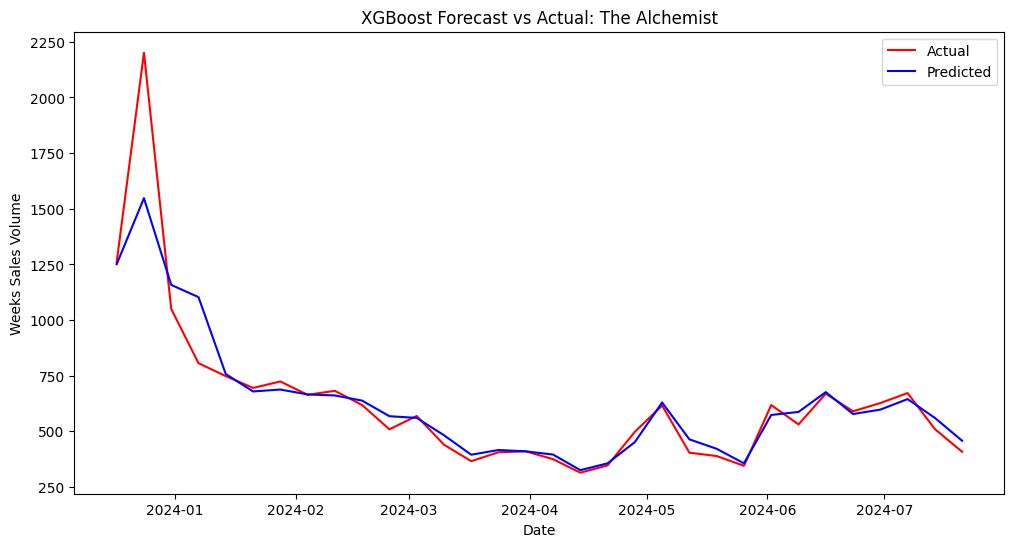

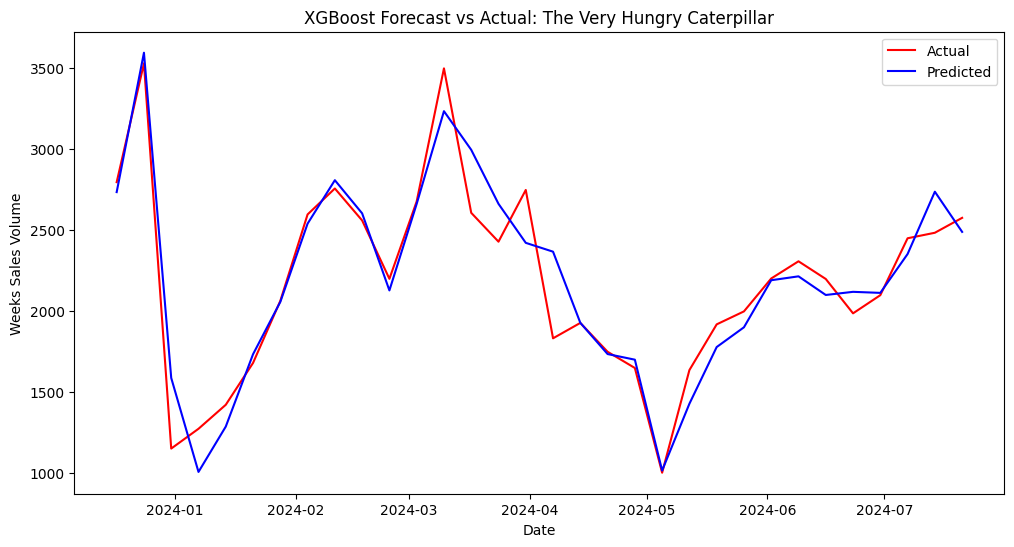

In [ ]:
# Plot data along with the predictions.
def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label="Actual", color='red')
    plt.plot(y_test.index, y_pred, label="Predicted", color='blue')
    plt.title(f"XGBoost Forecast vs Actual: {title}")
    plt.xlabel("Date")
    plt.ylabel("Weeks Sales Volume")
    plt.legend()
    plt.show()

# Plot predictions for each book
plot_predictions(y_test_alchemist, y_pred_alchemist, "The Alchemist")
plot_predictions(y_test_caterpillar, y_pred_caterpillar, "The Very Hungry Caterpillar")

In [ ]:
# Evaluate performance with multiple window_length values
best_results = {}

for window_length in [3, 5, 7, 10]:
    print(f"\n🔁 Window Length: {window_length}")

    # Prepare data for both books
    X_train_al, y_train_al, X_test_al, y_test_al = prepare_data(alchemist_data, training_start_date, forecast_horizon, window_length)
    X_train_cat, y_train_cat, X_test_cat, y_test_cat = prepare_data(caterpillar_data, training_start_date, forecast_horizon, window_length)

    # Train and evaluate
    model_al, y_pred_al = train_xgboost(X_train_al, y_train_al, X_test_al, y_test_al, book_name=f"The Alchemist (window={window_length})")
    model_cat, y_pred_cat = train_xgboost(X_train_cat, y_train_cat, X_test_cat, y_test_cat, book_name=f"The Very Hungry Caterpillar (window={window_length})")

    # Save best results if lower MAE (for example)
    mae_al = mean_absolute_error(y_test_al, y_pred_al)
    mae_cat = mean_absolute_error(y_test_cat, y_pred_cat)

    if 'al' not in best_results or mae_al < best_results['al']['mae']:
        best_results['al'] = {'window': window_length, 'mae': mae_al, 'y_pred': y_pred_al, 'y_test': y_test_al}

    if 'cat' not in best_results or mae_cat < best_results['cat']['mae']:
        best_results['cat'] = {'window': window_length, 'mae': mae_cat, 'y_pred': y_pred_cat, 'y_test': y_test_cat}



🔁 Window Length: 3


'XGBoost Results for The Alchemist (window=3):'

'MAE: 56.77, MAPE: 7.19%'

'XGBoost Results for The Very Hungry Caterpillar (window=3):'

'MAE: 132.21, MAPE: 7.12%'


🔁 Window Length: 5


'XGBoost Results for The Alchemist (window=5):'

'MAE: 117.42, MAPE: 17.02%'

'XGBoost Results for The Very Hungry Caterpillar (window=5):'

'MAE: 276.85, MAPE: 15.27%'


🔁 Window Length: 7


'XGBoost Results for The Alchemist (window=7):'

'MAE: 133.19, MAPE: 19.92%'

'XGBoost Results for The Very Hungry Caterpillar (window=7):'

'MAE: 367.69, MAPE: 18.68%'


🔁 Window Length: 10


'XGBoost Results for The Alchemist (window=10):'

'MAE: 112.17, MAPE: 17.43%'

'XGBoost Results for The Very Hungry Caterpillar (window=10):'

'MAE: 373.95, MAPE: 20.46%'



---


**XGTBoost Model Results Analysis**

* The XGBoost model performed exceptionally well, achieving relatively small MAE and MAPE values for both books. This demonstrates that the model effectively captures the patterns and dynamics in the data.

* The best XGBoost model run (with results close to window length 3 but marginally better) outperforms all the models evaluated in the loop with window sizes of 3, 5, 7, and 10. In this case, we exclude window length as a parameter in the tuning process because it does not yield better results. Instead, we include it here only for comparison purposes with the best model. Therefore, we proceed with the model that does not involve window length tuning.



---



# 4.2 LSTM Model

In [ ]:
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Set random seeds for reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)


# Define the LSTM model creation function
def create_lstm_model(hp, input_shape):
    model = Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=128, step=16),
                   activation='relu',
                   kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(1, kernel_initializer=GlorotUniform(seed=42)))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train LSTM and perform hyperparameter tuning
def train_and_predict(X_train, y_train, X_test, y_test, book_name):
    X_train_3d = np.expand_dims(X_train.values, axis=2)
    X_test_3d = np.expand_dims(X_test.values, axis=2)

    tuner = RandomSearch(
        lambda hp: create_lstm_model(hp, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])),
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory=f'lstm_tuning/{book_name.replace(" ", "_").lower()}',
        project_name='lstm_sales_forecast',
        overwrite=True,
    )

    tuner.search(X_train_3d, y_train, epochs=20, validation_split=0.2, verbose=0)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    model.fit(X_train_3d, y_train, epochs=50, validation_split=0.2, verbose=0)

    y_pred = model.predict(X_test_3d).squeeze()
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    return y_pred, mae, mape

1/1 [==============================] - 0s 103ms/step
MAE for The Alchemist: 45.16146278381348
MAPE for The Alchemist: 5.383262712036274
1/1 [==============================] - 0s 89ms/step
MAE for The Very Hungry Caterpillar: 288.37231826782227
MAPE for The Very Hungry Caterpillar: 14.334595453537387


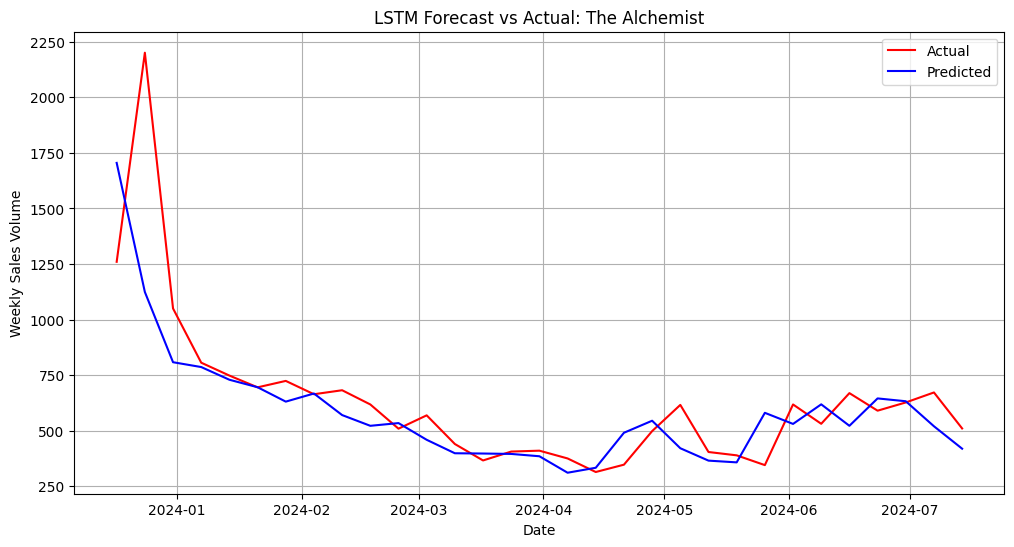

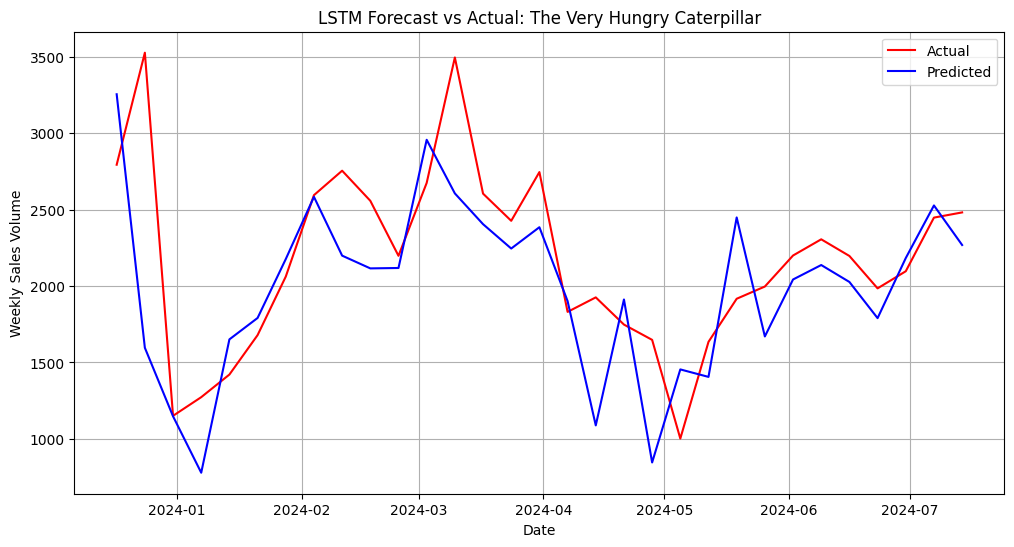

In [ ]:
# Plot actual vs. predicted data for the last 32 weeks
def plot_predictions_2024(y_test, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, color='red', label='Actual')
    plt.plot(y_test.index, y_pred, color='blue', label='Predicted')
    plt.title(f"LSTM Forecast vs Actual: {title}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales Volume")
    plt.legend()
    plt.grid()
    plt.show()

# Filter the last 32 weeks ending on 2024-07-21
def filter_32weeks_data(y_test, y_pred, end_date="2024-07-21", weeks=32):
    prediction_end_date = pd.to_datetime(end_date)
    prediction_start_date = prediction_end_date - pd.Timedelta(weeks=weeks)  # 32 weeks in days
    y_test_32weeks = y_test.loc[prediction_start_date:prediction_end_date]
    y_pred_32weeks = y_pred[-len(y_test_32weeks):]
    return y_test_32weeks, y_pred_32weeks

# Load data and prepare for each book
alchemist_data = filtered_df[filtered_df['Title'] == "Alchemist, The"].resample('W').sum()['Volume']
caterpillar_data = filtered_df[filtered_df['Title'] == "Very Hungry Caterpillar, The"].resample('W').sum()['Volume']

forecast_horizon = 32
training_start_date = "2012-01-01"

X_train_alchemist, y_train_alchemist, X_test_alchemist, y_test_alchemist = prepare_data(
    alchemist_data, training_start_date, forecast_horizon
)
X_train_caterpillar, y_train_caterpillar, X_test_caterpillar, y_test_caterpillar = prepare_data(
    caterpillar_data, training_start_date, forecast_horizon
)

# Train and predict for "The Alchemist"
y_pred_alchemist, mae_alchemist, mape_alchemist = train_and_predict(
    X_train_alchemist, y_train_alchemist, X_test_alchemist, y_test_alchemist, "The Alchemist"
)
print(f"MAE for The Alchemist: {mae_alchemist}")
print(f"MAPE for The Alchemist: {mape_alchemist}")

# Train and predict for "The Very Hungry Caterpillar"
y_pred_caterpillar, mae_caterpillar, mape_caterpillar = train_and_predict(
    X_train_caterpillar, y_train_caterpillar, X_test_caterpillar, y_test_caterpillar, "The Very Hungry Caterpillar"
)
print(f"MAE for The Very Hungry Caterpillar: {mae_caterpillar}")
print(f"MAPE for The Very Hungry Caterpillar: {mape_caterpillar}")

# Filter and plot predictions for the last 32 weeks (The Alchemist)
y_test_32weeks_alchemist, y_pred_32weeks_alchemist = filter_32weeks_data(y_test_alchemist, y_pred_alchemist, end_date="2024-07-20")
plot_predictions_2024(y_test_32weeks_alchemist, y_pred_32weeks_alchemist, "The Alchemist")

# Filter and plot predictions for the last 32 weeks (The Very Hungry Caterpillar)
y_test_32weeks_caterpillar, y_pred_32weeks_caterpillar = filter_32weeks_data(y_test_caterpillar, y_pred_caterpillar, end_date="2024-07-20")
plot_predictions_2024(y_test_32weeks_caterpillar, y_pred_32weeks_caterpillar, "The Very Hungry Caterpillar")



---


**LSTM Model Results Analysis**

* **The Alchemist**: The LSTM model performed exceptionally well, achieving the lowest error metrics (MAE: 45.16, MAPE: 5.38%).

* This performance surpasses that of the XGBoost model, demonstrating LSTM's ability to capture long-term patterns effectively.

* The relatively stable weekly volumes of The Alchemist(~500–600) make it easier for the LSTM model to generalise and learn the underlying trends.


---


* **The Very Hungry Caterpillar** : the LSTM model does not outperform XGBoost (MAE: 288.37, MAPE: 14.33%)

* It is observed that the weekly volumes range from 500 to 1140+, with more erratic fluctuations.

* Stronger Seasonality: spikes around holidays and children’s book purchases introduce patterns that are harder for the LSTM model to capture unless seasonality is explicitly modeled.


---


* These findings reinforce the idea that there is no one-size-fits-all model for forecasting.

* XGBoost effectively captures the stronger seasonality and erratic weekly demand for The Very Hungry Caterpillar, which presents challenges for the LSTM model's ability to generalise effectively.

* In contrast, The Alchemist benefits from more stable sales patterns, allowing the LSTM model to leverage its strength in learning long-term trends.



---





# 5. Hybrid Model (SARIMA and LSTM in Sequential Combination)



---


* It is recommended to restart the kernel and run it up until the first section of Section 4 to prepare the data for feeding into ML models. This ensures the avoidance of data leakage or unintended contamination of the training and testing datasets, thereby maintaining the integrity and reliability of the model evaluation.




---





In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
from tensorflow.keras.initializers import GlorotUniform
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

<ipython-input-10-1b545177e4c0>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Set the seed for Python's random module
random.seed(42)

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

In [ ]:
# Train SARIMA and Calculate Residuals

def train_sarima(y_train, p, d, q, P, D, Q, s):
    # Train SARIMA model
    sarima_model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    sarima_fit = sarima_model.fit(disp=False)

    # Forecast the training period
    sarima_train_pred = sarima_fit.predict(start=y_train.index[0], end=y_train.index[-1])

    # Calculate residuals
    residuals = y_train - sarima_train_pred

    return sarima_fit, sarima_train_pred, residuals

# Train SARIMA for "The Alchemist"
sarima_alchemist, sarima_train_pred_alchemist, residuals_alchemist = train_sarima(
    y_train_alchemist, p=1, d=1, q=1, P=1, D=1, Q=1, s=52
)

# Train SARIMA for "The Very Hungry Caterpillar"
sarima_caterpillar, sarima_train_pred_caterpillar, residuals_caterpillar = train_sarima(
    y_train_caterpillar, p=1, d=1, q=1, P=1, D=1, Q=1, s=52
)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# Prepare Residuals for LSTM

# Create lagged features for residuals

def create_lstm_dataset(data, look_back=1):
    """
    Create lagged features and target variables for LSTM training.

    Parameters:
        data (array-like): Input time series data (e.g., residuals).
        look_back (int): Number of lagged time steps to use as input features.

    Returns:
        X (np.array): Input features (lagged values).
        y (np.array): Target variable (next value in the sequence).
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])  # Lagged features
        y.append(data[i + look_back])   # Next value in the sequence
    return np.array(X), np.array(y)

X_residuals_alchemist, y_residuals_alchemist = create_lstm_dataset(residuals_alchemist.values, look_back=52)
X_residuals_caterpillar, y_residuals_caterpillar = create_lstm_dataset(residuals_caterpillar.values, look_back=52)

# Split residuals into training and validation sets
split_idx_alchemist = int(len(X_residuals_alchemist) * 0.8)
X_train_residuals_alchemist = X_residuals_alchemist[:split_idx_alchemist]
y_train_residuals_alchemist = y_residuals_alchemist[:split_idx_alchemist]
X_val_residuals_alchemist = X_residuals_alchemist[split_idx_alchemist:]
y_val_residuals_alchemist = y_residuals_alchemist[split_idx_alchemist:]

split_idx_caterpillar = int(len(X_residuals_caterpillar) * 0.8)
X_train_residuals_caterpillar = X_residuals_caterpillar[:split_idx_caterpillar]
y_train_residuals_caterpillar = y_residuals_caterpillar[:split_idx_caterpillar]
X_val_residuals_caterpillar = X_residuals_caterpillar[split_idx_caterpillar:]
y_val_residuals_caterpillar = y_residuals_caterpillar[split_idx_caterpillar:]

In [ ]:
# Reshape X_train_residuals_alchemist to 3D
X_train_residuals_alchemist = np.expand_dims(X_train_residuals_alchemist, axis=2)
X_val_residuals_alchemist = np.expand_dims(X_val_residuals_alchemist, axis=2)

# Similarly for Caterpillar data
X_train_residuals_caterpillar = np.expand_dims(X_train_residuals_caterpillar, axis=2)
X_val_residuals_caterpillar = np.expand_dims(X_val_residuals_caterpillar, axis=2)

In [ ]:
print("Shape of X_train_residuals_alchemist:", X_train_residuals_alchemist.shape)
print("Shape of X_val_residuals_alchemist:", X_val_residuals_alchemist.shape)
print("Shape of X_train_residuals_caterpillar:", X_train_residuals_caterpillar.shape)
print("Shape of X_val_residuals_caterpillar:", X_val_residuals_caterpillar.shape)

Shape of X_train_residuals_alchemist: (453, 52, 1)
Shape of X_val_residuals_alchemist: (114, 52, 1)
Shape of X_train_residuals_caterpillar: (453, 52, 1)
Shape of X_val_residuals_caterpillar: (114, 52, 1)


# 5.1 Hybrid Model - The Alchemist

In [ ]:
# Define the model-building function
def create_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation='relu',
        input_shape=(X_train_residuals_alchemist.shape[1], X_train_residuals_alchemist.shape[2])
    ))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate the tuner
tuner = RandomSearch(
    create_lstm_model,  # The model-building function
    objective='val_loss',  # Metric to optimize
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Number of times to train each model
    directory='hybrid_model_tuning',  # Directory to save tuning results
    project_name='sarima_lstm',  # Project name
    seed=42  # Set seed for reproducibility
)

# Perform the hyperparameter search
tuner.search(
    X_train_residuals_alchemist, y_train_residuals_alchemist,
    validation_data=(X_val_residuals_alchemist, y_val_residuals_alchemist),
    epochs=20,  # Number of epochs per trial
    verbose=0  # Suppress output
)

In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"The optimal number of units in the LSTM layer is {best_hps.get('units')}.")

The optimal number of units in the LSTM layer is 96.


In [ ]:
# Build the model with the best hyperparameters
lstm_model_alchemist = tuner.hypermodel.build(best_hps)

# Train the best model on the residuals
history = lstm_model_alchemist.fit(
    X_train_residuals_alchemist, y_train_residuals_alchemist,
    validation_data=(X_val_residuals_alchemist, y_val_residuals_alchemist),
    epochs=50,  # Train for more epochs
    verbose=0
)


In [ ]:
# # Forecast residuals for the next 32 weeks
X_forecast_residuals = residuals_alchemist[-52:].values.reshape(1, 52, 1)  # Use the last 52 residuals
lstm_forecast_residuals_alchemist = []

for _ in range(32):
    pred = lstm_model_alchemist.predict(X_forecast_residuals)  # Prediction shape: (1, 1)
    lstm_forecast_residuals_alchemist.append(pred[0, 0])  # Extract scalar value

    # Reshape pred to match (1, 1, 1) and append to X_forecast_residuals
    pred_reshaped = pred.reshape(1, 1, 1)
    X_forecast_residuals = np.append(X_forecast_residuals[:, 1:, :], pred_reshaped, axis=1)

1/1 [==============================] - 0s 13ms/step


In [ ]:
# Combine SARIMA and LSTM Predictions
# Get SARIMA predictions for the next 32 weeks
sarima_forecast_alchemist = sarima_alchemist.forecast(steps=32)

# Combine SARIMA and LSTM predictions
final_forecast_alchemist = sarima_forecast_alchemist + np.array(lstm_forecast_residuals_alchemist)

In [ ]:
# Evaluate the hybrid model
mae_hybrid = mean_absolute_error(y_test_alchemist, final_forecast_alchemist)
mape_hybrid = mean_absolute_percentage_error(y_test_alchemist, final_forecast_alchemist) * 100

# Evaluate SARIMA-only predictions
mae_sarima = mean_absolute_error(y_test_alchemist, sarima_forecast_alchemist)
mape_sarima = mean_absolute_percentage_error(y_test_alchemist, sarima_forecast_alchemist) * 100

# Print results
print(f"Hybrid Model - MAE: {mae_hybrid:.2f}, MAPE: {mape_hybrid:.2f}%")
print(f"SARIMA-Only Model - MAE: {mae_sarima:.2f}, MAPE: {mape_sarima:.2f}%")

Hybrid Model - MAE: 138.95, MAPE: 21.05%
SARIMA-Only Model - MAE: 140.62, MAPE: 21.59%


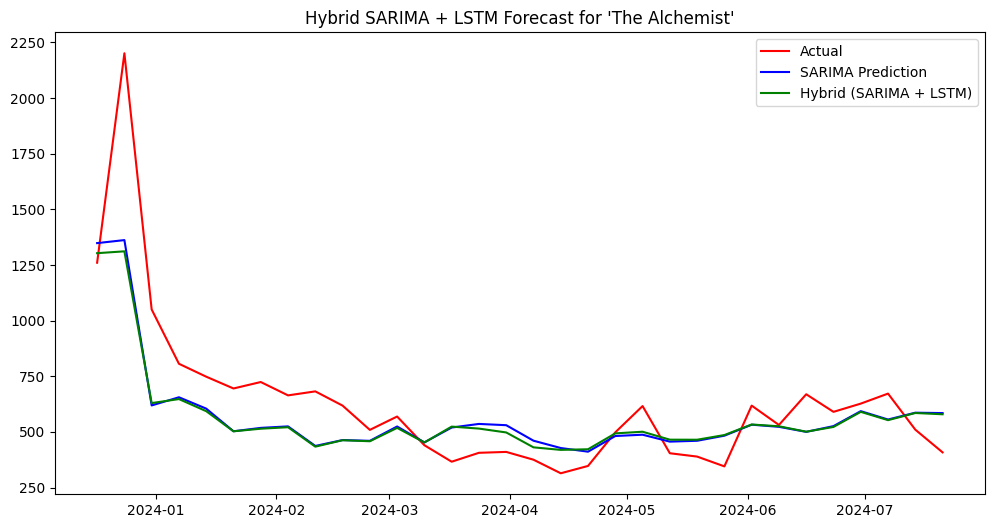

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_alchemist.index, y_test_alchemist.values, label="Actual", color="red")
plt.plot(y_test_alchemist.index, sarima_forecast_alchemist, label="SARIMA Prediction", color="blue")
plt.plot(y_test_alchemist.index, final_forecast_alchemist, label="Hybrid (SARIMA + LSTM)", color="green")
plt.legend()
plt.title("Hybrid SARIMA + LSTM Forecast for 'The Alchemist'")
plt.show()



---


**Hybrid Model Result Analysis - The Alchemist**

* The hybrid model shows only marginal improvement compared to the SARIMA-only model.
* Both hybrid and SARIMA models significantly lag behind XGBoost and LSTM standalone models in terms of accuracy and performance.
* The hybrid model is not recommended for forecasting unless strong fine-tuning demonstrates otherwise. The XGBoost and LSTM models remain the better choices for accurate forecasting.


---



# 5.2 Hybrid Model - The Very Hungry Caterpillar

In [ ]:
# Define the model-building function
def create_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation='relu',
        input_shape=(X_train_residuals_caterpillar.shape[1], X_train_residuals_caterpillar.shape[2])
    ))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate the tuner
tuner = RandomSearch(
    create_lstm_model,  # The model-building function
    objective='val_loss',  # Metric to optimize
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Number of times to train each model
    directory='hybrid_model_tuning',  # Directory to save tuning results
    project_name='sarima_lstm',  # Project name
    seed=42  # Set seed for reproducibility
)

Reloading Tuner from hybrid_model_tuning/sarima_lstm/tuner0.json


In [ ]:
# Perform the hyperparameter search for Caterpillar residuals
tuner.search(
    X_train_residuals_caterpillar, y_train_residuals_caterpillar,
    validation_data=(X_val_residuals_caterpillar, y_val_residuals_caterpillar),
    epochs=20,  # Number of epochs per trial
    verbose=1  # Show progress
)

# Retrieve the best hyperparameters
best_hps_caterpillar = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print results
print(f"The optimal number of units in the LSTM layer is {best_hps_caterpillar.get('units')}.")

The optimal number of units in the LSTM layer is 96.


In [ ]:
# Build and train the best model for Caterpillar residuals
lstm_model_caterpillar = tuner.hypermodel.build(best_hps_caterpillar)

history_caterpillar = lstm_model_caterpillar.fit(
    X_train_residuals_caterpillar, y_train_residuals_caterpillar,
    validation_data=(X_val_residuals_caterpillar, y_val_residuals_caterpillar),
    epochs=50,  # Train for more epochs
    verbose=1  # Show progress
)

Epoch 1/50
15/15 [==============================] - 1s 27ms/step - loss: 313377.2500 - val_loss: 195115.6250
Epoch 2/50
15/15 [==============================] - 0s 16ms/step - loss: 528969.8125 - val_loss: 1171960.3750
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 8999295.0000 - val_loss: 70288272.0000
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 127531200.0000 - val_loss: 513430560.0000
Epoch 5/50
15/15 [==============================] - 0s 15ms/step - loss: 391156896.0000 - val_loss: 1311299712.0000
Epoch 6/50
15/15 [==============================] - 0s 16ms/step - loss: 606105344.0000 - val_loss: 688706496.0000
Epoch 7/50
15/15 [==============================] - 0s 16ms/step - loss: 42976484.0000 - val_loss: 40358064.0000
Epoch 8/50
15/15 [==============================] - 0s 16ms/step - loss: 454398624.0000 - val_loss: 200620.0938
Epoch 9/50
15/15 [==============================] - 0s 17ms/step - loss: 249447.2188 - val_loss: 1

In [ ]:
# Forecast residuals for the next 32 weeks
X_forecast_residuals_caterpillar = residuals_caterpillar[-52:].values.reshape(1, 52, 1)  # Last 52 residuals
lstm_forecast_residuals_caterpillar = []

for _ in range(32):
    pred = lstm_model_caterpillar.predict(X_forecast_residuals_caterpillar)  # Prediction shape: (1, 1)
    lstm_forecast_residuals_caterpillar.append(pred[0, 0])  # Extract scalar value

    # Reshape pred to match (1, 1, 1) and append to X_forecast_residuals
    pred_reshaped = pred.reshape(1, 1, 1)
    X_forecast_residuals_caterpillar = np.append(X_forecast_residuals_caterpillar[:, 1:, :], pred_reshaped, axis=1)

1/1 [==============================] - 0s 13ms/step


In [ ]:
# Get SARIMA predictions for the next 32 weeks
sarima_forecast_caterpillar = sarima_caterpillar.forecast(steps=32)

# Combine SARIMA and LSTM predictions
final_forecast_caterpillar = sarima_forecast_caterpillar + np.array(lstm_forecast_residuals_caterpillar)

In [ ]:
# Evaluate the hybrid model
mae_hybrid_caterpillar = mean_absolute_error(y_test_caterpillar, final_forecast_caterpillar)
mape_hybrid_caterpillar = mean_absolute_percentage_error(y_test_caterpillar, final_forecast_caterpillar) * 100

# Evaluate SARIMA-only predictions
mae_sarima_caterpillar = mean_absolute_error(y_test_caterpillar, sarima_forecast_caterpillar)
mape_sarima_caterpillar = mean_absolute_percentage_error(y_test_caterpillar, sarima_forecast_caterpillar) * 100

# Print results
print(f"Hybrid Model - MAE: {mae_hybrid_caterpillar:.2f}, MAPE: {mape_hybrid_caterpillar:.2f}%")
print(f"SARIMA-Only Model - MAE: {mae_sarima_caterpillar:.2f}, MAPE: {mape_sarima_caterpillar:.2f}%")

Hybrid Model - MAE: 485.10, MAPE: 22.22%
SARIMA-Only Model - MAE: 417.85, MAPE: 18.65%


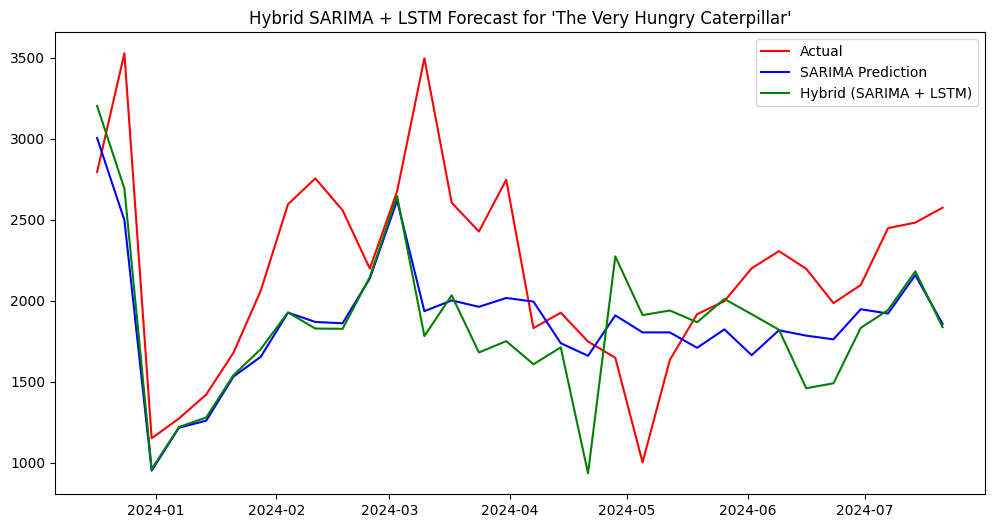

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_caterpillar.index, y_test_caterpillar.values, label="Actual", color="red")
plt.plot(y_test_caterpillar.index, sarima_forecast_caterpillar, label="SARIMA Prediction", color="blue")
plt.plot(y_test_caterpillar.index, final_forecast_caterpillar, label="Hybrid (SARIMA + LSTM)", color="green")
plt.legend()
plt.title("Hybrid SARIMA + LSTM Forecast for 'The Very Hungry Caterpillar'")
plt.show()



---


**Hybrid Model Result Analysis - The Very Hungry Caterpillar**

* The hybrid model shows poorer performance than the SARIMA-only model, with higher MAE and MAPE values.
* Both models lag behind XGBoost and LSTM in terms of accuracy and forecasting performance.
* The hybrid model is not recommended for forecasting unless strong fine-tuning demonstrates otherwise. The XGBoost and LSTM models remain the better choices for accurate forecasting.


---



# 5.3 Hybrid Model of SARIMA and LSTM With Weight Adjustments



---


It is recommended to restart the kernel and run it up until the first section of Section 5 to prepare the data for repare the data properly for feeding into the Hybrid Model of SARIMA and LSTM. This ensures the avoidance of data leakage or unintended contamination of the training and testing datasets, thereby maintaining the integrity and reliability of the model evaluation.


---



In [ ]:
# Train SARIMA for "The Alchemist"
sarima_alchemist, sarima_train_pred_alchemist, _ = train_sarima(
    y_train_alchemist, p=1, d=1, q=1, P=1, D=1, Q=1, s=52
)
sarima_forecast_alchemist = sarima_alchemist.forecast(steps=32)

# Train SARIMA for "The Very Hungry Caterpillar"
sarima_caterpillar, sarima_train_pred_caterpillar, _ = train_sarima(
    y_train_caterpillar, p=1, d=1, q=1, P=1, D=1, Q=1, s=52
)
sarima_forecast_caterpillar = sarima_caterpillar.forecast(steps=32)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


# 5.4 Hybrid Model With Weight Adjustments - The Alchemist

In [ ]:
from keras.callbacks import EarlyStopping
import keras_tuner as kt

# Define the model-building function
def create_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation='relu',
        input_shape=(X_train_residuals_alchemist.shape[1], X_train_residuals_alchemist.shape[2])
    ))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate the tuner
tuner = RandomSearch(
    create_lstm_model,  # The model-building function
    objective='val_loss',  # Metric to optimize
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Number of times to train each model
    directory='hybrid_model_tuning',  # Directory to save tuning results
    project_name='sarima_lstm',  # Project name
    seed=42  # Set seed for reproducibility
)

# LSTM for "The Alchemist"
# Perform the hyperparameter search
tuner.search(
    X_train_residuals_alchemist, y_train_residuals_alchemist,
    validation_data=(X_val_residuals_alchemist, y_val_residuals_alchemist),
    epochs=20, verbose=0
)

# Retrieve and train the best model
best_hps_alchemist = tuner.get_best_hyperparameters(num_trials=1)[0]
lstm_model_alchemist = tuner.hypermodel.build(best_hps_alchemist)


# Define the EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1            # Print a message when early stopping is triggered
)

# Train the LSTM model with EarlyStopping for "The Alchemist"
history_alchemist = lstm_model_alchemist.fit(
    X_train_residuals_alchemist, y_train_residuals_alchemist,
    validation_data=(X_val_residuals_alchemist, y_val_residuals_alchemist),
    epochs=50,  # Maximum number of epochs
    verbose=0,
    callbacks=[early_stopper]  # Add the EarlyStopping callback
)

# Forecast residuals for the next 32 weeks
X_forecast_residuals_alchemist = residuals_alchemist[-52:].values.reshape(1, 52, 1)
lstm_forecast_residuals_alchemist = []

for _ in range(32):
    pred = lstm_model_alchemist.predict(X_forecast_residuals_alchemist)
    lstm_forecast_residuals_alchemist.append(pred[0, 0])
    pred_reshaped = pred.reshape(1, 1, 1)
    X_forecast_residuals_alchemist = np.append(X_forecast_residuals_alchemist[:, 1:, :], pred_reshaped, axis=1)

Reloading Tuner from hybrid_model_tuning/sarima_lstm/tuner0.json
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
1/1 [==============================] - 0s 13ms/step


In [ ]:
# Combine SARIMA and LSTM Predictions Using Weighted Average
# Define weight combinations (adjust as needed)
weights = [
    (0.5, 0.5),  # Equal weights
    (0.6, 0.4),  # SARIMA has higher weight
    (0.4, 0.6),  # LSTM has higher weight
]

# Store results for evaluation
results_alchemist = []

for w_sarima, w_lstm in weights:
    hybrid_forecast_alchemist = (
        w_sarima * sarima_forecast_alchemist +
        w_lstm * np.array(lstm_forecast_residuals_alchemist)
    )

    # Evaluate
    mae = mean_absolute_error(y_test_alchemist, hybrid_forecast_alchemist)
    mape = mean_absolute_percentage_error(y_test_alchemist, hybrid_forecast_alchemist) * 100
    results_alchemist.append((w_sarima, w_lstm, mae, mape))

# Print results
print("Results for 'The Alchemist':")
for w_sarima, w_lstm, mae, mape in results_alchemist:
    print(f"Weights (SARIMA: {w_sarima}, LSTM: {w_lstm}) - MAE: {mae:.2f}, MAPE: {mape:.2f}%")

Results for 'The Alchemist':
Weights (SARIMA: 0.5, LSTM: 0.5) - MAE: 348.45, MAPE: 48.72%
Weights (SARIMA: 0.6, LSTM: 0.4) - MAE: 293.97, MAPE: 40.07%
Weights (SARIMA: 0.4, LSTM: 0.6) - MAE: 402.94, MAPE: 57.38%


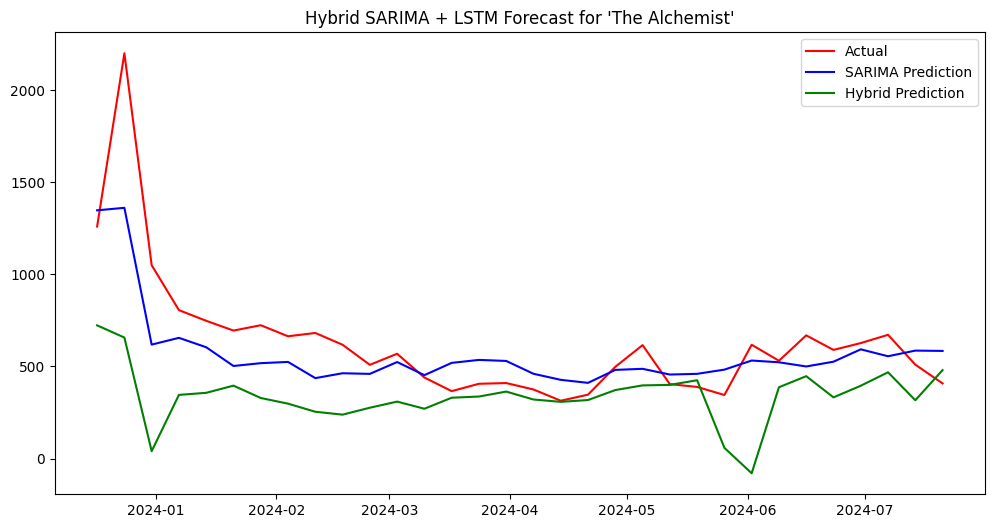

In [ ]:
# Plot the result for The Alchemist
# Choose the best weights (e.g., based on minimum MAE or MAPE)
best_weights_alchemist = min(results_alchemist, key=lambda x: x[2])  # Minimise MAE
w_sarima, w_lstm = best_weights_alchemist[:2]

# Final hybrid predictions
final_hybrid_forecast_alchemist = (
    w_sarima * sarima_forecast_alchemist +
    w_lstm * np.array(lstm_forecast_residuals_alchemist)
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_alchemist.index, y_test_alchemist.values, label="Actual", color="red")
plt.plot(y_test_alchemist.index, sarima_forecast_alchemist, label="SARIMA Prediction", color="blue")
plt.plot(y_test_alchemist.index, final_hybrid_forecast_alchemist, label="Hybrid Prediction", color="green")
plt.legend()
plt.title("Hybrid SARIMA + LSTM Forecast (Weight Adjustments) for 'The Alchemist'")
plt.show()

In [ ]:
# Modify the weightage in the parallel combination model to get different results
# Define the weight combinations for SARIMA and LSTM (from 0.0, 1.0 to 1.0, 0.0)
weights = [(i/10, 1-i/10) for i in range(11)]  # Weights: (0.0, 1.0), (0.1, 0.9), ..., (1.0, 0.0)

# List to store results for evaluation
results_alchemist = []

# Combine SARIMA and LSTM Predictions using different weights for "The Alchemist"
for ws, wl in weights:
    hybrid_forecast_alchemist = (
        ws * sarima_forecast_alchemist +  # Ensure sarima_forecast_alchemist is defined
        wl * np.array(lstm_forecast_residuals_alchemist)  # Ensure lstm_forecast_residuals_alchemist is defined
    )

    # Evaluate the performance: MAE and MAPE
    mae = mean_absolute_error(y_test_alchemist, hybrid_forecast_alchemist)
    mape = mean_absolute_percentage_error(y_test_alchemist, hybrid_forecast_alchemist) * 100
    results_alchemist.append((ws, wl, mae, mape))

# Print results for each weight combination
print("Results for 'The Alchemist':")
for ws, wl, mae, mape in results_alchemist:
    print(f"Weights (SARIMA: {ws}, LSTM: {wl}) - MAE: {mae:.2f}, MAPE: {mape:.2f}%")

# Find the best weight combination (minimize MAE)
best_ws_alchemist, best_wl_alchemist = min(results_alchemist, key=lambda x: x[2])[:2]

# Final hybrid prediction for the best weight combination for "The Alchemist"
final_hybrid_alchemist = best_ws_alchemist * sarima_forecast_alchemist + best_wl_alchemist * np.array(lstm_forecast_residuals_alchemist)

# Print the best weight combination and the corresponding performance for "The Alchemist"
print(f"\nBest Weight Combination for 'The Alchemist':")
print(f"SARIMA Weight: {best_ws_alchemist}, LSTM Weight: {best_wl_alchemist}")
print(f"Final MAE: {min(results_alchemist, key=lambda x: x[2])[2]:.2f}")
print(f"Final MAPE: {min(results_alchemist, key=lambda x: x[3])[3]:.2f}%")


Results for 'The Alchemist':
Weights (SARIMA: 0.0, LSTM: 1.0) - MAE: 627.09, MAPE: 93.53%
Weights (SARIMA: 0.1, LSTM: 0.9) - MAE: 570.43, MAPE: 84.33%
Weights (SARIMA: 0.2, LSTM: 0.8) - MAE: 513.89, MAPE: 75.17%
Weights (SARIMA: 0.3, LSTM: 0.7) - MAE: 457.78, MAPE: 66.12%
Weights (SARIMA: 0.4, LSTM: 0.6) - MAE: 402.94, MAPE: 57.38%
Weights (SARIMA: 0.5, LSTM: 0.5) - MAE: 348.45, MAPE: 48.72%
Weights (SARIMA: 0.6, LSTM: 0.4) - MAE: 293.97, MAPE: 40.07%
Weights (SARIMA: 0.7, LSTM: 0.30000000000000004) - MAE: 242.33, MAPE: 32.24%
Weights (SARIMA: 0.8, LSTM: 0.19999999999999996) - MAE: 199.80, MAPE: 26.81%
Weights (SARIMA: 0.9, LSTM: 0.09999999999999998) - MAE: 162.89, MAPE: 22.86%
Weights (SARIMA: 1.0, LSTM: 0.0) - MAE: 140.62, MAPE: 21.59%

Best Weight Combination for 'The Alchemist':
SARIMA Weight: 1.0, LSTM Weight: 0.0
Final MAE: 140.62
Final MAPE: 21.59%




---


**Weight Adjustments Analysis - The Alchemist**

* The weight adjustments for the hybrid model did not yield very desirable outcomes. While the 50/50 weight combination (SARIMA: 0.5, LSTM: 0.5) performed poorly, the best-performing model was 100% SARIMA (SARIMA Weight: 1.0, LSTM Weight: 0.0). Even so, the results remain suboptimal (Final MAE: 140.62
Final MAPE: 21.59%).

* It is clear that LSTM does not offer much improvement in the parameter mix.



---



# 5.5 Hybrid Model With Weight Adjustments - The Very Hungry Caterpillar

In [ ]:
# Define the model-building function
def create_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=16, max_value=128, step=16),
        activation='relu',
        input_shape=(X_train_residuals_caterpillar.shape[1], X_train_residuals_caterpillar.shape[2])
    ))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate the tuner
tuner = RandomSearch(
    create_lstm_model,  # The model-building function
    objective='val_loss',  # Metric to optimize
    max_trials=10,  # Number of trials to run
    executions_per_trial=1,  # Number of times to train each model
    directory='hybrid_model_tuning',  # Directory to save tuning results
    project_name='sarima_lstm',  # Project name
    seed=42  # Set seed for reproducibility
)

# Perform the hyperparameter search
tuner.search(
    X_train_residuals_caterpillar, y_train_residuals_caterpillar,
    validation_data=(X_val_residuals_caterpillar, y_val_residuals_caterpillar),
    epochs=20, verbose=1
)

# Retrieve and train the best model
best_hps_caterpillar = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model for "The Very Hungry Caterpillar" with the best hyperparameters
lstm_model_caterpillar = tuner.hypermodel.build(best_hps_caterpillar)

# Define the EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1            # Print a message when early stopping is triggered
)

# Train the LSTM model with EarlyStopping for "The Very Hungry Caterpillar"
history_caterpillar = lstm_model_caterpillar.fit(
    X_train_residuals_caterpillar, y_train_residuals_caterpillar,
    validation_data=(X_val_residuals_caterpillar, y_val_residuals_caterpillar),
    epochs=50,  # Maximum number of epochs
    verbose=0,
    callbacks=[early_stopper]  # Add the EarlyStopping callback
)
# Forecast residuals for the next 32 weeks
X_forecast_residuals_caterpillar = residuals_caterpillar[-52:].values.reshape(1, 52, 1)
lstm_forecast_residuals_caterpillar = []

for _ in range(32):
    pred = lstm_model_caterpillar.predict(X_forecast_residuals_caterpillar)
    lstm_forecast_residuals_caterpillar.append(pred[0, 0])
    pred_reshaped = pred.reshape(1, 1, 1)
    X_forecast_residuals_caterpillar = np.append(X_forecast_residuals_caterpillar[:, 1:, :], pred_reshaped, axis=1)

Reloading Tuner from hybrid_model_tuning/sarima_lstm/tuner0.json
Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping
1/1 [==============================] - 0s 13ms/step


In [ ]:
# Combine Predictions for "The Very Hungry Caterpillar"
# Store results for evaluation
results_caterpillar = []

for w_sarima, w_lstm in weights:
    hybrid_forecast_caterpillar = (
        w_sarima * sarima_forecast_caterpillar +
        w_lstm * np.array(lstm_forecast_residuals_caterpillar)
    )

    # Evaluate
    mae = mean_absolute_error(y_test_caterpillar, hybrid_forecast_caterpillar)
    mape = mean_absolute_percentage_error(y_test_caterpillar, hybrid_forecast_caterpillar) * 100
    results_caterpillar.append((w_sarima, w_lstm, mae, mape))

# Print results
print("Results for 'The Very Hungry Caterpillar':")
for w_sarima, w_lstm, mae, mape in results_caterpillar:
    print(f"Weights (SARIMA: {w_sarima}, LSTM: {w_lstm}) - MAE: {mae:.2f}, MAPE: {mape:.2f}%")

Results for 'The Very Hungry Caterpillar':
Weights (SARIMA: 0.5, LSTM: 0.5) - MAE: 1255.22, MAPE: 55.66%
Weights (SARIMA: 0.6, LSTM: 0.4) - MAE: 1072.19, MAPE: 47.18%
Weights (SARIMA: 0.4, LSTM: 0.6) - MAE: 1442.77, MAPE: 64.60%


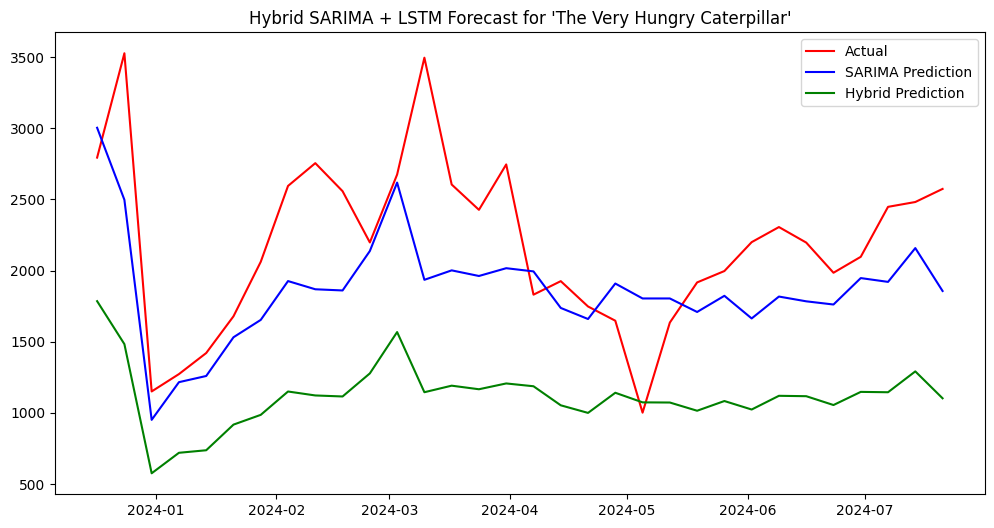

In [ ]:
# Plot the result for The Very Hungry Caterpillar
# Choose the best weights (e.g., based on minimum MAE or MAPE)
best_weights_caterpillar = min(results_caterpillar, key=lambda x: x[2])  # Minimise MAE
w_sarima, w_lstm = best_weights_caterpillar[:2]

# Final hybrid predictions
final_hybrid_forecast_caterpillar = (
    w_sarima * sarima_forecast_caterpillar +
    w_lstm * np.array(lstm_forecast_residuals_caterpillar)
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_caterpillar.index, y_test_caterpillar.values, label="Actual", color="red")
plt.plot(y_test_caterpillar.index, sarima_forecast_caterpillar, label="SARIMA Prediction", color="blue")
plt.plot(y_test_caterpillar.index, final_hybrid_forecast_caterpillar, label="Hybrid Prediction", color="green")
plt.legend()
plt.title("Hybrid SARIMA + LSTM Forecast (Weight Adjustments) for 'The Very Hungry Caterpillar'")
plt.show()

In [ ]:
# Modify the weightage in the parallel combination model to get different results
# Define the weight combinations for SARIMA and LSTM (from 0.0, 1.0 to 1.0, 0.0)
weights = [(i/10, 1-i/10) for i in range(11)]  # Weights: (0.0, 1.0), (0.1, 0.9), ..., (1.0, 0.0)

# List to store results for evaluation
results_caterpillar = []

# Combine SARIMA and LSTM Predictions using different weights for "The Very Hungry Caterpillar"
for ws, wl in weights:
    hybrid_forecast_caterpillar = (
        ws * sarima_forecast_caterpillar +  # Ensure sarima_forecast_caterpillar is defined
        wl * np.array(lstm_forecast_residuals_caterpillar)  # Ensure lstm_forecast_residuals_caterpillar is defined
    )

    # Evaluate the performance: MAE and MAPE
    mae = mean_absolute_error(y_test_caterpillar, hybrid_forecast_caterpillar)
    mape = mean_absolute_percentage_error(y_test_caterpillar, hybrid_forecast_caterpillar) * 100
    results_caterpillar.append((ws, wl, mae, mape))

# Print results for each weight combination
print("Results for 'The Very Hungry Caterpillar':")
for ws, wl, mae, mape in results_caterpillar:
    print(f"Weights (SARIMA: {ws}, LSTM: {wl}) - MAE: {mae:.2f}, MAPE: {mape:.2f}%")

# Find the best weight combination (minimize MAE)
best_ws_caterpillar, best_wl_caterpillar = min(results_caterpillar, key=lambda x: x[2])[:2]

# Final hybrid prediction for the best weight combination for "The Very Hungry Caterpillar"
final_hybrid_cat = best_ws_caterpillar * sarima_forecast_caterpillar + best_wl_caterpillar * np.array(lstm_forecast_residuals_caterpillar)

# Print the best weight combination and the corresponding performance for "The Very Hungry Caterpillar"
print(f"\nBest Weight Combination for 'The Very Hungry Caterpillar':")
print(f"SARIMA Weight: {best_ws_caterpillar}, LSTM Weight: {best_wl_caterpillar}")
print(f"Final MAE: {min(results_caterpillar, key=lambda x: x[2])[2]:.2f}")
print(f"Final MAPE: {min(results_caterpillar, key=lambda x: x[3])[3]:.2f}%")


Results for 'The Very Hungry Caterpillar':
Weights (SARIMA: 0.0, LSTM: 1.0) - MAE: 2192.98, MAPE: 100.35%
Weights (SARIMA: 0.1, LSTM: 0.9) - MAE: 2005.43, MAPE: 91.41%
Weights (SARIMA: 0.2, LSTM: 0.8) - MAE: 1817.88, MAPE: 82.47%
Weights (SARIMA: 0.3, LSTM: 0.7) - MAE: 1630.33, MAPE: 73.54%
Weights (SARIMA: 0.4, LSTM: 0.6) - MAE: 1442.77, MAPE: 64.60%
Weights (SARIMA: 0.5, LSTM: 0.5) - MAE: 1255.22, MAPE: 55.66%
Weights (SARIMA: 0.6, LSTM: 0.4) - MAE: 1072.19, MAPE: 47.18%
Weights (SARIMA: 0.7, LSTM: 0.30000000000000004) - MAE: 896.05, MAPE: 39.38%
Weights (SARIMA: 0.8, LSTM: 0.19999999999999996) - MAE: 719.90, MAPE: 31.58%
Weights (SARIMA: 0.9, LSTM: 0.09999999999999998) - MAE: 548.10, MAPE: 24.04%
Weights (SARIMA: 1.0, LSTM: 0.0) - MAE: 417.85, MAPE: 18.65%

Best Weight Combination for 'The Very Hungry Caterpillar':
SARIMA Weight: 1.0, LSTM Weight: 0.0
Final MAE: 417.85
Final MAPE: 18.65%




---


**Weight Adjustments Analysis - The Very Hungry Caterpillar**

The weight adjustments for the hybrid model did not yield very desirable outcomes. While the 50/50 weight combination (SARIMA: 0.5, LSTM: 0.5) performed poorly, the best-performing model was 100% SARIMA (SARIMA Weight: 1.0, LSTM Weight: 0.0). Even so, the results remain suboptimal (Final MAE: 417.85 Final MAPE: 18.65%).

It is clear that LSTM does not offer much improvement in the parameter mix.



---



# 6. Recommendation for Best Models





---

The optimal models identified through our comprehensive analysis are:




> **The Alchemist**

* **LSTM (Weekly Dataset) - MAE: 45.16, MAPE: 5.38%**


---


> **The Very Hungry Caterpillar**

* **XGBoost (Weekly Dataset) - MAE: 134.97, MAPE: 6.96%**


---


These results demonstrate exceptional accuracy, making these models the most reliable choices for forecasting.


---



